In [1]:
from torch.quasirandom import SobolEngine
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
import hydra
import torch
import botorch
import wandb
from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from mgp_models.fit_fully_bayesian import fit_fully_bayesian_mgp_model_nuts, fit_partially_bayesian_mgp_model
from mgp_models.utils import *
from mgp_models.acquisition import *
from mgp_models.test_functions import *
import time

c:\Users\felip\anaconda3\envs\bo-cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import math
from typing import Optional

from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.base import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from torch import Tensor
import torch

from botorch.acquisition import AnalyticAcquisitionFunction
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from botorch.posteriors.fully_bayesian import GaussianMixturePosterior, MCMC_DIM


In [3]:
tkwargs = {
"device": torch.device("cpu" if torch.cuda.is_available() else "cpu"),
"dtype": torch.double,
}

In [4]:
# class SALHellingerMMAcquisitionFunction(AnalyticAcquisitionFunction):
#     def __init__(
#         self,
#         model: MGPFullyBayesianSingleTaskGP,
#         maximize: bool = True,
#         ll: Optional[Tensor] = None
#     ) -> None:
#         # we use the AcquisitionFunction constructor, since that of
#         # AnalyticAcquisitionFunction performs some validity checks that we don't want here
#         super(AnalyticAcquisitionFunction, self).__init__(model)
#         self.maximize = maximize
#         self.ll = ll

#     def forward(self, X: Tensor) -> Tensor:


#         posterior = self.model.posterior(X, ll= self.ll)
#         n_models = posterior._mean.shape[MCMC_DIM]
#         mean_minus_mgpmean = posterior._mean - posterior.mixture_mean.repeat(n_models,1,1)
#         BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
#         var = posterior._variance.sum(dim=MCMC_DIM)
#         mixture_variance = BQBC + var
#         sigma_1 = mixture_variance.repeat(n_models,1,1)
#         mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
#         mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
#         sigma_2 = posterior.variance
#         mu_2 = posterior.mean
#         up = 2*torch.sqrt(sigma_1)*torch.sqrt(sigma_2)
#         down = sigma_1+sigma_2
#         to_sqrt = up.div(down)
#         sqrted = torch.sqrt(to_sqrt)
#         mean_up = mu_1 - mu_2
#         mean_up = mean_up.pow(2)
#         exped = torch.exp(-0.25*mean_up.div(down))
#         right = sqrted* exped
#         hellinger = 1 - right
#         return hellinger.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)
        



In [5]:
# class SALWassersteinMMAcquisitionFunction(AnalyticAcquisitionFunction):
#     def __init__(
#         self,
#         model: MGPFullyBayesianSingleTaskGP,
#         maximize: bool = True,
#         ll: Optional[Tensor] = None
#     ) -> None:
#         # we use the AcquisitionFunction constructor, since that of
#         # AnalyticAcquisitionFunction performs some validity checks that we don't want here
#         super(AnalyticAcquisitionFunction, self).__init__(model)
#         self.maximize = maximize
#         self.ll = ll

#     def forward(self, X: Tensor) -> Tensor:


#         posterior = self.model.posterior(X, ll= self.ll)
#         n_models = posterior._mean.shape[MCMC_DIM]
#         mean_minus_mgpmean = posterior._mean - posterior.mixture_mean.repeat(n_models,1,1)
#         BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
#         var = posterior._variance.sum(dim=MCMC_DIM)
#         mixture_variance = BQBC + var
#         sigma_1 = mixture_variance.repeat(n_models,1,1)
#         mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
#         mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
#         sigma_2 = posterior.variance
#         mu_2 = posterior.mean
#         diff_means = mu_1-mu_2
#         diff_stds = torch.sqrt(sigma_2) - torch.sqrt(sigma_1)
#         wasserstein = torch.sqrt(diff_means.pow(2)+diff_stds.pow(2))
#         return wasserstein.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)
        

In [6]:
# class BALDKLMMAcquisitionFunction(AnalyticAcquisitionFunction):
#     def __init__(
#         self,
#         model: MGPFullyBayesianSingleTaskGP,
#         maximize: bool = True,
#         ll: Optional[Tensor] = None
#     ) -> None:
#         # we use the AcquisitionFunction constructor, since that of
#         # AnalyticAcquisitionFunction performs some validity checks that we don't want here
#         super(AnalyticAcquisitionFunction, self).__init__(model)
#         self.maximize = maximize
#         self.ll = ll

#     def forward(self, X: Tensor) -> Tensor:


#         posterior = self.model.posterior(X, ll= self.ll)
#         n_models = posterior._mean.shape[MCMC_DIM]
#         mean_minus_mgpmean = posterior._mean - posterior.selected_mixture_mean.repeat(n_models,1,1)
#         BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
#         var = posterior._variance.sum(dim=MCMC_DIM)
#         mixture_variance = BQBC + var
#         sigma_1 = mixture_variance.repeat(n_models,1,1)
#         mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
#         mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
#         sigma_2 = posterior.variance
#         mu_2 = posterior.mean
#         left = torch.log(torch.sqrt(sigma_2).div(torch.sqrt(sigma_1)))
#         dif_means = mu_1-mu_2
#         up = sigma_1 + dif_means.pow(2)
#         KL = left + up.div(2*sigma_2) - 0.5
#         return KL.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def get_yhat(gp, test_X, tkwargs, batch_size = 100):

    total_batches = test_X.size(0) // batch_size
    Y_full = torch.Tensor().to(**tkwargs)
    for i in range(total_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_X = test_X[start_idx:end_idx]
        posterior = gp.posterior(batch_X)
        Y_hat = posterior.mean
        Y_full = torch.cat((Y_full, Y_hat),1)
    return Y_full
import seaborn as sns  # Import seaborn for KDE plot


def plot_gps(test_X, std, synthetic_function, Y_hat, X_train, Y_train, acq_values=None, weights=None):
    test_X = convert_bounds(test_X, BOUNDS, DIM)
    x = test_X.detach().squeeze().numpy()
    y = synthetic_function.evaluate_true(test_X).numpy()
    X_train = convert_bounds(X_train, BOUNDS, DIM)
    x_points = X_train.detach().squeeze().numpy()
    y_points = Y_train.detach().numpy()
    if acq_values is not None:
        acq_values = acq_values.detach().squeeze().numpy()

    gps_y = Y_hat.detach().squeeze().numpy()
    ci = 1.96 * std

    df = pd.DataFrame({'x': x, "y": y, 'y_lower': y - ci, 'y_upper': y + ci})
    if acq_values is not None:
        df['acq_values'] = acq_values

    gp_cols = ['gp_' + str(i) for i in range(len(gps_y))]
    for i, gp_col in enumerate(gp_cols):
        df[gp_col] = gps_y[i]

    df = df.sort_values(by='x', ascending=True).reset_index(drop=True)

    if weights is not None:
        norm = plt.Normalize(min(weights), max(weights))
        cmap = plt.cm.viridis

    # Create a figure with two subplots, sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot(df.x, df.y, label='True function', color='red')
    ax1.fill_between(df.x, df.y_lower, df.y_upper, color='red', alpha=0.3, label='95% CI')
    for i, gp_col in enumerate(gp_cols):
        if weights is None or weights[i] > 0:
            color = cmap(norm(weights[i])) if weights is not None else 'blue'
            ax1.plot(df.x, df[gp_col], color=color)
    ax1.scatter(x_points, y_points, color='gold', s=200, marker='*', label='Queried points', zorder=5)
    ax1.legend()
    ax1.set_ylabel('Y')

    # Determine the limits for the x-axis based on the upper plot
    x_min, x_max = ax1.get_xlim()

    # Plotting the KDE for acq_values on the second subplot (ax2) with x-axis limits
    if acq_values is not None:
        sns.kdeplot(x=df.x, weights=df.acq_values, ax=ax2, fill=True, color='green', clip=(x_min, x_max), bw_adjust=0.5)
        ax2.set_xlim(x_min, x_max)  # Apply the same x-axis limits as the upper plot
        ax2.set_ylabel('Acquisition Value Density')
        ax2.set_xlabel('X')

    plt.suptitle('Sine Function with Various Levels of Noise and 95% CI for the Original')
    plt.show()

In [8]:
DIM = 1
BOUNDS =  [[0, 20]]
type = 'part_bayesian'

dict params
None
{'outputscale': tensor([189.5940], dtype=torch.float64), 'mean': tensor([-1.3772], dtype=torch.float64), 'noise': tensor([2.8594], dtype=torch.float64), 'lengthscale': tensor([[0.0690]], dtype=torch.float64)}
64
{'noise': tensor([2.8594e+00, 1.2156e+00, 3.6301e+00, 1.2498e+01, 9.5398e+00, 1.8052e-02,
        1.5764e+03, 4.1006e+01, 3.0515e-02, 1.0818e+00, 5.4141e+03, 1.8329e-02,
        6.1244e+01, 2.8663e-02, 6.9249e-01, 2.1438e-03, 1.9056e+00, 1.5530e+00,
        5.3898e+00, 4.4025e-01, 4.5984e-02, 1.8335e-02, 1.8240e+00, 1.6035e-02,
        2.2620e+02, 1.9545e+00, 3.0801e+01, 4.0244e-01, 2.1869e-02, 9.2862e-03,
        7.0129e-03, 5.4170e-02, 2.2598e+00, 3.9249e+00, 1.6397e+00, 3.6694e-01,
        1.3432e-01, 1.3647e-01, 2.7268e-01, 5.3498e-01, 3.2781e-01, 8.8997e-02,
        5.6600e-01, 8.9348e-01, 4.9440e-01, 3.1859e+00, 1.1363e-01, 5.3295e-03,
        1.9565e+00, 6.0432e+02, 2.3903e-02, 8.0399e-02, 1.0880e-01, 2.2514e+00,
        3.2353e-02, 1.4577e+01, 1.9838e+0

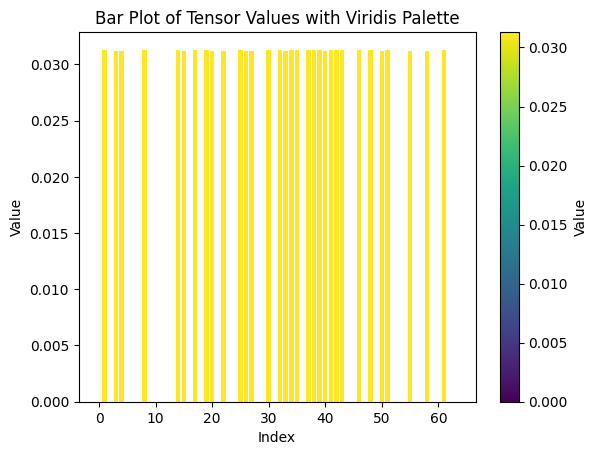

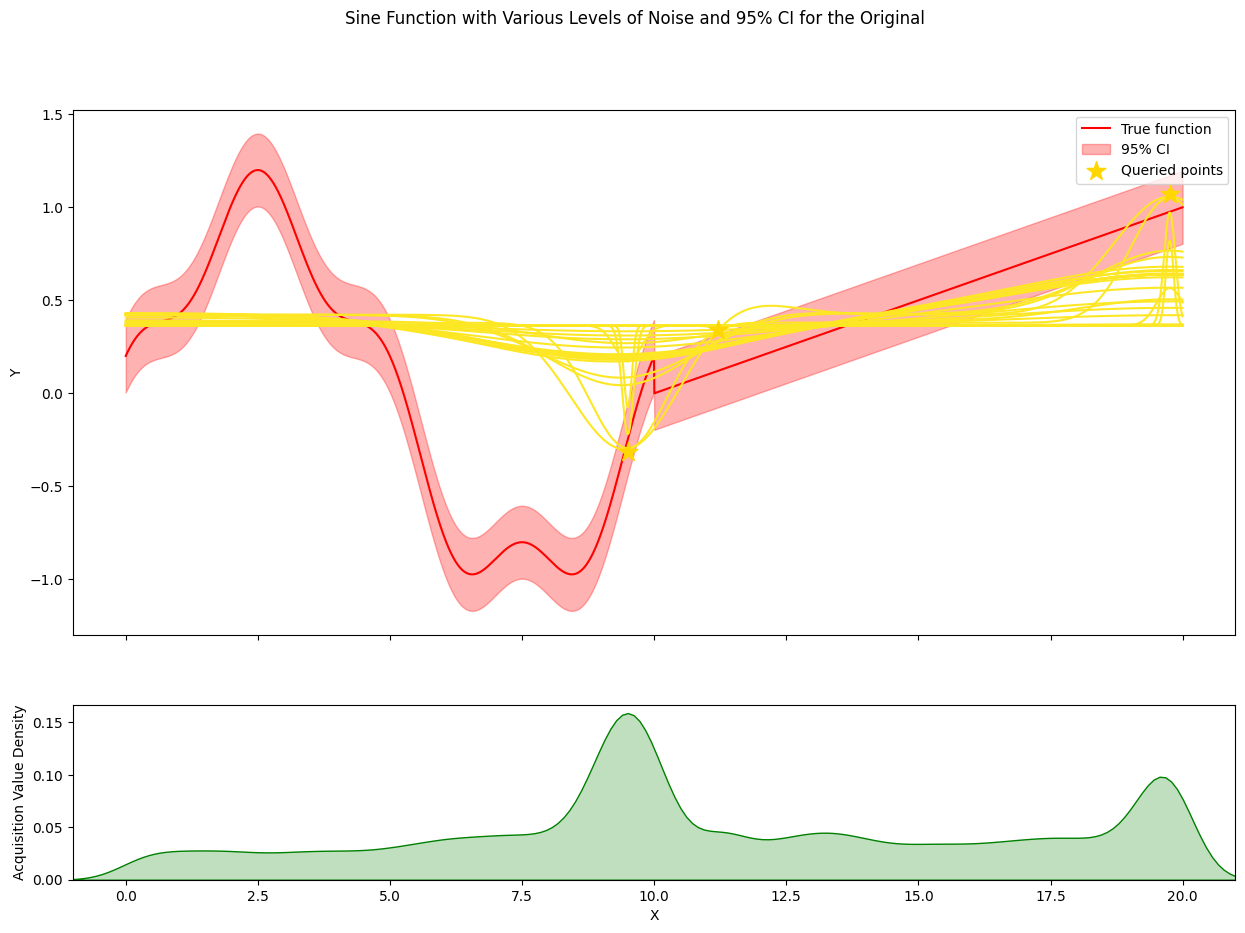

tensor([[0.0253],
        [0.0059],
        [0.0049],
        ...,
        [0.0057],
        [0.0072],
        [0.0306]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.4525], dtype=torch.float64), 'lengthscale': tensor([[0.1352]], dtype=torch.float64), 'outputscale': tensor([0.2265], dtype=torch.float64), 'mean': tensor([0.0844], dtype=torch.float64)}
64
{'noise': tensor([2.3252e-01, 2.7112e-01, 1.0070e-01, 7.2820e-01, 2.2419e+01, 1.8631e-01,
        1.5902e+01, 2.6535e+00, 2.3731e+00, 2.4612e-01, 5.2327e+01, 3.2377e-01,
        1.7666e-01, 1.7134e+00, 4.4391e-01, 7.8192e+00, 5.4884e+00, 1.4824e+00,
        7.2145e-02, 2.5762e-01, 6.8583e+00, 3.3937e-01, 8.1351e-01, 2.6366e+00,
        5.7111e-01, 6.2969e-02, 6.9055e-01, 2.1301e+02, 4.4078e-01, 4.9670e+00,
        9.2078e-02, 1.0424e+00, 3.6868e+00, 3.9077e-01, 6.2116e-02, 3.6630e-02,
        2.7474e-01, 2.1828e-01, 1.3369e-01, 1.1120e-01, 1.7030e+00, 1.6954e-04,
        9.9889e-01, 1.6343e+02, 2.1381e-01

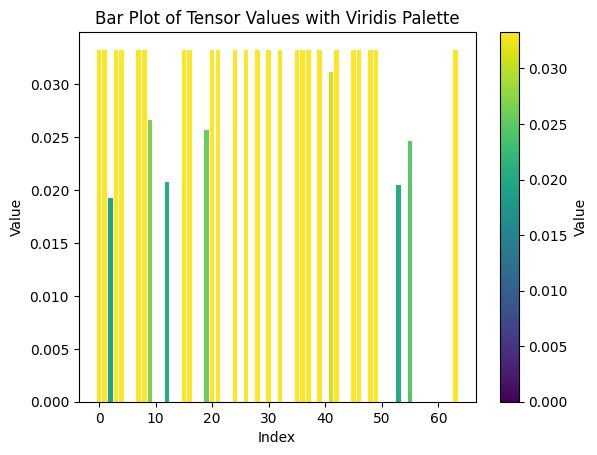

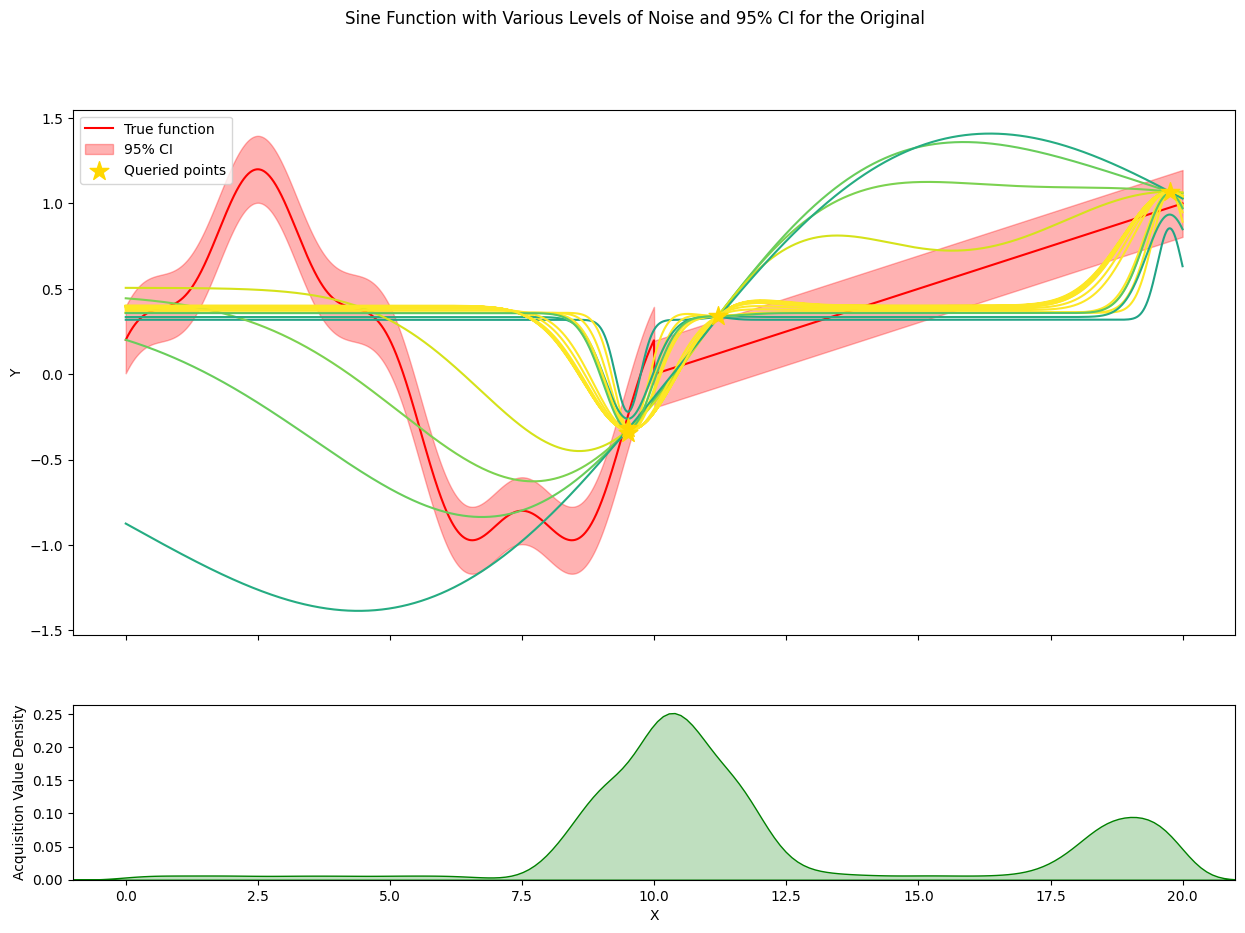

tensor([[6.2997e-06],
        [1.7268e-07],
        [1.7249e-07],
        ...,
        [1.7241e-07],
        [8.3893e-07],
        [2.7385e-06]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0011], dtype=torch.float64), 'lengthscale': tensor([[0.0441]], dtype=torch.float64), 'outputscale': tensor([0.7353], dtype=torch.float64), 'mean': tensor([0.3166], dtype=torch.float64)}
64
{'noise': tensor([7.3987e+02, 1.0258e-02, 2.9648e+02, 8.8987e-02, 4.7889e+00, 6.1941e-01,
        1.2426e+01, 1.2805e+01, 7.8586e-01, 7.0172e-02, 4.8298e-01, 7.7206e-02,
        2.1848e+02, 1.4960e-01, 1.3288e+00, 2.5365e-01, 7.9612e-02, 8.1192e-03,
        6.3712e-02, 5.4646e+01, 1.1236e-01, 9.6931e-01, 7.2858e-02, 3.1785e+00,
        1.3421e-01, 2.0079e+00, 7.7411e-01, 1.6629e+01, 4.1587e-01, 6.8503e-01,
        2.3991e+00, 4.7186e-01, 6.7023e-02, 3.7108e+01, 2.2287e-03, 1.1486e+01,
        1.0055e-01, 1.3862e+00, 2.3367e+01, 2.2297e+00, 5.9151e-02, 1.3362e-02,
        3.6487e-02

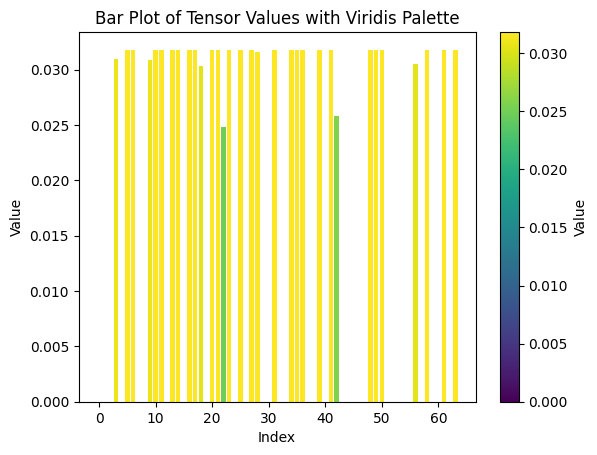

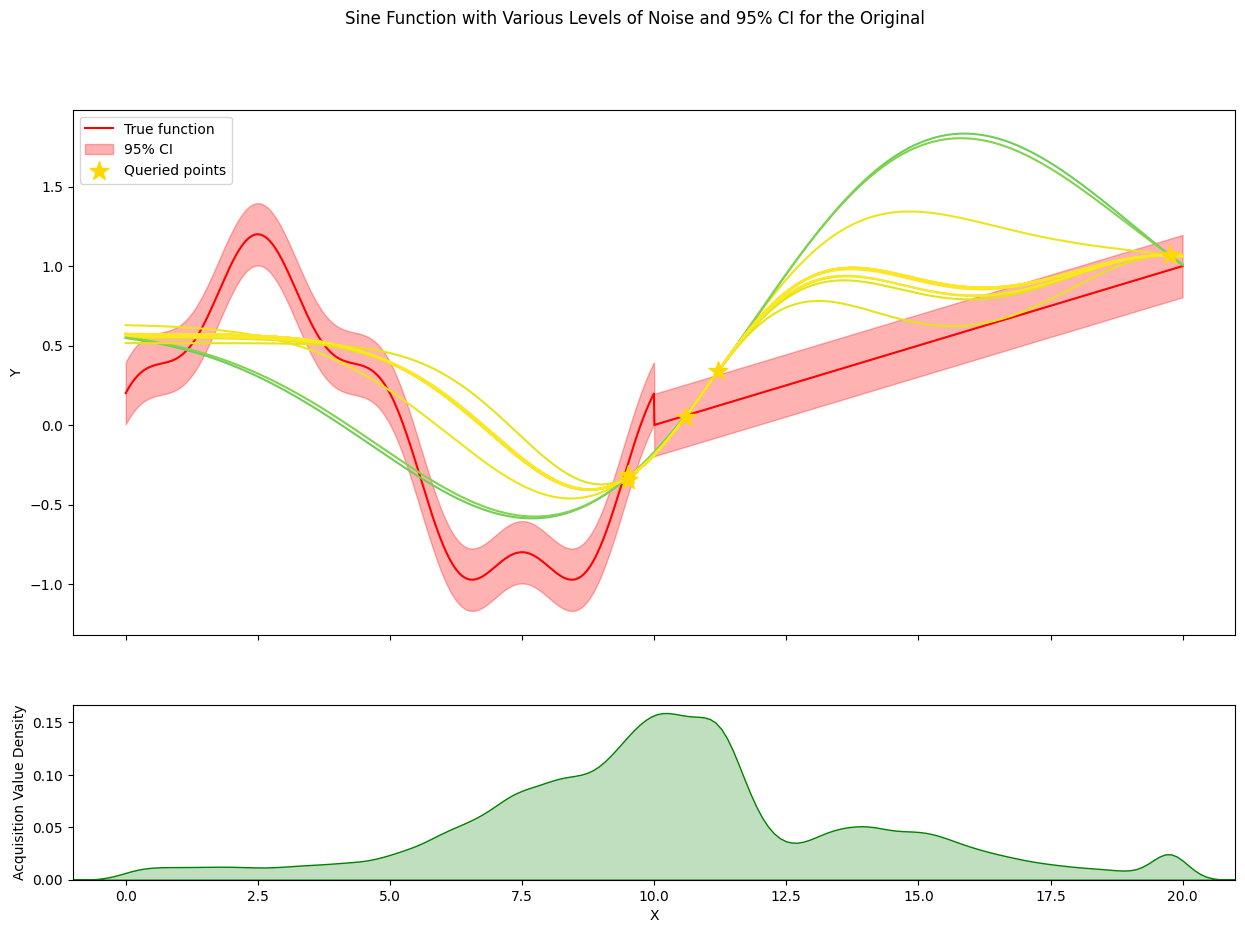

tensor([[7.8201e-11],
        [2.2262e-11],
        [6.6552e-12],
        ...,
        [1.3352e-11],
        [5.1212e-11],
        [8.6695e-13]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0013], dtype=torch.float64), 'lengthscale': tensor([[0.1168]], dtype=torch.float64), 'outputscale': tensor([1.2592], dtype=torch.float64), 'mean': tensor([0.7099], dtype=torch.float64)}
64
{'noise': tensor([1.0638e+00, 4.7302e+00, 3.9367e+01, 8.5833e-01, 3.9860e+00, 1.6161e+00,
        4.1964e-01, 1.1974e-02, 7.5411e-01, 2.3085e-04, 8.3346e-01, 1.1337e-02,
        2.9836e-01, 1.7366e+00, 6.5656e-02, 6.4809e-01, 3.4368e-03, 3.5860e-02,
        1.5036e+01, 1.7141e+02, 1.5086e-02, 1.5062e-01, 9.1343e+00, 6.4411e+02,
        1.0282e+01, 2.2721e-01, 2.2309e-02, 1.2404e+00, 1.2427e+00, 4.5935e-02,
        1.1497e-01, 4.6173e+00, 8.0458e+02, 1.0868e+01, 2.3803e-01, 2.2252e-01,
        2.4576e-01, 1.9324e-03, 3.9178e-02, 2.2594e+00, 3.0902e+00, 1.5270e-01,
        5.0129e-01

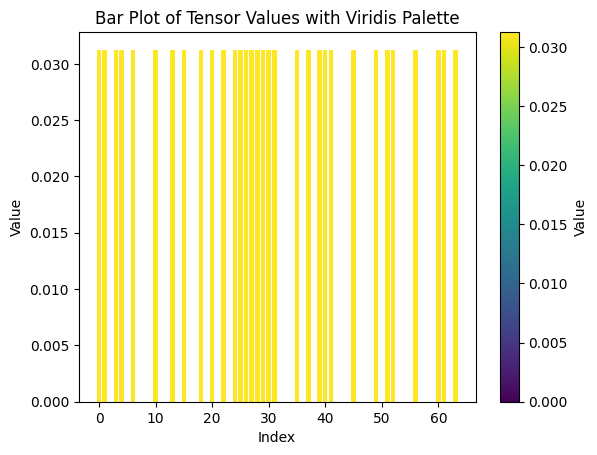

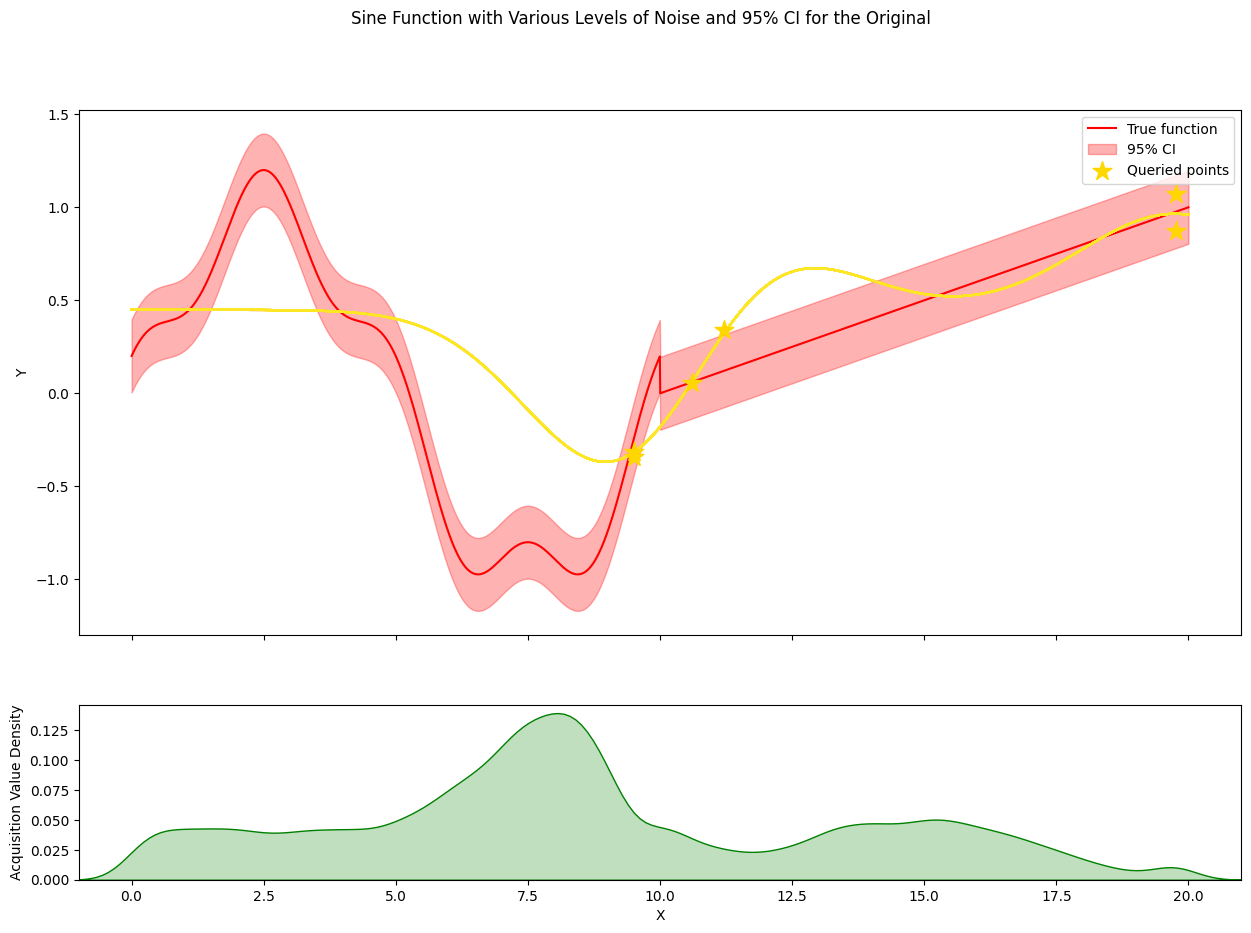

tensor([[1.7637e-13],
        [1.8811e-13],
        [1.6148e-13],
        ...,
        [1.9141e-13],
        [5.4666e-13],
        [5.3652e-14]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0214], dtype=torch.float64), 'lengthscale': tensor([[0.0908]], dtype=torch.float64), 'outputscale': tensor([0.9294], dtype=torch.float64), 'mean': tensor([0.2844], dtype=torch.float64)}
64
{'noise': tensor([4.7839e+01, 6.4008e+01, 5.6657e-01, 8.3528e+01, 1.0798e+01, 8.7805e+00,
        4.9512e-02, 1.3698e+01, 7.7859e+02, 1.6314e+01, 9.6091e-03, 1.0527e+01,
        5.2388e-01, 3.2891e+00, 6.1760e-01, 3.8557e+01, 6.4663e-03, 3.5362e-01,
        3.1045e+01, 5.7818e-02, 1.8949e+02, 2.4845e+00, 1.1469e+00, 1.3169e+01,
        4.2286e-02, 1.5722e+00, 4.1726e-02, 4.7241e-01, 6.0312e+00, 7.5097e+00,
        7.3695e-01, 5.9051e+00, 1.1864e+02, 2.5706e+01, 4.3934e+01, 4.1087e+00,
        2.0538e+01, 1.7770e+00, 3.5990e+00, 5.2817e-02, 1.4792e-01, 3.2324e+00,
        6.3539e+00

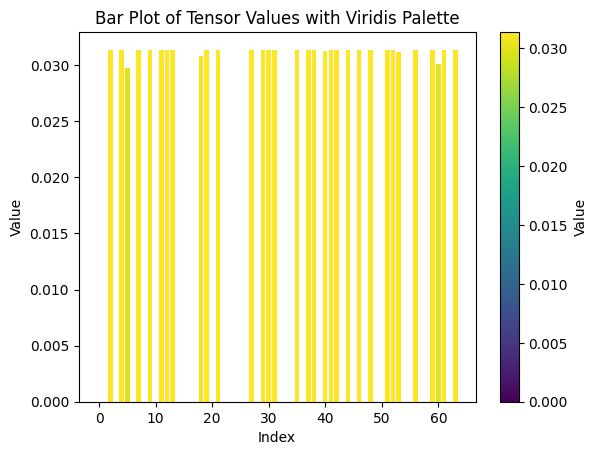

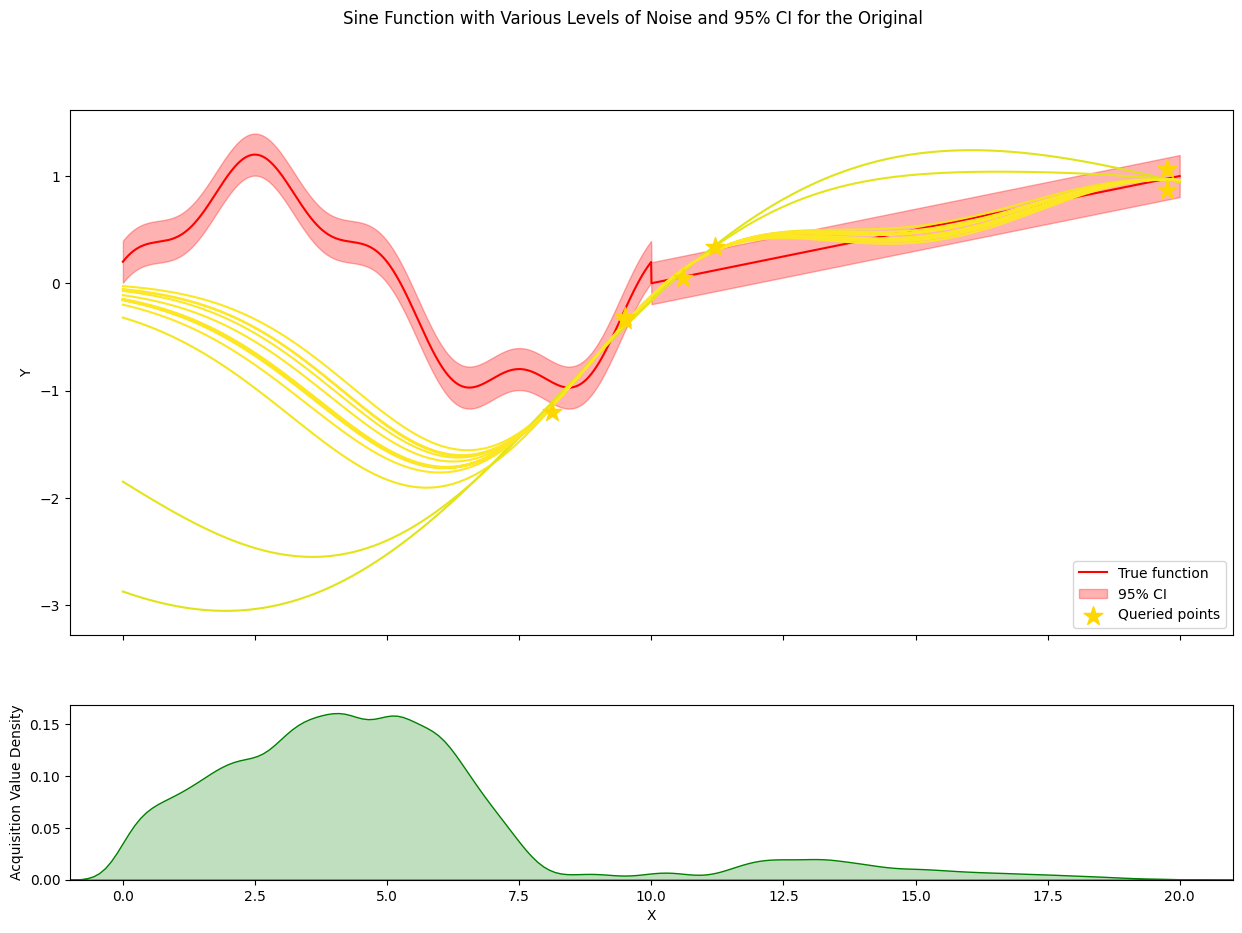

tensor([[3.7620e-10],
        [6.6150e-10],
        [7.4701e-09],
        ...,
        [1.1864e-08],
        [4.3660e-10],
        [5.1769e-11]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0173], dtype=torch.float64), 'lengthscale': tensor([[0.1497]], dtype=torch.float64), 'outputscale': tensor([2.0124], dtype=torch.float64), 'mean': tensor([-0.1395], dtype=torch.float64)}
64
{'noise': tensor([3.0415e+02, 1.6477e+00, 2.1337e+00, 6.1266e-02, 1.4910e-01, 3.3083e+01,
        3.5920e+02, 1.1414e-02, 2.8429e-02, 5.9999e-03, 9.3685e+00, 1.4827e+02,
        5.7595e-01, 2.1600e-03, 4.8837e-01, 8.2224e-01, 3.0343e-02, 1.4639e-01,
        7.2903e-01, 1.5307e-01, 5.1117e-01, 2.5532e-03, 9.9156e-02, 9.9757e+00,
        1.2358e+00, 1.1045e-01, 2.1949e-01, 3.4477e+00, 9.1120e-02, 1.0398e-02,
        7.3752e-01, 1.2353e+00, 3.1898e-01, 3.4822e+01, 2.9197e-02, 3.1368e+00,
        7.7511e+00, 4.5263e-02, 3.2606e+00, 5.7717e+00, 2.0315e+01, 7.1857e-01,
        2.1217e-0

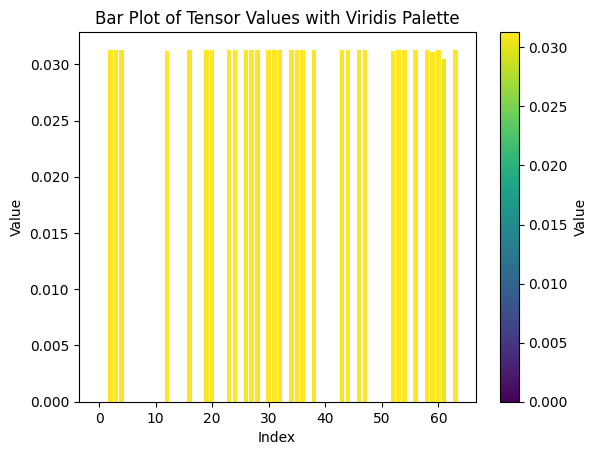

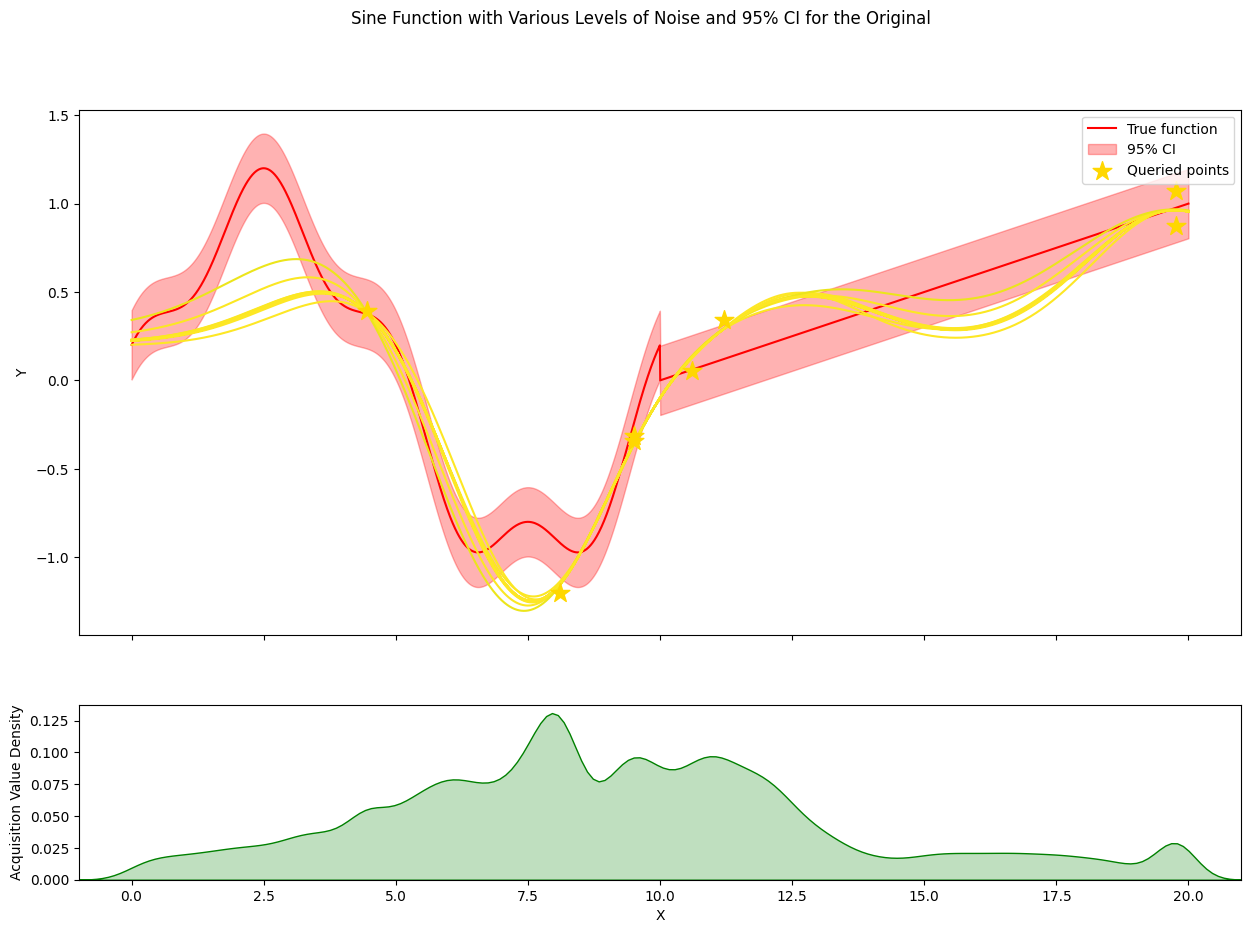

tensor([[4.9511e-12],
        [1.3574e-12],
        [1.5885e-12],
        ...,
        [3.7202e-12],
        [1.2290e-11],
        [1.5523e-12]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0219], dtype=torch.float64), 'lengthscale': tensor([[0.0845]], dtype=torch.float64), 'outputscale': tensor([1.1204], dtype=torch.float64), 'mean': tensor([0.1431], dtype=torch.float64)}
64
{'noise': tensor([2.4393e-01, 1.1789e+00, 1.7629e+00, 3.6540e+01, 1.4351e-01, 1.4241e-03,
        5.6705e+00, 3.5614e+01, 6.8081e-01, 1.0160e+00, 5.3438e-01, 6.0689e+01,
        2.8117e+00, 2.3451e+00, 1.5560e-01, 1.8959e+00, 4.9913e-02, 2.4492e-01,
        1.8112e+00, 4.7833e+00, 4.1033e+00, 1.9938e+00, 6.2854e-01, 6.9522e+00,
        1.2909e-01, 3.8812e+00, 1.3110e+00, 1.2630e-01, 3.7571e+02, 8.6836e-01,
        1.1118e+01, 6.5754e-03, 5.9194e-01, 5.9203e+00, 3.3314e-02, 2.7337e+01,
        2.4150e-01, 1.0111e-01, 4.7084e+02, 6.8523e-02, 2.6303e+01, 1.3031e-02,
        3.9281e+00

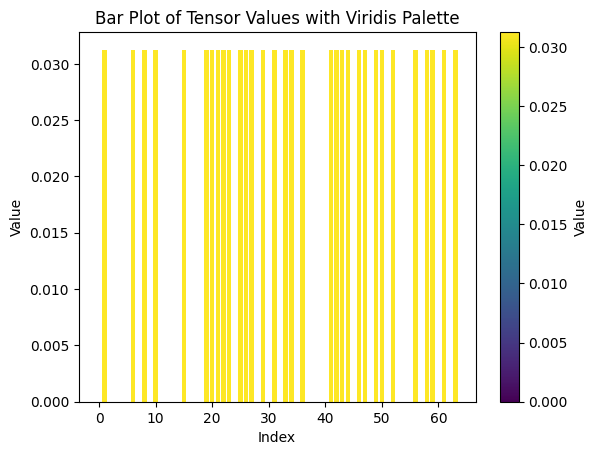

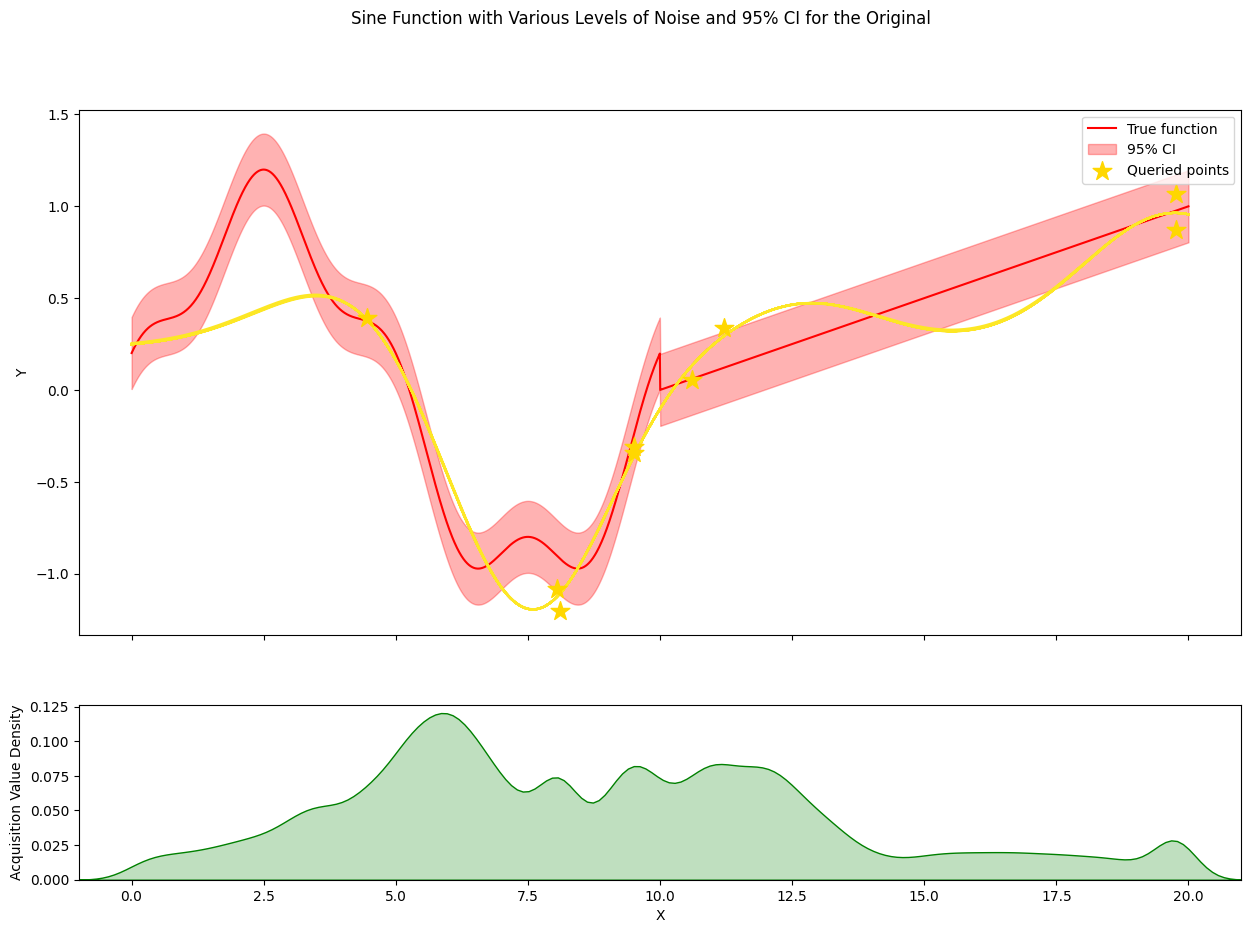

tensor([[1.2657e-12],
        [3.9482e-13],
        [5.2394e-13],
        ...,
        [2.0468e-12],
        [2.6038e-12],
        [5.7176e-13]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0173], dtype=torch.float64), 'lengthscale': tensor([[0.0878]], dtype=torch.float64), 'outputscale': tensor([0.9164], dtype=torch.float64), 'mean': tensor([0.3244], dtype=torch.float64)}
64
{'noise': tensor([4.8017e+01, 7.8319e-02, 6.5921e+01, 1.0480e+01, 1.2445e+01, 5.1396e-03,
        2.8199e+00, 3.5600e+00, 2.2434e-01, 6.4359e-02, 4.4036e+00, 1.9034e-02,
        9.0236e+02, 1.0404e-02, 1.0826e+00, 3.4619e-01, 2.4624e+00, 8.4076e+00,
        9.2730e+00, 8.0099e-01, 2.3152e-01, 5.9509e-01, 7.7481e-02, 1.5990e+01,
        2.2757e-02, 1.9614e+00, 9.4653e-02, 7.1594e+00, 1.0346e+01, 3.8862e+00,
        1.2950e+01, 3.9371e-03, 3.3592e+00, 2.8726e-01, 2.5777e-01, 1.0006e+00,
        4.3242e-02, 1.5661e+00, 5.2020e+00, 1.4139e-01, 8.4510e-01, 4.3621e-01,
        5.2962e+00

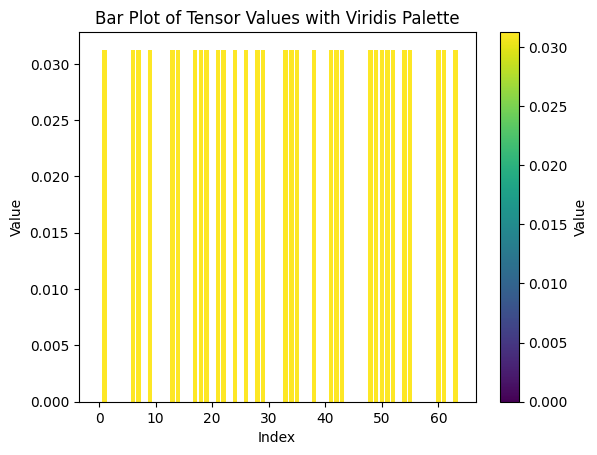

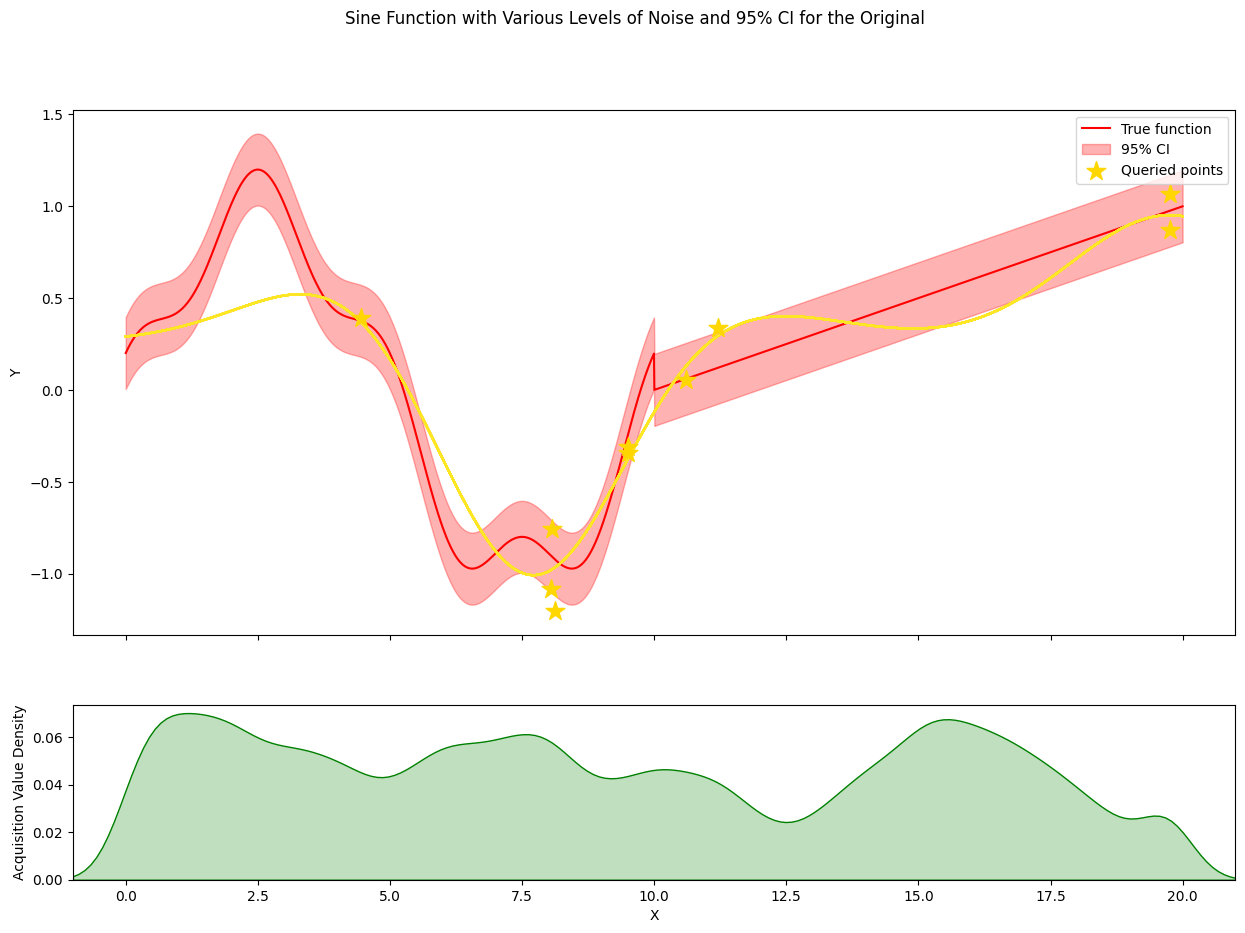

tensor([[3.8157e-13],
        [5.5674e-13],
        [5.5991e-13],
        ...,
        [3.2824e-13],
        [5.5805e-13],
        [3.4961e-13]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0454], dtype=torch.float64), 'lengthscale': tensor([[0.0956]], dtype=torch.float64), 'outputscale': tensor([0.8246], dtype=torch.float64), 'mean': tensor([0.4628], dtype=torch.float64)}
64
{'noise': tensor([2.1390e+01, 7.3441e-03, 6.1284e-01, 5.8879e-02, 1.1958e-02, 1.5585e-01,
        5.4728e-01, 9.3725e-02, 1.5144e+01, 2.9893e-01, 5.5482e+03, 8.1623e+00,
        4.4649e+01, 1.5581e-01, 2.4861e+00, 5.3900e-01, 6.2017e-01, 1.7822e+01,
        9.4739e-02, 9.7855e-03, 5.8916e+00, 1.6233e+01, 3.7168e+01, 1.4542e+04,
        7.1150e-01, 2.3232e+00, 1.1674e-01, 5.0347e-02, 4.4238e-02, 1.7921e+00,
        2.9580e+00, 1.2116e+00, 9.0776e-02, 4.1112e-02, 5.9236e-01, 9.1029e-01,
        2.3766e-01, 2.2031e+02, 2.3735e-01, 7.8324e+01, 2.6154e+01, 1.3823e-02,
        4.7243e-01

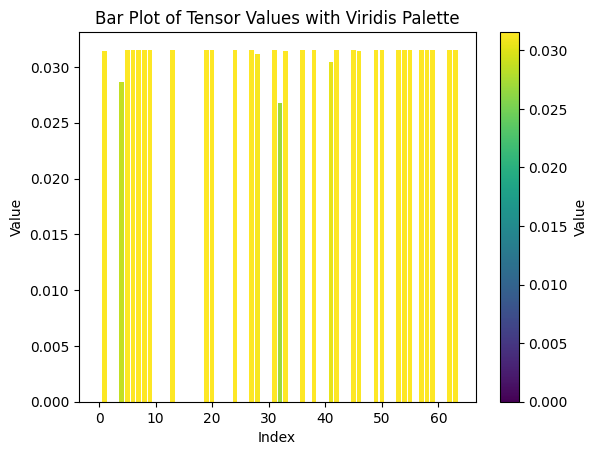

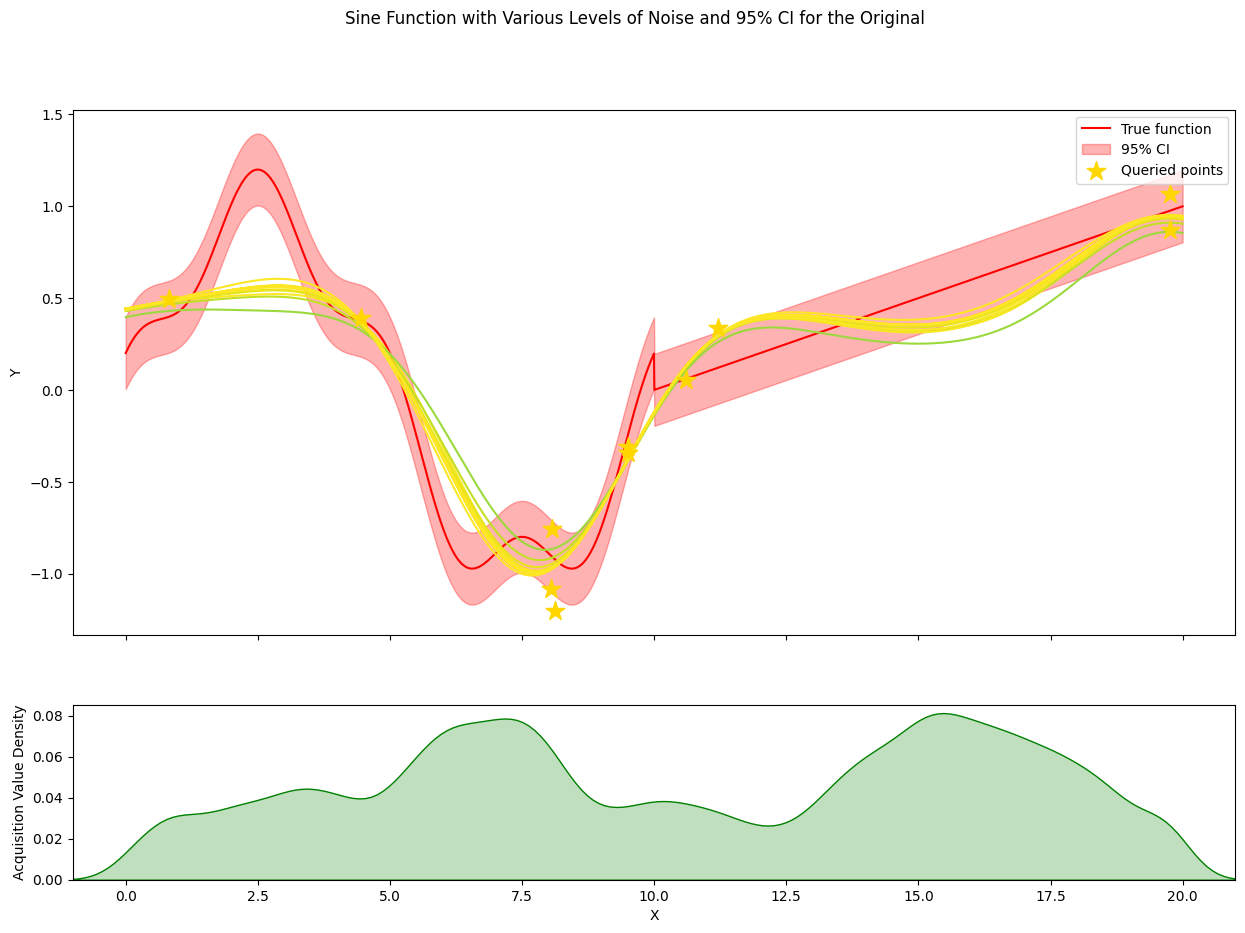

tensor([[2.3410e-12],
        [4.9977e-12],
        [2.0242e-12],
        ...,
        [2.7629e-12],
        [4.5523e-12],
        [2.3919e-12]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0471], dtype=torch.float64), 'lengthscale': tensor([[0.0943]], dtype=torch.float64), 'outputscale': tensor([0.7203], dtype=torch.float64), 'mean': tensor([0.4445], dtype=torch.float64)}
64
{'noise': tensor([1.6214e+01, 1.7344e+02, 3.5828e+00, 7.7449e+00, 2.2823e-01, 4.4890e-02,
        1.5928e-01, 8.1345e+01, 9.8531e-02, 6.4147e+00, 6.2142e+00, 2.2687e+00,
        6.2459e-01, 1.4522e+01, 4.2973e-01, 7.5768e-03, 5.2159e-01, 7.8275e-01,
        2.2191e+01, 1.3117e+02, 1.6670e+02, 1.9411e+00, 8.4989e+00, 1.7359e+00,
        2.6395e-01, 2.5419e-01, 2.3524e+01, 1.4938e-01, 2.9591e+00, 5.5127e+00,
        6.5629e+00, 7.6486e-02, 1.5360e-02, 1.6795e-01, 5.7978e-03, 1.5956e+00,
        3.6756e+00, 2.2573e-02, 1.3019e-01, 7.0241e-01, 5.0862e+00, 1.0630e+00,
        1.3724e-01

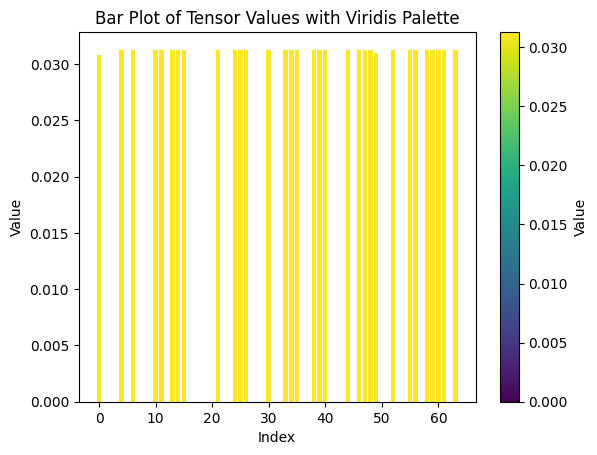

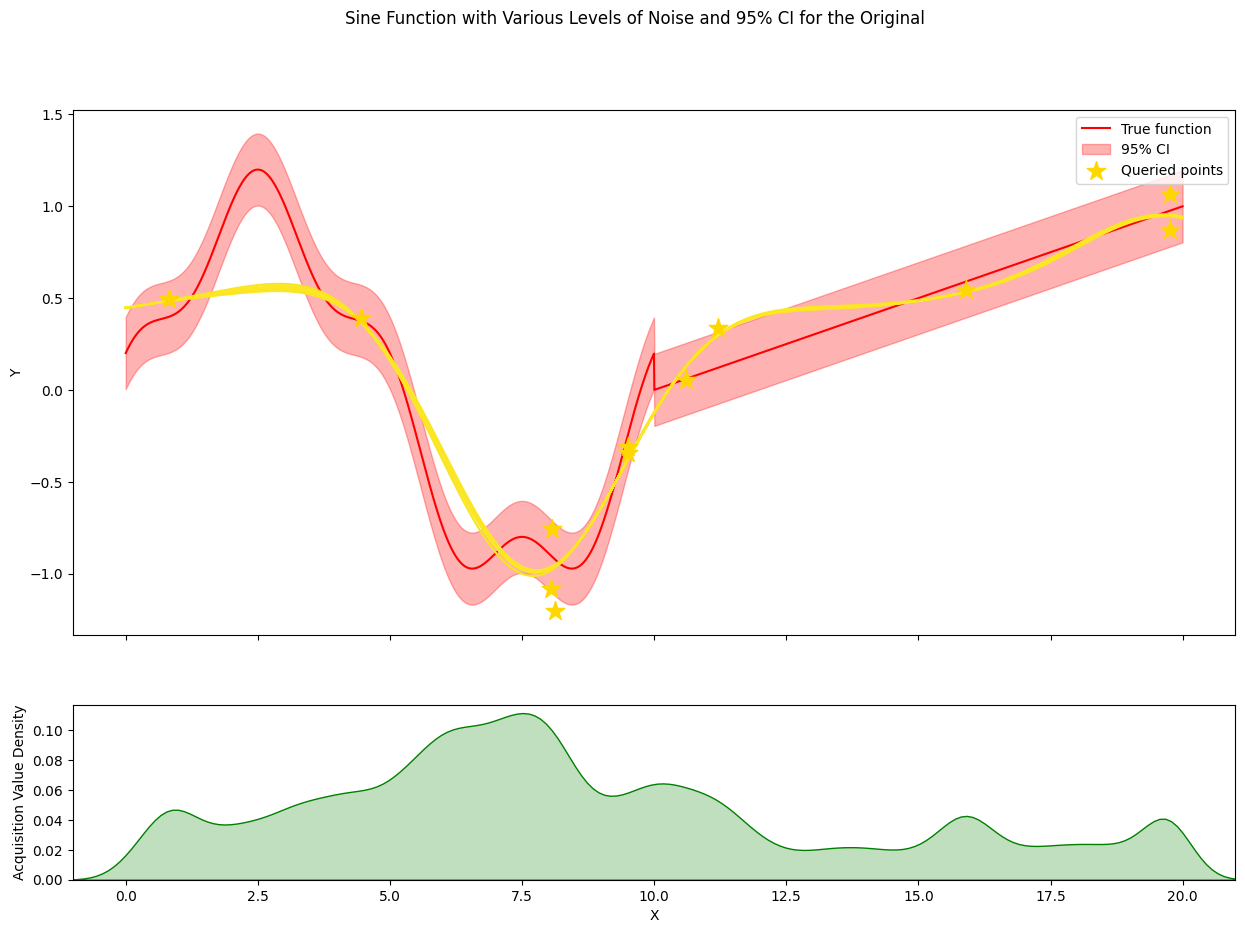

tensor([[1.2980e-11],
        [4.6133e-12],
        [6.5335e-12],
        ...,
        [1.2903e-11],
        [2.4255e-11],
        [1.3136e-11]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0486], dtype=torch.float64), 'lengthscale': tensor([[0.0935]], dtype=torch.float64), 'outputscale': tensor([0.6455], dtype=torch.float64), 'mean': tensor([0.4224], dtype=torch.float64)}
64
{'noise': tensor([2.8333e+00, 1.6612e+00, 1.6120e+02, 3.2739e-02, 8.7147e-03, 7.2697e-03,
        8.5063e-03, 2.0034e+01, 6.9027e+00, 6.1668e+00, 9.6710e-02, 7.4797e-01,
        6.2549e-01, 2.6999e+00, 1.6018e+03, 1.4874e+00, 2.3524e-02, 4.4713e-01,
        3.5602e-02, 1.0199e+00, 5.5091e-01, 1.8507e+01, 7.5721e+00, 1.0174e+01,
        1.1102e-02, 6.2854e-01, 1.6913e+00, 1.3995e+00, 4.0028e-04, 6.4786e+01,
        2.4102e-02, 5.8295e+00, 2.6351e-01, 5.9291e-02, 3.7157e-02, 9.5112e-01,
        1.9018e-02, 9.9061e-02, 2.1912e-02, 8.5883e-01, 5.0084e+00, 3.0428e-03,
        1.7172e-01

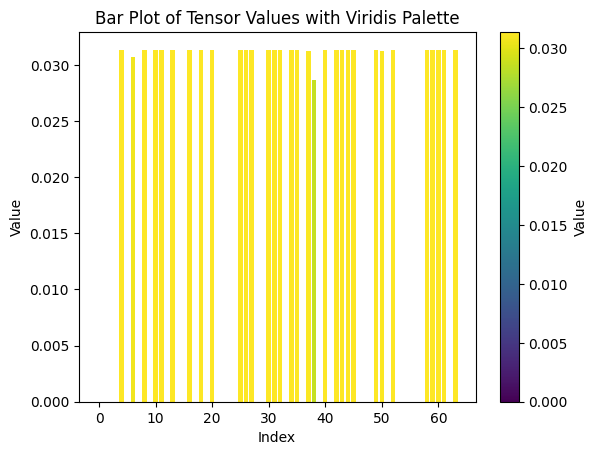

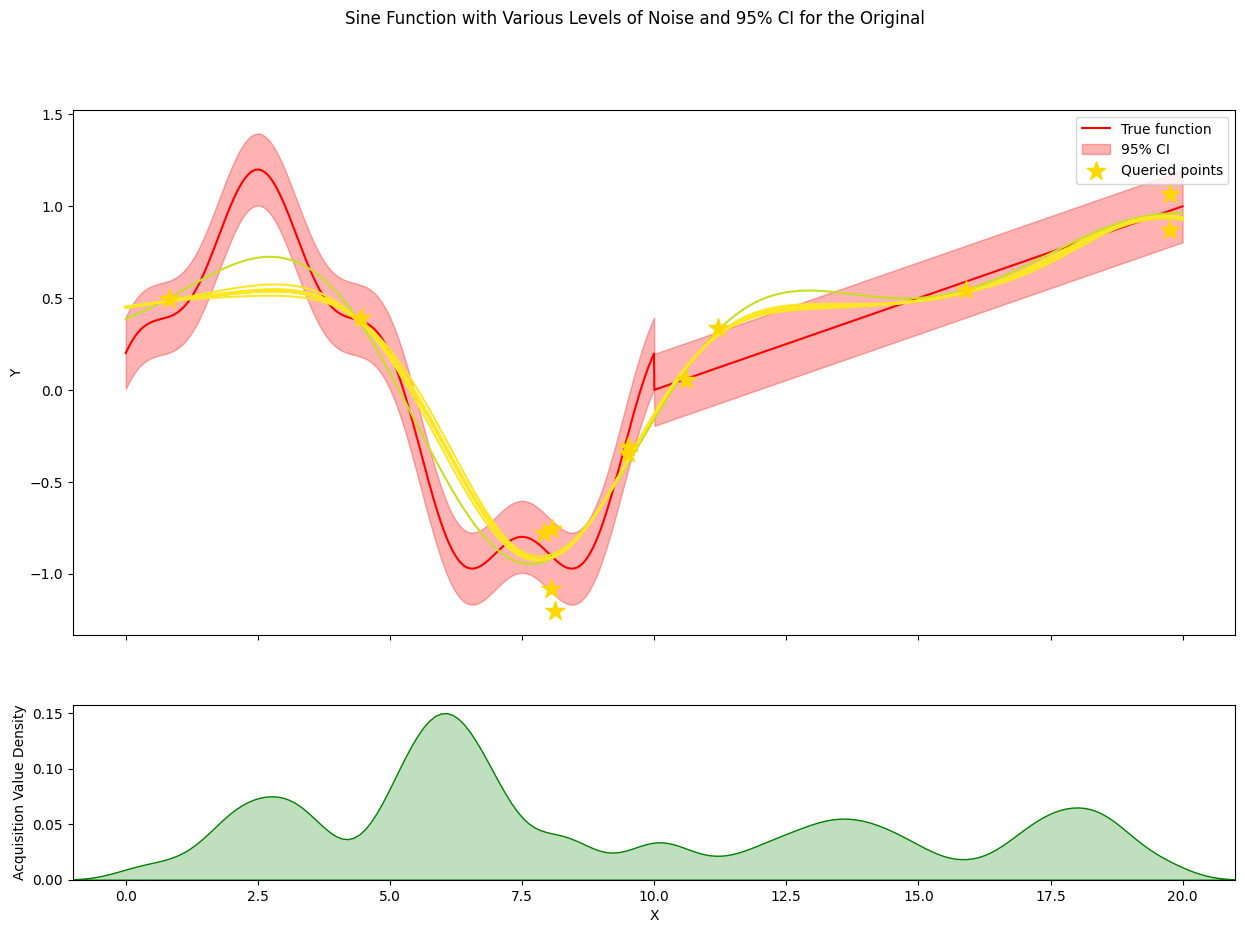

tensor([[2.0910e-12],
        [7.5183e-13],
        [2.7597e-12],
        ...,
        [4.4581e-12],
        [2.4010e-12],
        [9.6627e-13]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0531], dtype=torch.float64), 'lengthscale': tensor([[0.0942]], dtype=torch.float64), 'outputscale': tensor([0.5963], dtype=torch.float64), 'mean': tensor([0.5156], dtype=torch.float64)}
64
{'noise': tensor([1.9710e-01, 2.2523e+02, 1.7795e-02, 3.2022e+00, 1.9007e-01, 2.4711e-02,
        1.5740e+00, 4.1496e+01, 3.1548e+00, 2.1979e+00, 3.4072e-01, 5.9372e+01,
        8.9497e+00, 8.0523e+00, 4.7009e+00, 4.0583e+01, 2.0806e-02, 4.4306e-01,
        7.6229e-01, 2.6282e-01, 3.1598e-02, 3.6491e-01, 2.0106e+00, 5.0753e+01,
        3.1567e-01, 1.1209e+01, 2.5386e+00, 1.6673e+00, 7.8526e+02, 8.3383e-01,
        3.0303e-01, 8.6801e-01, 1.6829e-02, 5.6988e-01, 1.4980e+00, 1.8960e-01,
        6.5464e-03, 1.4088e-02, 1.1228e-01, 4.3017e-02, 5.1966e+00, 4.6119e-02,
        8.5853e-01

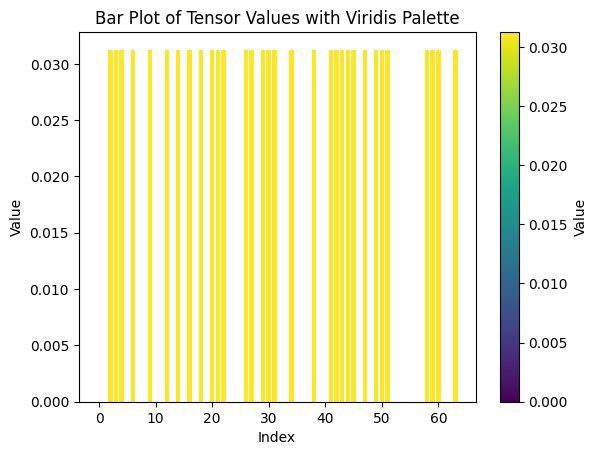

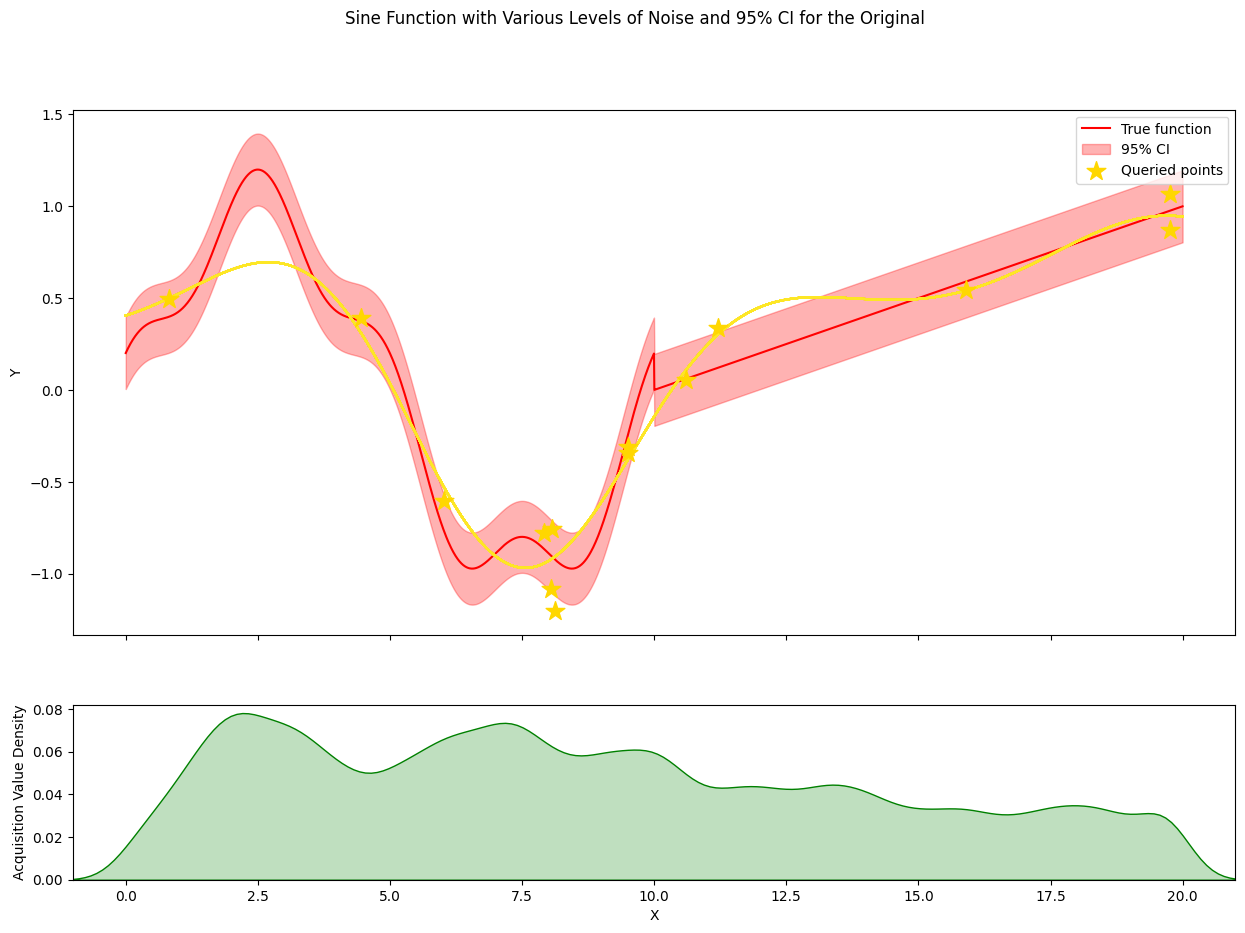

tensor([[6.5226e-14],
        [3.1301e-14],
        [8.1088e-14],
        ...,
        [5.7315e-14],
        [6.5545e-14],
        [4.4978e-14]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0525], dtype=torch.float64), 'lengthscale': tensor([[0.1140]], dtype=torch.float64), 'outputscale': tensor([0.7216], dtype=torch.float64), 'mean': tensor([0.5858], dtype=torch.float64)}
64
{'noise': tensor([2.0054e+02, 6.2677e+01, 4.4173e-03, 1.3057e+02, 1.9568e+01, 6.3346e-01,
        4.5266e+00, 7.1321e+01, 8.6188e-01, 8.9391e-01, 1.2866e-01, 1.0002e+01,
        6.7155e+01, 2.5180e-01, 1.1809e+00, 4.0473e+01, 1.7565e-01, 4.1444e-01,
        1.3073e-01, 1.0022e-02, 6.8597e+00, 4.0558e-01, 8.5823e+00, 3.1798e-01,
        9.4597e+00, 1.8210e-02, 1.9399e+01, 7.5339e-02, 2.0566e+00, 3.2379e+02,
        9.8481e+00, 1.8896e-02, 2.3638e-01, 2.1615e+02, 5.9610e-02, 2.6138e-03,
        8.2684e-01, 2.8797e+00, 3.9972e-01, 4.5013e-02, 7.6639e-01, 4.6721e-01,
        3.2612e+01

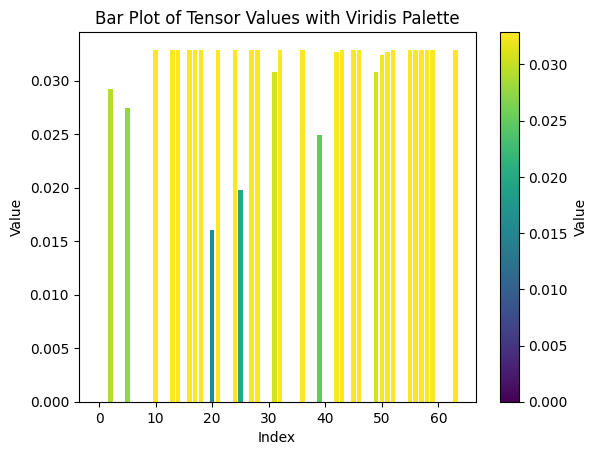

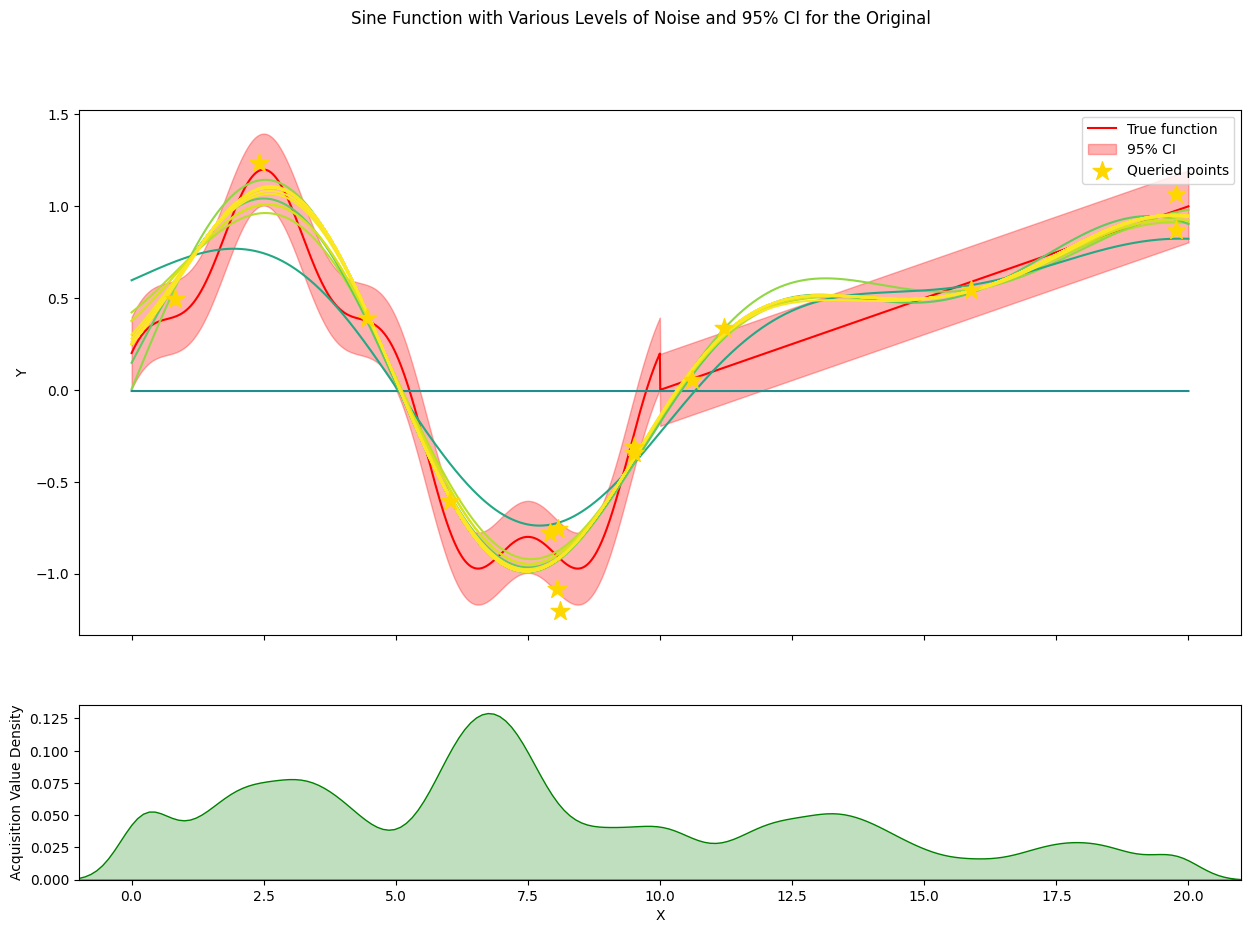

tensor([[3.1228e-12],
        [9.8953e-13],
        [4.7233e-12],
        ...,
        [2.1439e-12],
        [3.7622e-12],
        [1.8733e-12]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0469], dtype=torch.float64), 'lengthscale': tensor([[0.1143]], dtype=torch.float64), 'outputscale': tensor([0.7993], dtype=torch.float64), 'mean': tensor([0.4296], dtype=torch.float64)}
64
{'noise': tensor([6.3778e+00, 7.2954e+01, 1.6229e-04, 1.5265e+00, 4.8885e-01, 8.3765e-02,
        8.5101e+01, 8.0351e-01, 1.0384e+00, 1.8098e+00, 5.7323e-03, 1.0683e-03,
        1.9166e-01, 6.5894e-02, 8.1524e-01, 1.8029e-02, 9.6504e-02, 3.2067e-02,
        2.3993e+00, 6.2579e-02, 1.3981e+02, 2.3081e-02, 7.7442e-02, 1.1848e+00,
        1.7201e-03, 6.2190e-01, 1.4591e+01, 1.5270e-01, 6.9993e-02, 5.9825e-03,
        3.9189e+02, 2.4638e-01, 1.3852e+00, 1.9235e-02, 6.7601e-01, 1.9640e+00,
        2.8786e-01, 1.2452e-01, 2.0589e-02, 5.0664e+02, 3.2662e-02, 4.0569e+01,
        1.3314e+00

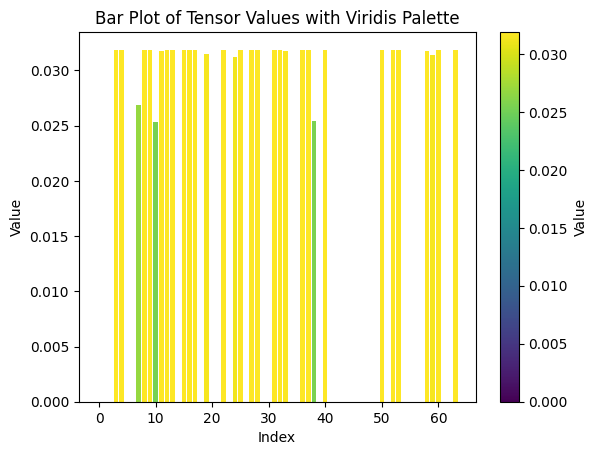

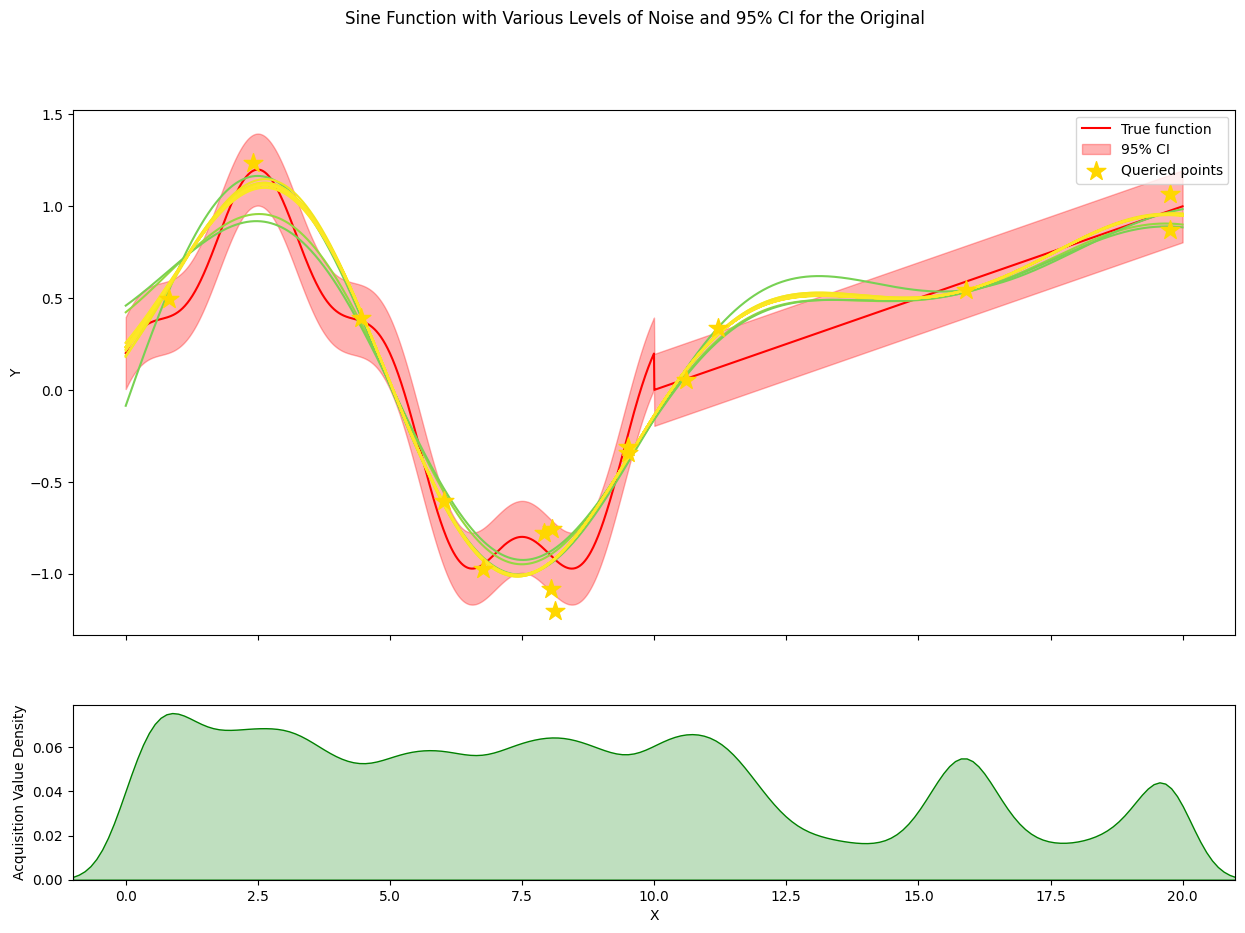

tensor([[7.7014e-11],
        [5.6233e-11],
        [8.5724e-11],
        ...,
        [8.1382e-11],
        [9.2135e-11],
        [9.7797e-11]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0404], dtype=torch.float64), 'lengthscale': tensor([[0.1168]], dtype=torch.float64), 'outputscale': tensor([0.8175], dtype=torch.float64), 'mean': tensor([0.4918], dtype=torch.float64)}
64
{'noise': tensor([6.8252e-03, 1.7550e+01, 1.5997e-01, 2.7803e-02, 3.7179e+00, 5.8818e+00,
        4.1937e-01, 1.7053e+00, 9.2238e+01, 2.0576e+00, 8.4002e-02, 2.5051e-01,
        2.8832e+01, 6.6503e-04, 7.7588e+00, 3.9918e-02, 2.6018e-01, 2.5658e-01,
        1.0694e+02, 3.1447e+00, 3.5780e-01, 9.7475e+01, 2.6515e-02, 3.5090e-01,
        8.5698e-01, 7.8543e+00, 1.2568e-01, 2.6669e+00, 2.2707e+00, 3.1151e-01,
        1.6798e-01, 8.3093e-01, 5.3038e+01, 8.6278e-02, 4.3993e-02, 1.0491e+00,
        1.2537e+02, 9.8635e-03, 3.9249e+00, 1.6829e-03, 1.2213e-01, 5.8433e-03,
        3.4326e+00

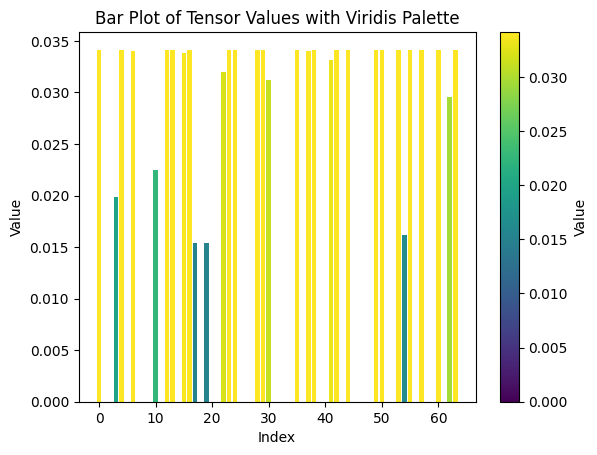

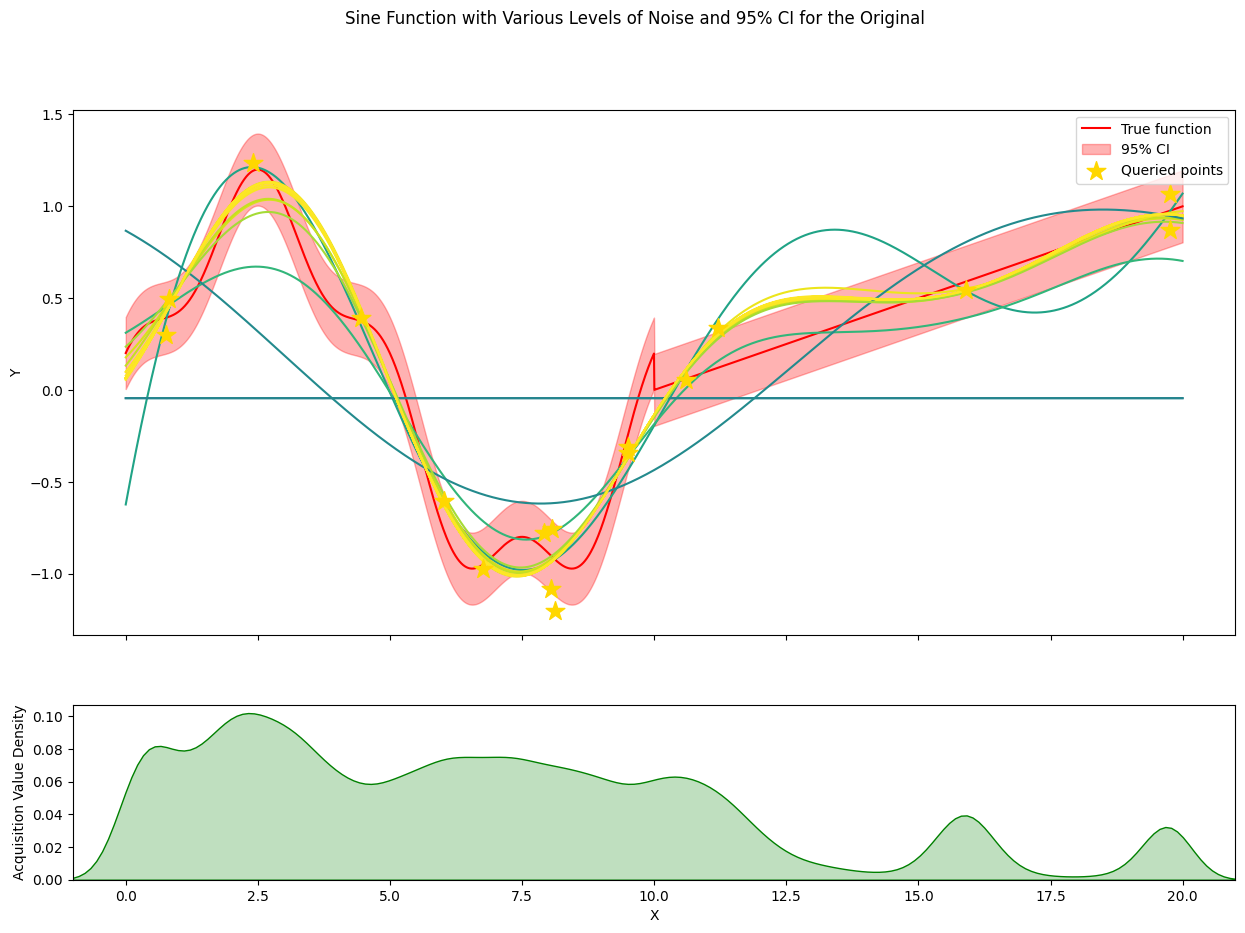

tensor([[2.4244e-10],
        [8.6241e-11],
        [3.9750e-10],
        ...,
        [2.6806e-10],
        [2.9789e-10],
        [2.3833e-10]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0407], dtype=torch.float64), 'lengthscale': tensor([[0.1129]], dtype=torch.float64), 'outputscale': tensor([0.8822], dtype=torch.float64), 'mean': tensor([0.4392], dtype=torch.float64)}
64
{'noise': tensor([1.7507e+00, 8.6879e+01, 1.7984e-01, 1.5813e+00, 1.7975e+03, 6.3237e-02,
        8.6640e+00, 5.1695e-01, 1.5856e-02, 1.9952e+02, 1.2266e+03, 1.3733e+02,
        1.0734e-01, 6.0273e-02, 2.9892e-02, 6.1285e+00, 1.1840e+00, 2.4507e-02,
        1.0232e-01, 1.7124e-01, 1.4468e+00, 3.9710e-03, 3.9728e-02, 2.2243e+01,
        3.1590e+00, 4.8301e+00, 2.4606e-02, 8.1252e-01, 2.6429e+00, 4.5014e+01,
        9.5835e+00, 1.0025e-01, 8.3589e-01, 2.2428e+00, 8.1885e-01, 8.1129e-01,
        1.8934e-01, 1.2739e+01, 7.1071e+00, 1.3136e+01, 8.4591e-04, 2.7204e-02,
        1.6804e-02

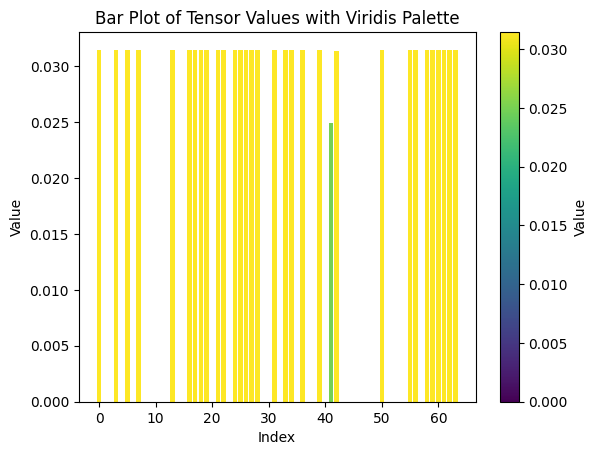

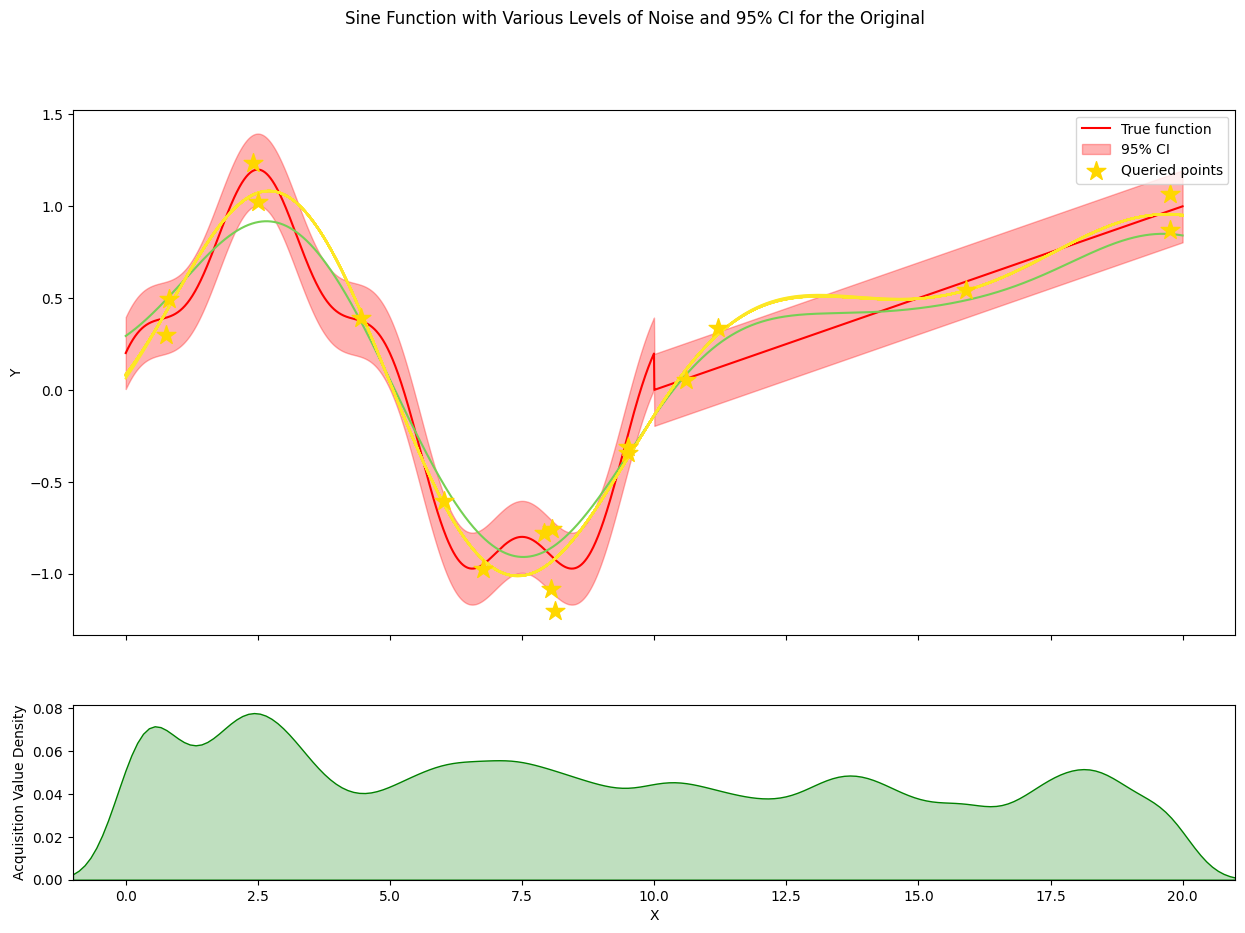

tensor([[8.6986e-14],
        [5.6816e-14],
        [1.3202e-13],
        ...,
        [9.2523e-14],
        [1.0639e-13],
        [8.7624e-14]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0375], dtype=torch.float64), 'lengthscale': tensor([[0.1162]], dtype=torch.float64), 'outputscale': tensor([0.8325], dtype=torch.float64), 'mean': tensor([0.3526], dtype=torch.float64)}
64
{'noise': tensor([2.3041e-02, 1.4152e+01, 1.0103e-02, 1.1238e+02, 1.4307e+01, 2.3267e+00,
        1.0565e+01, 1.8440e+01, 9.0606e+00, 8.3745e-01, 4.5122e+02, 3.1135e+02,
        5.8866e-04, 8.2389e-02, 1.7906e+01, 8.7207e-01, 3.6119e+00, 1.8274e-01,
        5.1837e+01, 3.7539e-02, 1.2471e+00, 1.4353e+00, 2.6834e+02, 1.7666e+02,
        7.7625e+01, 4.8758e-02, 2.5393e-02, 4.6744e+01, 1.8643e-01, 1.9405e-02,
        3.8184e+01, 5.0015e-01, 3.2961e+01, 4.6651e-02, 3.4654e-02, 1.8321e-03,
        3.8754e+00, 2.2599e+02, 6.7716e-01, 4.2623e+01, 2.7311e-01, 3.8983e-01,
        1.2211e-01

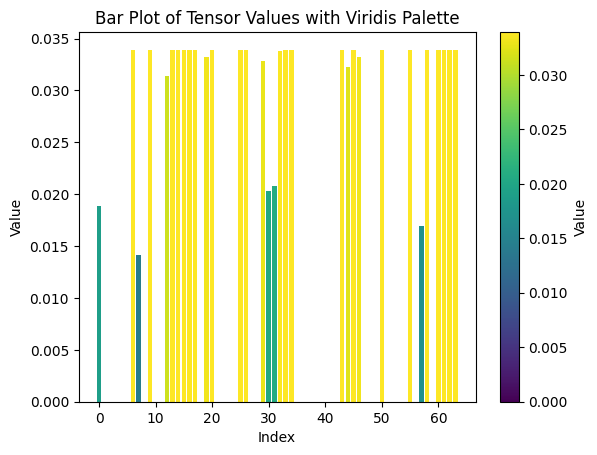

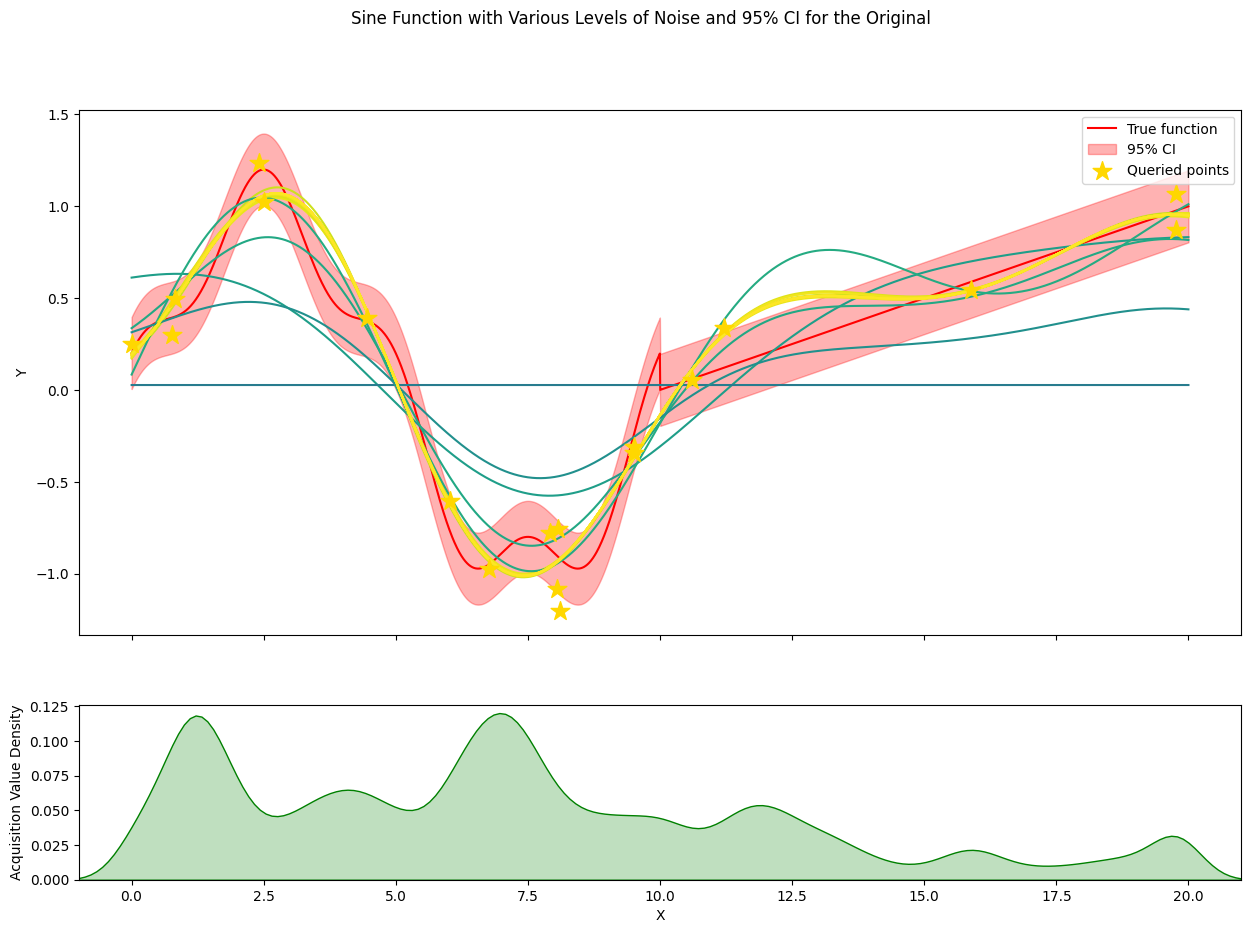

tensor([[6.0391e-12],
        [1.7182e-12],
        [1.1195e-11],
        ...,
        [6.4445e-12],
        [7.8571e-12],
        [4.9680e-12]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0397], dtype=torch.float64), 'lengthscale': tensor([[0.1141]], dtype=torch.float64), 'outputscale': tensor([0.7859], dtype=torch.float64), 'mean': tensor([0.3937], dtype=torch.float64)}
64
{'noise': tensor([1.1248e+00, 4.8664e-03, 1.0234e+01, 1.5462e+01, 1.6907e+00, 3.1013e-01,
        5.0379e-02, 6.2040e-02, 4.2886e-02, 1.7542e-01, 8.0395e-02, 6.4938e-01,
        2.4227e-02, 8.1565e-01, 1.6531e-01, 5.9927e-02, 2.0091e-02, 1.1163e-01,
        4.5218e+00, 9.2884e+00, 2.3056e+02, 1.2515e-01, 6.9587e-01, 1.9766e-01,
        6.5483e-03, 1.2575e+01, 1.5013e+00, 1.3522e+01, 2.1533e-02, 1.1174e+01,
        5.1667e-01, 2.5955e-01, 1.4156e+00, 2.4311e+00, 6.6138e+01, 6.3901e-02,
        4.4401e-02, 9.3515e-01, 3.5098e-02, 6.2964e-01, 3.0294e+00, 4.7225e+01,
        1.3219e+01

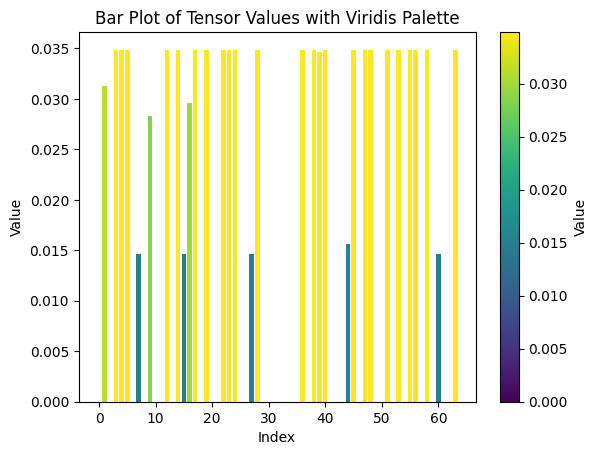

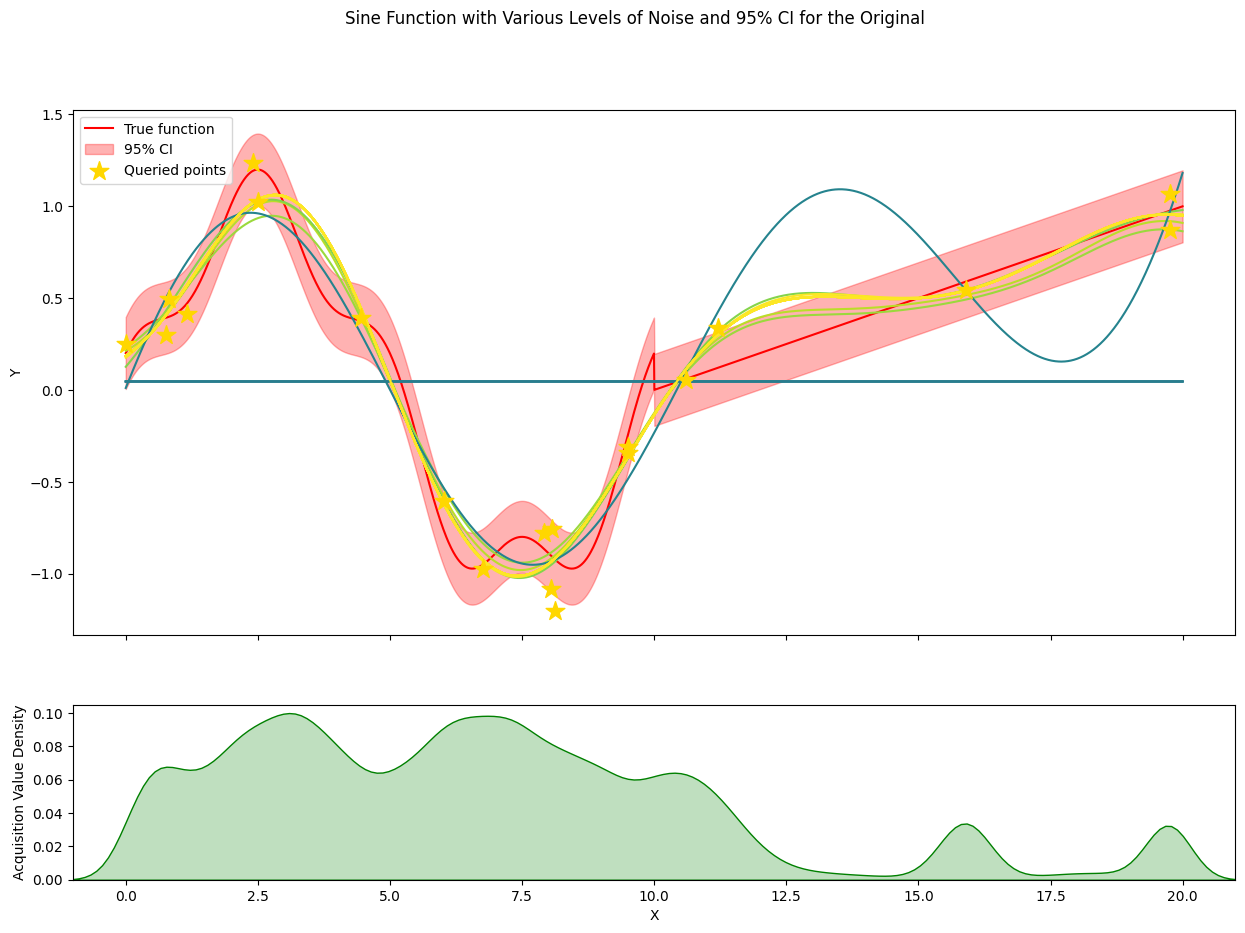

tensor([[1.1277e-10],
        [2.1923e-11],
        [1.3865e-10],
        ...,
        [1.2788e-10],
        [1.6013e-10],
        [1.0930e-10]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0422], dtype=torch.float64), 'lengthscale': tensor([[0.1084]], dtype=torch.float64), 'outputscale': tensor([0.7761], dtype=torch.float64), 'mean': tensor([0.3880], dtype=torch.float64)}
64
{'noise': tensor([3.0103e-01, 1.8989e+00, 1.8025e+01, 1.9811e-01, 1.0687e-02, 1.8634e-01,
        1.6118e-01, 6.9335e-01, 5.7345e-01, 1.6396e-02, 3.2395e-01, 9.0665e+01,
        7.6665e-01, 4.3464e+00, 3.9767e-01, 7.7839e+00, 2.6853e+00, 9.1055e-01,
        9.5867e-01, 1.2008e+00, 1.9577e-01, 1.3711e+00, 4.9647e-02, 1.0017e+02,
        1.1773e-01, 2.1301e+00, 1.1869e+01, 1.5025e+02, 2.0388e-01, 2.8420e-01,
        3.7826e-01, 1.2183e-01, 3.1191e-01, 3.8928e-01, 3.4723e-01, 5.3692e+00,
        1.8101e-01, 7.8918e+00, 2.3538e-02, 4.6229e-02, 2.9349e-01, 5.8391e+02,
        3.1235e-04

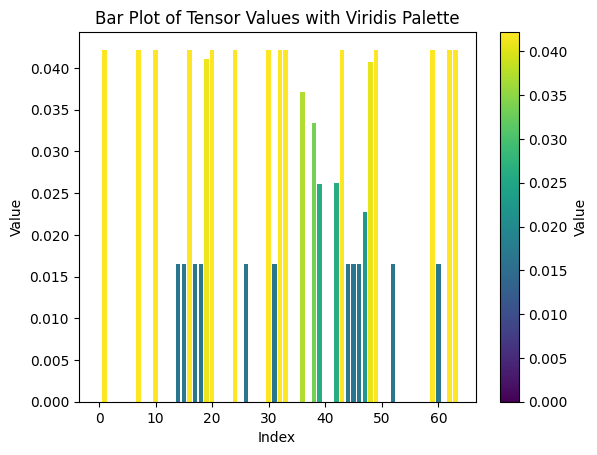

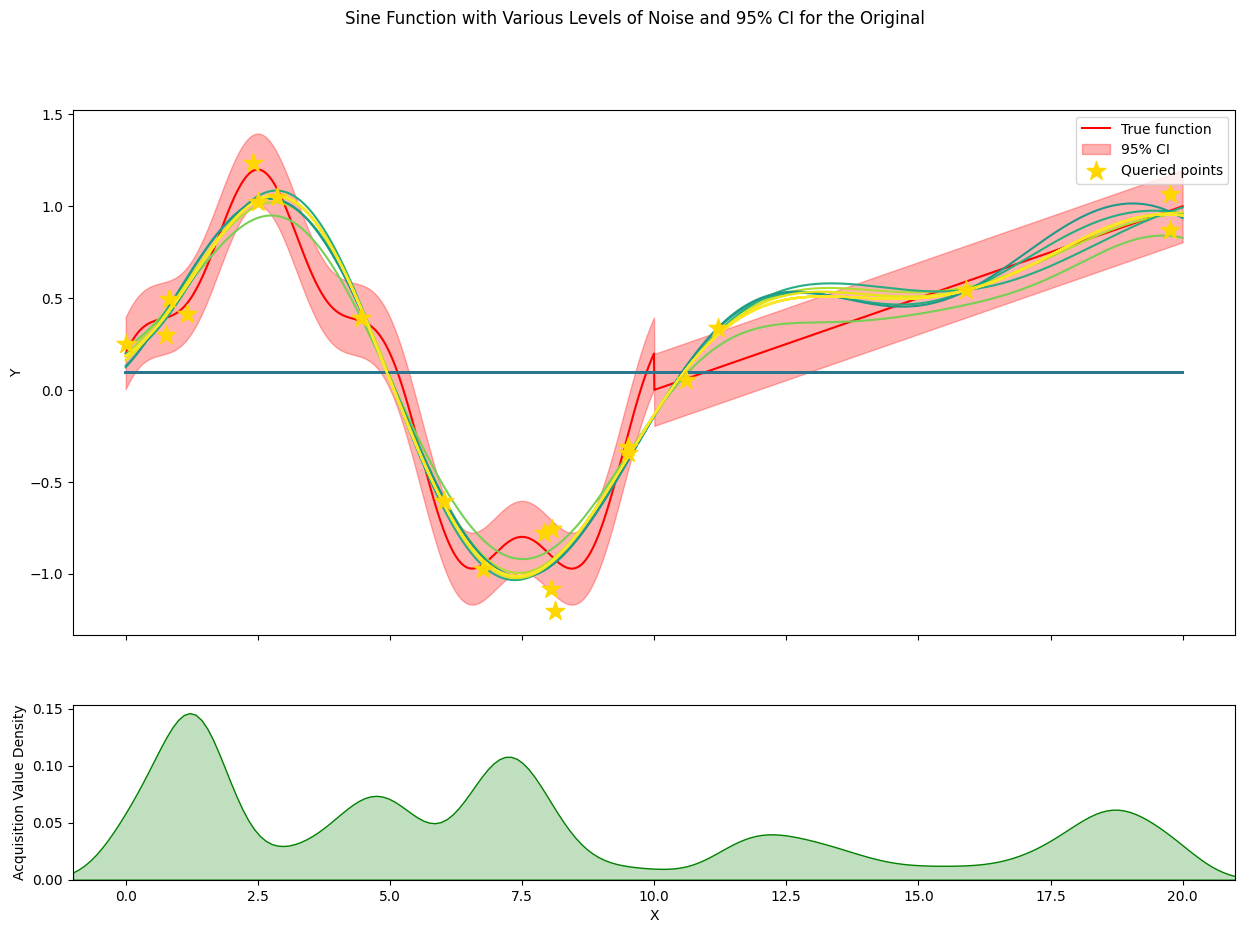

tensor([[2.2254e-05],
        [2.2739e-05],
        [2.0869e-04],
        ...,
        [1.8544e-04],
        [1.2322e-04],
        [3.8513e-05]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0379], dtype=torch.float64), 'lengthscale': tensor([[0.1092]], dtype=torch.float64), 'outputscale': tensor([0.7518], dtype=torch.float64), 'mean': tensor([0.3210], dtype=torch.float64)}
64
{'noise': tensor([4.4639e-02, 3.9946e+01, 1.0977e+00, 1.9744e-01, 1.2272e+01, 6.2009e-02,
        9.3220e+01, 4.9775e-02, 6.1674e-03, 6.6982e-01, 1.1723e-02, 1.8547e-02,
        8.8772e-01, 3.8203e+00, 4.2241e+00, 3.8506e-01, 8.3073e+00, 3.1609e-01,
        2.5921e-01, 1.0330e+00, 5.6153e-03, 1.1809e+00, 2.8323e-03, 3.1464e-02,
        7.1569e-02, 1.3306e+01, 1.4385e-01, 1.0982e+01, 1.2068e-01, 1.2126e-01,
        7.3189e+00, 1.5444e-01, 3.3046e-01, 5.1953e+02, 1.3523e-01, 1.1369e+00,
        8.0325e-01, 1.8492e+00, 1.0108e-01, 1.8019e+00, 4.9662e-01, 1.1277e+02,
        7.6665e-01

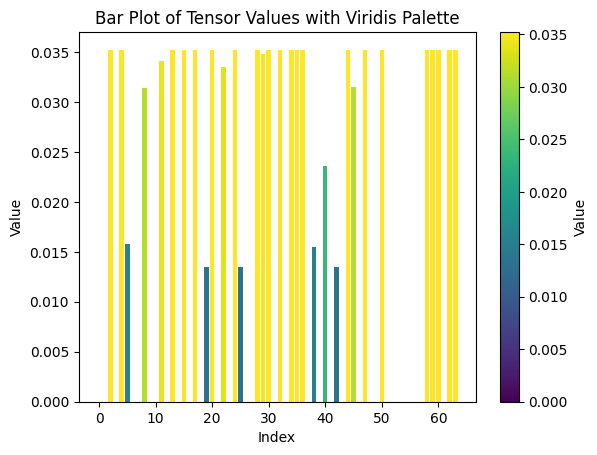

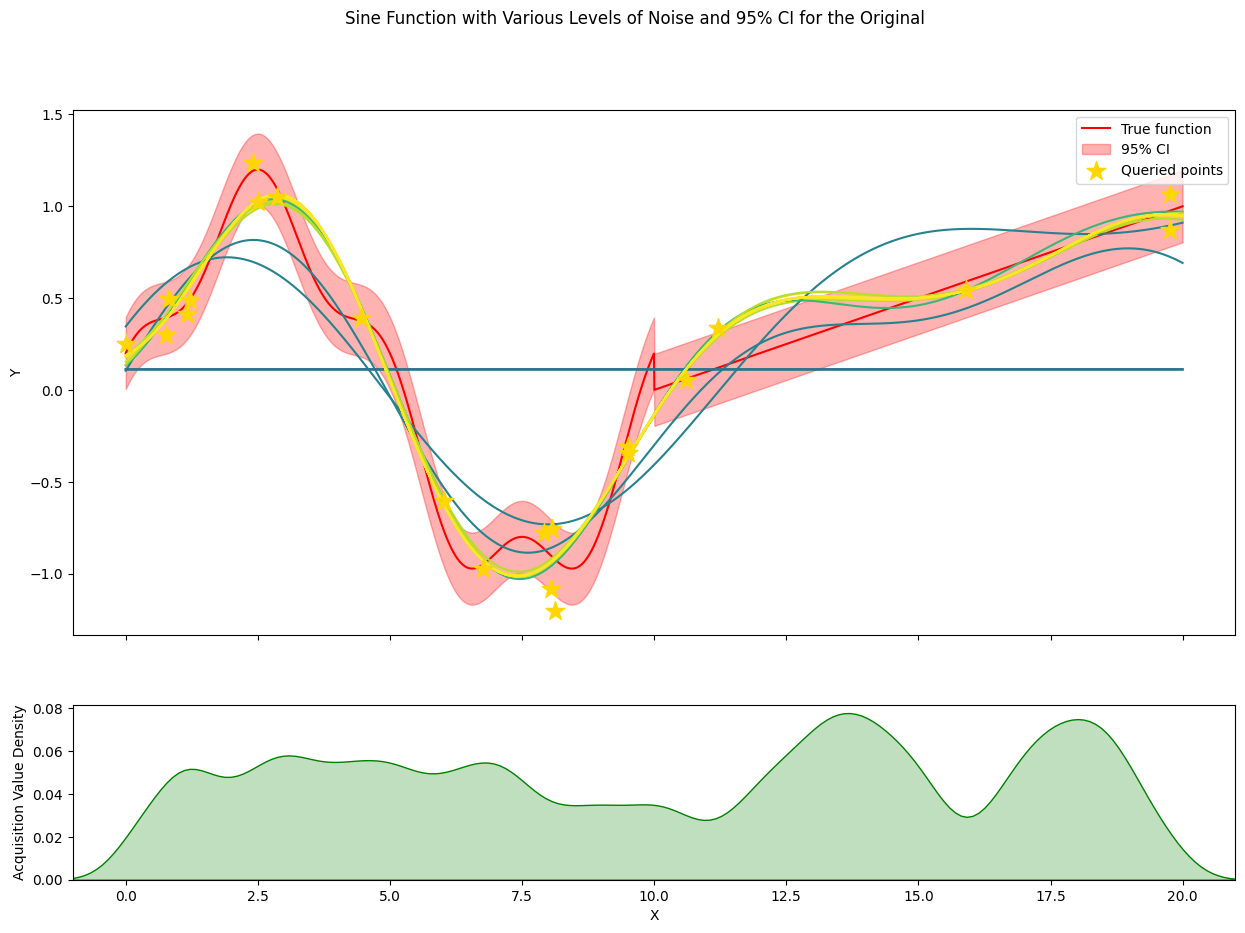

tensor([[2.8978e-09],
        [2.9350e-09],
        [3.0425e-09],
        ...,
        [4.8581e-09],
        [2.4972e-09],
        [1.7756e-09]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0370], dtype=torch.float64), 'lengthscale': tensor([[0.1066]], dtype=torch.float64), 'outputscale': tensor([0.7629], dtype=torch.float64), 'mean': tensor([0.3086], dtype=torch.float64)}
64
{'noise': tensor([7.5354e+01, 8.5702e+00, 1.8768e+01, 4.2665e-01, 6.5413e-03, 6.9116e-01,
        1.3678e-01, 7.3086e-01, 1.4753e+00, 4.7984e-02, 1.6659e+01, 4.2732e-03,
        5.4623e-02, 5.4129e+00, 5.7140e-01, 4.2218e-02, 3.2269e-01, 1.8369e+01,
        1.7761e-01, 3.2328e-03, 8.3742e+00, 4.9750e+02, 9.6769e-01, 5.9999e+00,
        3.8838e-02, 3.0633e-02, 8.3575e-01, 3.0441e-01, 1.3821e-01, 5.0788e-01,
        5.9066e+00, 3.0452e-03, 1.2568e-01, 1.6516e+00, 9.4544e-01, 1.7388e-02,
        9.6580e-02, 9.1304e-02, 9.3186e+00, 1.1800e+01, 4.8756e+00, 2.3147e+00,
        1.0755e-02

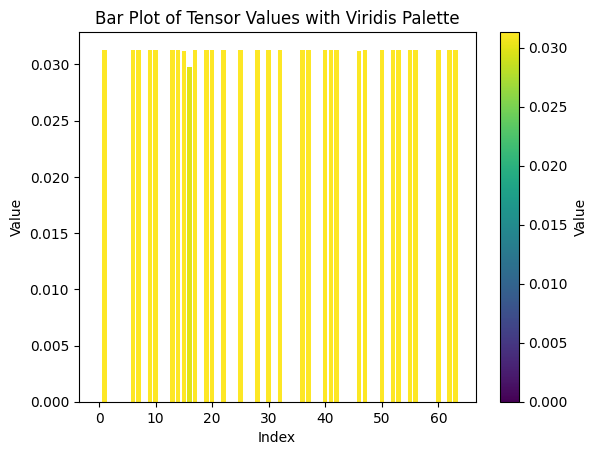

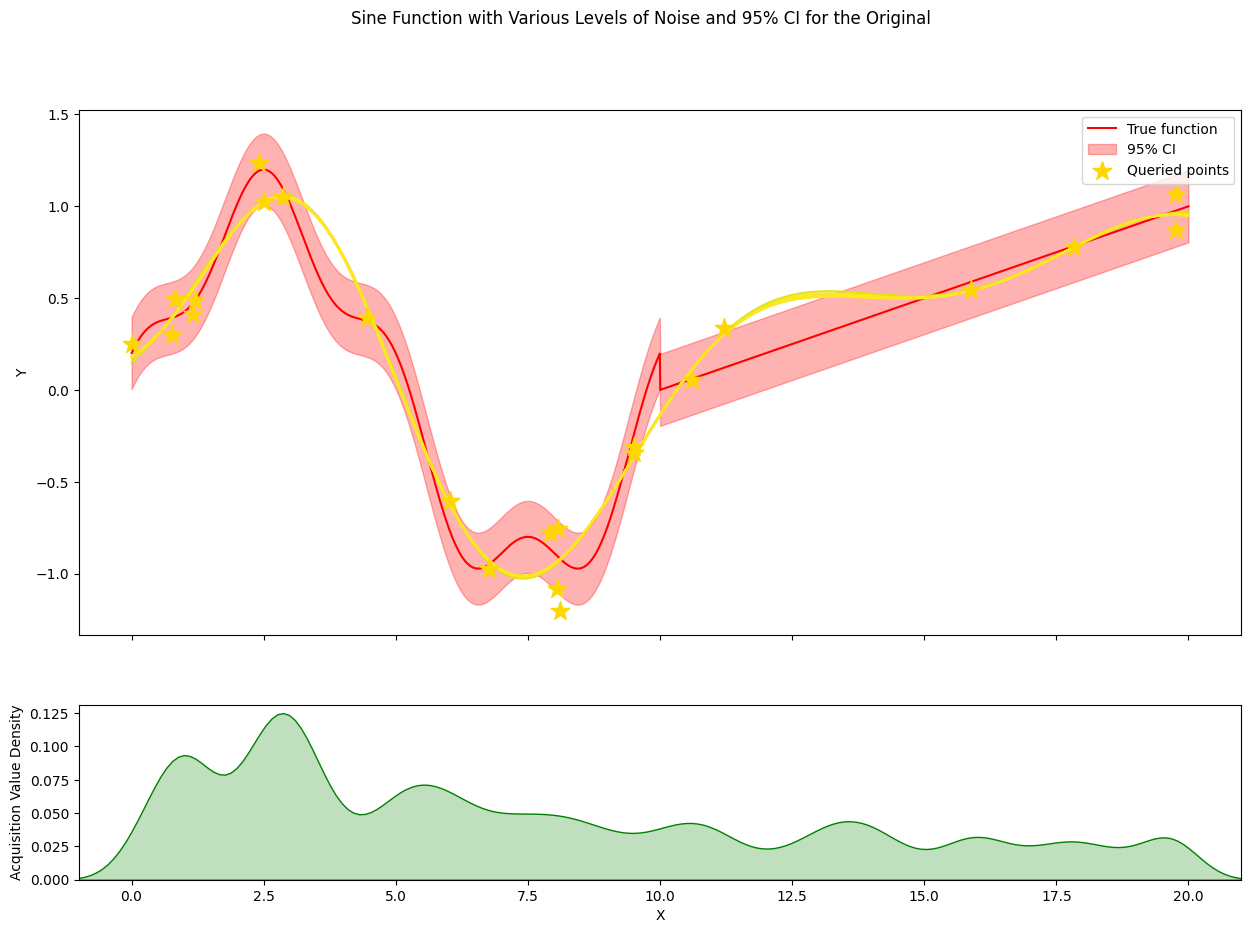

tensor([[5.0809e-12],
        [2.5950e-12],
        [5.4679e-12],
        ...,
        [1.1234e-11],
        [7.6945e-12],
        [8.2080e-12]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0371], dtype=torch.float64), 'lengthscale': tensor([[0.1107]], dtype=torch.float64), 'outputscale': tensor([0.7453], dtype=torch.float64), 'mean': tensor([0.2719], dtype=torch.float64)}
64
{'noise': tensor([1.6775e+01, 7.4313e-01, 6.3998e+01, 4.2622e+00, 2.6242e-01, 4.4029e-01,
        4.7396e-01, 1.3611e+00, 2.6811e-03, 7.3191e+01, 1.8292e+02, 1.5417e+00,
        9.7274e-01, 6.8760e+00, 8.5512e+00, 1.9181e+02, 4.5325e+00, 1.7058e+00,
        3.1759e+00, 5.9612e-01, 2.3811e+02, 1.3616e+02, 1.1247e-01, 4.4404e-01,
        2.0345e+01, 1.3775e+01, 8.4117e-01, 8.5670e-02, 1.1599e+00, 2.3655e+00,
        1.5908e-01, 1.5067e+00, 1.4330e+02, 7.3567e+00, 2.0980e+00, 7.9098e+00,
        1.0622e+01, 8.0470e-01, 2.6336e+01, 2.9266e-03, 2.1942e-01, 5.9930e-03,
        2.2432e+01

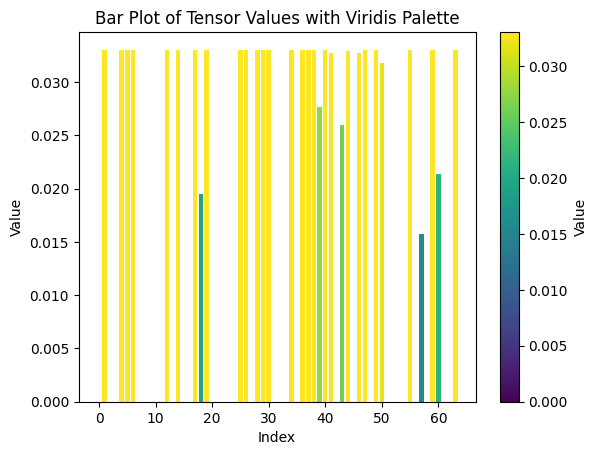

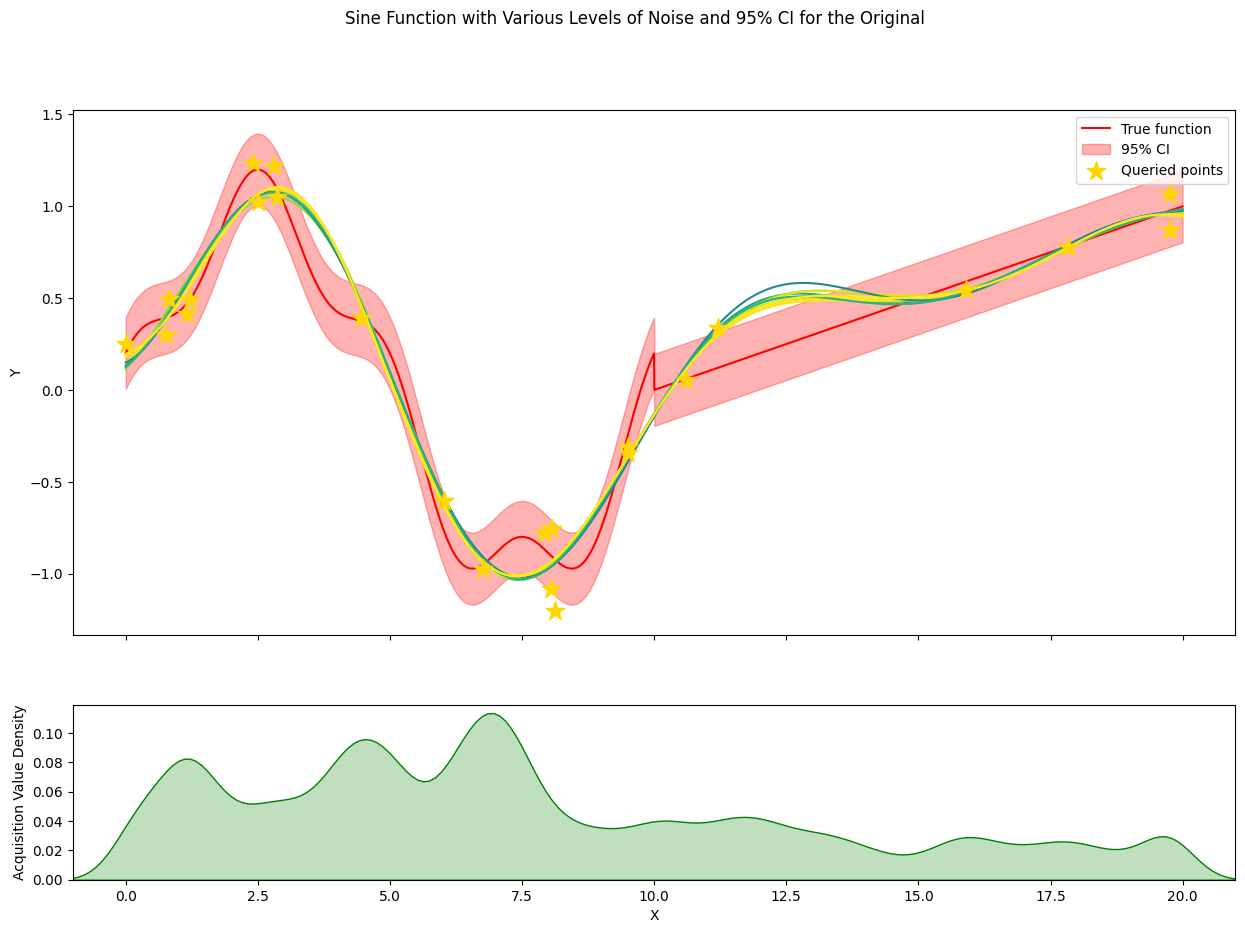

tensor([[1.9357e-13],
        [9.9899e-14],
        [2.4662e-13],
        ...,
        [4.5271e-13],
        [2.1453e-13],
        [1.9890e-13]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0341], dtype=torch.float64), 'lengthscale': tensor([[0.1063]], dtype=torch.float64), 'outputscale': tensor([0.7067], dtype=torch.float64), 'mean': tensor([0.2161], dtype=torch.float64)}
64
{'noise': tensor([2.5094e+00, 1.9516e+02, 1.7089e+02, 1.9354e+00, 1.7597e+00, 4.4969e-01,
        1.8192e+00, 3.5726e+00, 5.8241e-04, 5.9467e+00, 4.0938e+01, 6.1625e+01,
        6.2647e-01, 1.3005e+01, 1.0996e+01, 1.6588e+00, 6.1565e-03, 2.0876e-04,
        1.5884e+00, 1.3380e-02, 1.1823e-01, 3.2028e+00, 1.2958e+00, 2.8355e-01,
        9.9897e-02, 2.4551e-01, 4.4617e-02, 1.3324e+00, 2.2334e+02, 4.8379e+00,
        3.2122e-01, 2.1227e-02, 8.7072e-01, 6.8716e-01, 8.2917e+00, 2.0747e+01,
        9.0397e-01, 7.5760e-02, 1.4869e+01, 1.7273e-01, 2.3982e-02, 2.9468e+00,
        9.8782e-01

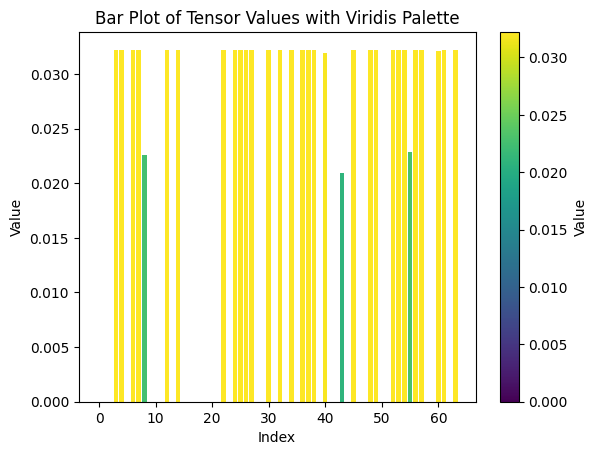

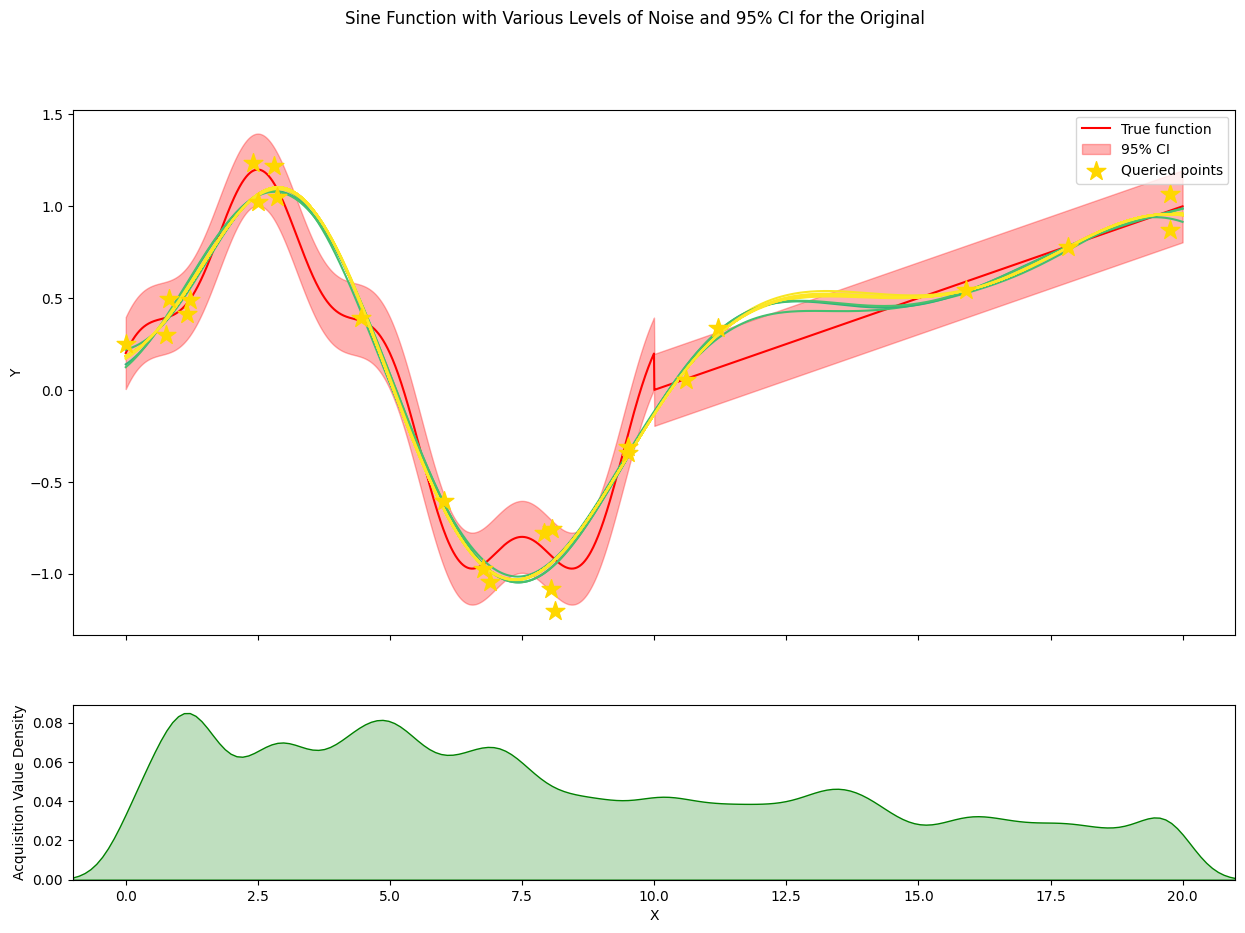

tensor([[1.5532e-13],
        [8.6056e-14],
        [2.0380e-13],
        ...,
        [3.4783e-13],
        [1.6549e-13],
        [1.6688e-13]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0306], dtype=torch.float64), 'lengthscale': tensor([[0.1078]], dtype=torch.float64), 'outputscale': tensor([0.6854], dtype=torch.float64), 'mean': tensor([0.2728], dtype=torch.float64)}
64
{'noise': tensor([5.3362e-02, 5.5295e-01, 1.7884e-01, 2.9546e+01, 3.8315e+00, 5.5608e-02,
        5.8844e+01, 2.6519e+01, 1.1220e-02, 3.9714e+01, 4.8228e+00, 3.5381e+01,
        5.4407e+02, 5.0909e+00, 7.5737e+00, 3.2442e-01, 3.9547e-01, 6.2727e-02,
        1.5157e-03, 3.6103e-01, 6.0831e-02, 1.6360e+01, 4.2485e+00, 1.7824e-03,
        6.4212e+00, 3.5684e-01, 2.8318e-03, 1.6541e-01, 6.9118e+00, 6.4529e+00,
        1.2215e+02, 5.5269e-04, 2.7894e-01, 4.4200e-02, 5.4111e+00, 4.9919e-01,
        2.1765e-02, 2.6694e-01, 6.9641e-03, 3.6064e-01, 7.3629e-01, 2.3791e+00,
        4.7457e+00

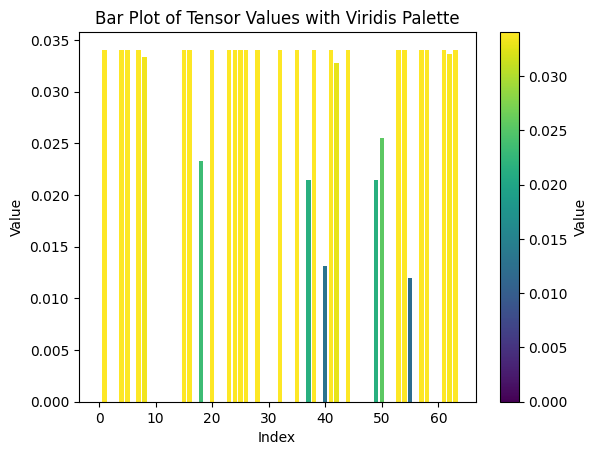

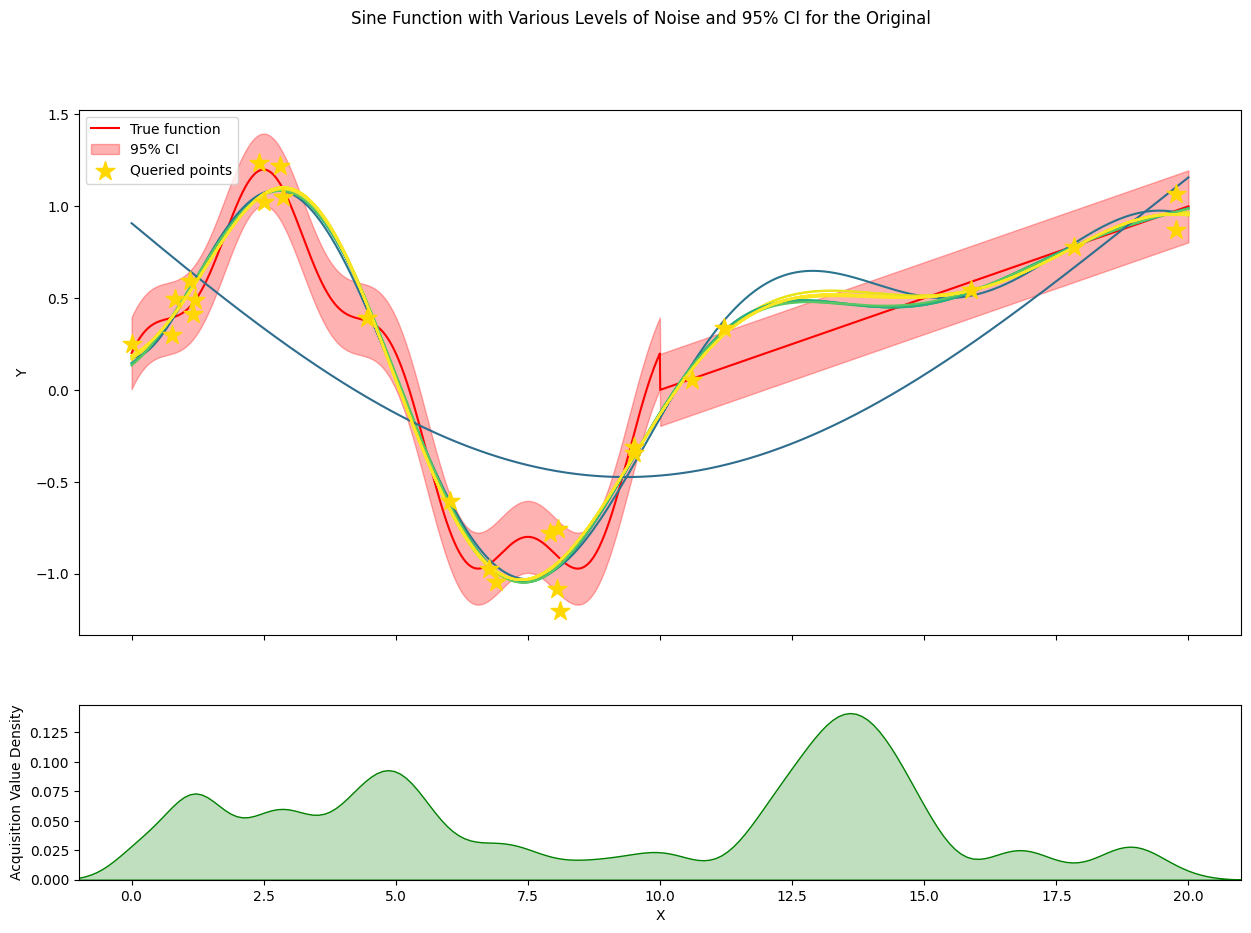

tensor([[5.0757e-09],
        [4.0014e-09],
        [6.1901e-09],
        ...,
        [2.0833e-08],
        [2.4292e-09],
        [1.3626e-09]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0302], dtype=torch.float64), 'lengthscale': tensor([[0.1096]], dtype=torch.float64), 'outputscale': tensor([0.7128], dtype=torch.float64), 'mean': tensor([0.2537], dtype=torch.float64)}
64
{'noise': tensor([7.1611e+00, 1.7698e+02, 9.3356e+00, 5.5341e+00, 6.3718e-03, 9.1009e-01,
        1.1224e+01, 3.8406e-01, 3.0633e-02, 1.4474e+00, 6.4697e-02, 8.8373e-01,
        1.2781e+02, 9.6387e+00, 3.0138e-01, 4.0408e+00, 5.6010e-03, 2.8986e-02,
        4.7989e-01, 1.2754e+00, 3.8763e+00, 7.4065e+00, 2.9776e-01, 7.1030e-01,
        2.8742e+00, 7.3954e+01, 4.7620e-01, 3.1540e+02, 9.9057e-02, 2.7173e+01,
        6.3213e+01, 3.0405e+00, 3.5112e-01, 5.7173e-01, 1.4634e-01, 1.7141e+00,
        1.0669e-03, 2.1302e+00, 4.7754e+00, 2.1740e-01, 1.4131e+00, 8.1652e+01,
        3.9221e+01

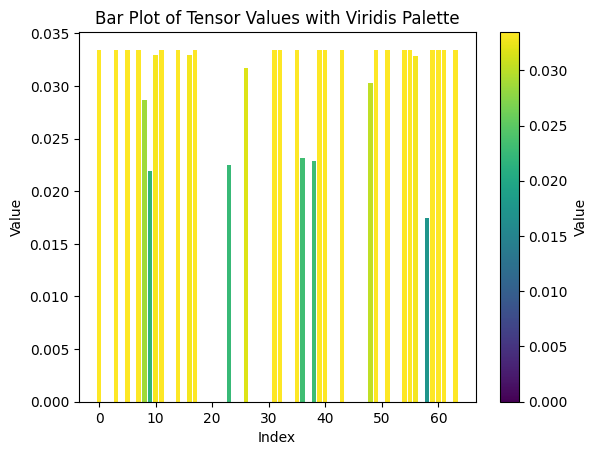

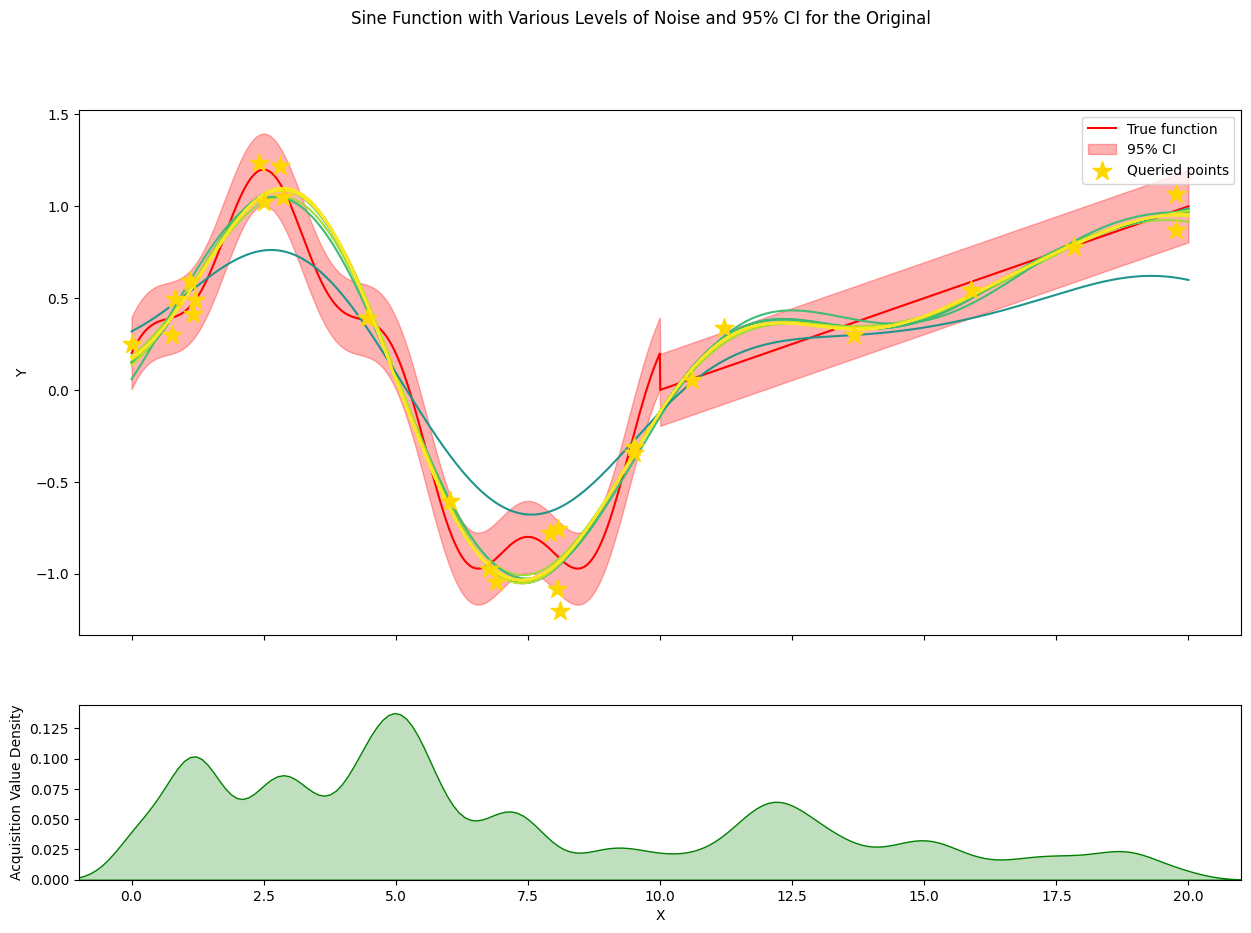

tensor([[2.1761e-11],
        [3.3541e-11],
        [4.2051e-11],
        ...,
        [1.9353e-10],
        [1.7701e-11],
        [5.7746e-12]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0311], dtype=torch.float64), 'lengthscale': tensor([[0.1117]], dtype=torch.float64), 'outputscale': tensor([0.7273], dtype=torch.float64), 'mean': tensor([0.2277], dtype=torch.float64)}
64
{'noise': tensor([2.9008e+00, 4.4747e+01, 7.5750e-01, 5.8472e+00, 3.6798e-01, 4.7258e-01,
        3.1561e+00, 1.8618e-02, 4.0041e+00, 4.1827e+02, 1.8895e+02, 2.6331e-03,
        8.5778e-04, 1.6032e+01, 5.6285e+01, 6.6763e+00, 3.4882e-01, 4.2141e-01,
        3.1979e+01, 9.3668e-01, 5.7195e-02, 1.1530e-01, 1.1981e-02, 3.9857e-02,
        3.1015e-01, 6.3751e-03, 4.5684e+01, 6.3142e+00, 4.8302e-01, 1.2004e-01,
        3.5662e-02, 2.8149e-02, 1.0235e+01, 1.0781e+00, 4.4681e-01, 5.8171e-01,
        1.6909e-01, 1.5109e+00, 2.3055e+00, 4.8519e-02, 3.6488e-03, 1.7148e+03,
        7.1977e-01

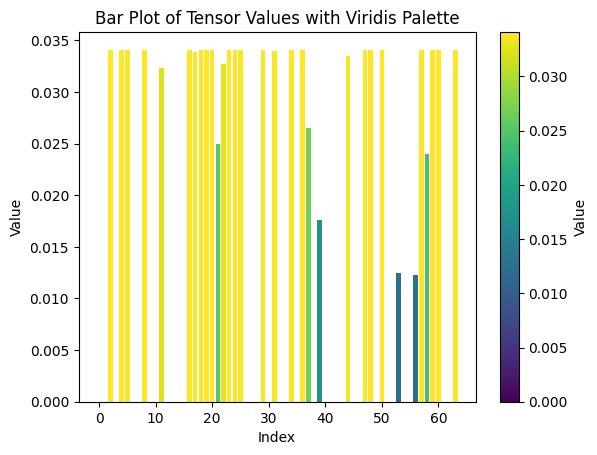

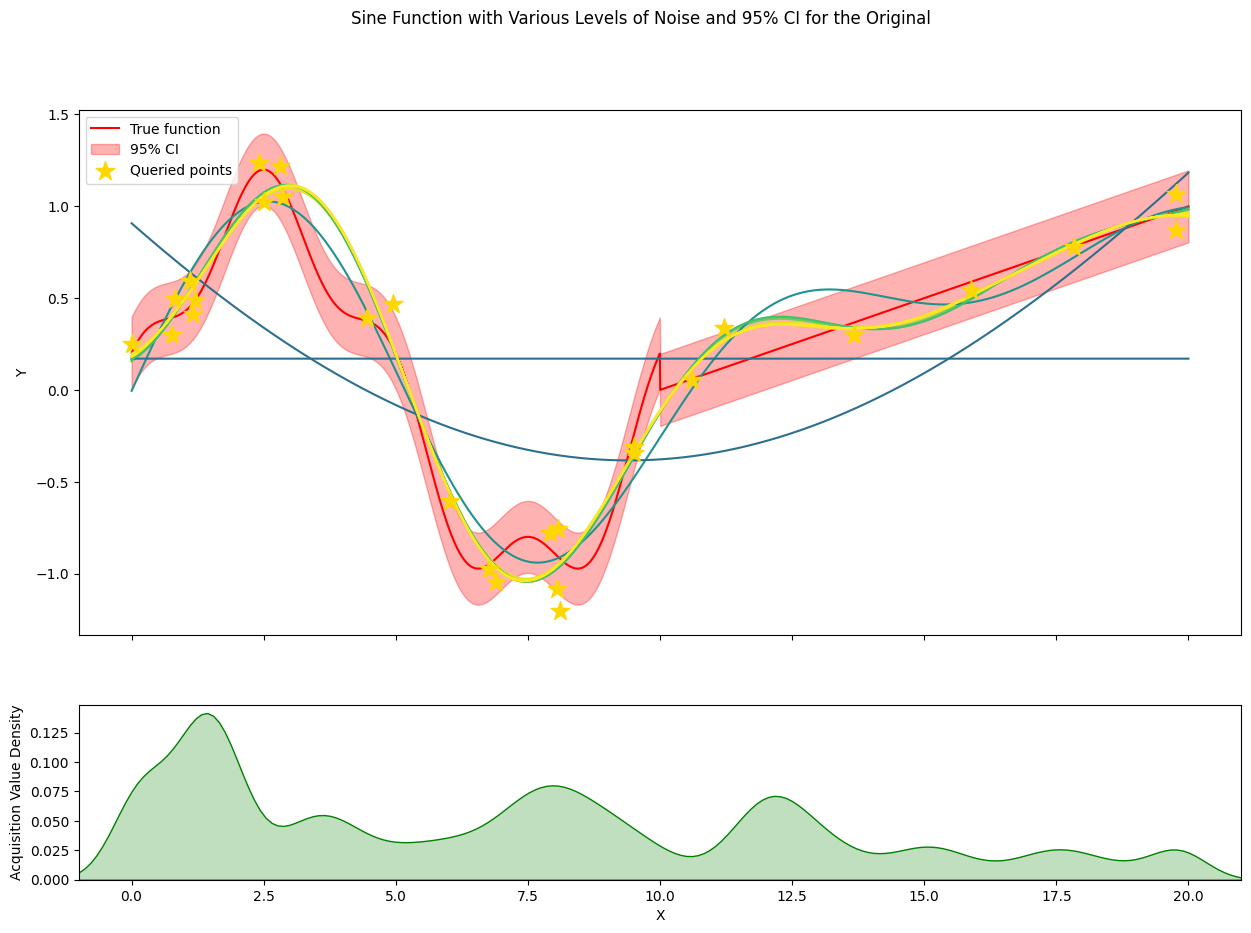

tensor([[2.7636e-10],
        [2.8145e-10],
        [1.4668e-09],
        ...,
        [2.8056e-10],
        [8.5301e-10],
        [2.5666e-10]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0387], dtype=torch.float64), 'lengthscale': tensor([[0.1174]], dtype=torch.float64), 'outputscale': tensor([0.8106], dtype=torch.float64), 'mean': tensor([0.2281], dtype=torch.float64)}
64
{'noise': tensor([3.9914e+01, 6.8532e-01, 3.4597e-01, 2.2036e+01, 1.8368e+00, 1.7932e+00,
        1.6937e+00, 1.2060e+00, 3.8391e+00, 5.0804e-02, 2.3148e+00, 8.3237e-01,
        3.3977e+00, 9.4003e+00, 3.8883e-02, 4.7592e+01, 4.6788e-03, 1.0635e-01,
        1.6707e+00, 1.1589e+01, 1.9369e+02, 3.4126e+01, 6.1477e-01, 3.5091e-02,
        1.6520e-01, 6.6251e-03, 8.8742e-02, 2.4988e+00, 4.4164e-02, 1.7170e+01,
        8.1783e+00, 1.6408e-02, 4.3714e+00, 2.4165e-02, 1.8126e+02, 3.4016e+00,
        4.0015e-01, 1.3592e-01, 1.5645e+00, 8.6768e+00, 1.7823e+00, 8.5474e-01,
        1.3904e-01

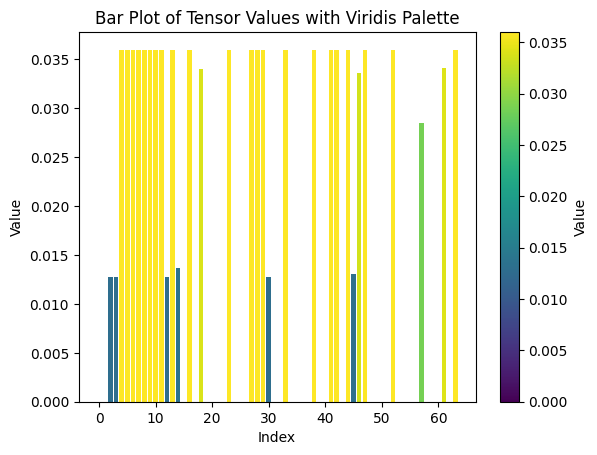

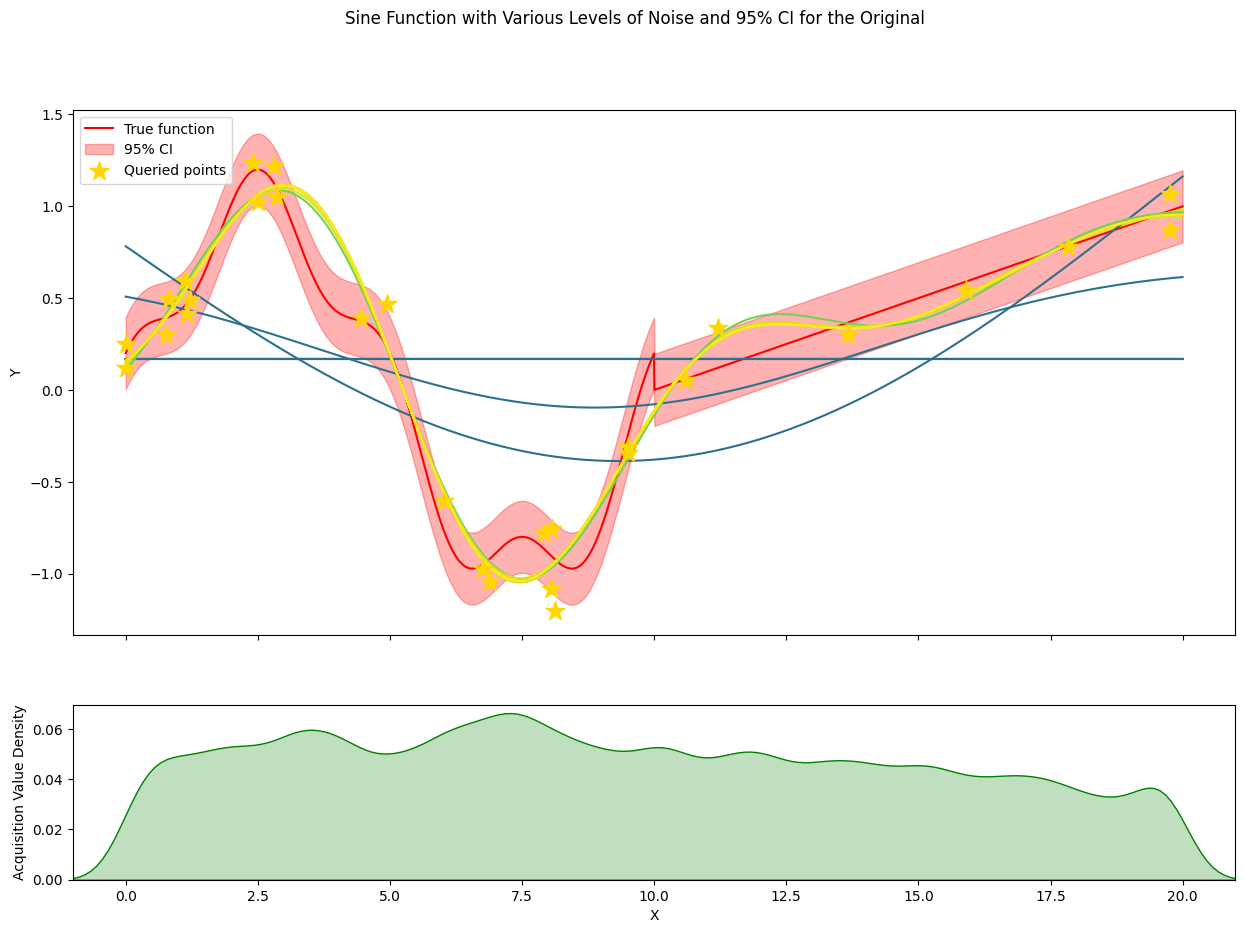

tensor([[3.5553e-12],
        [2.9864e-12],
        [3.5648e-12],
        ...,
        [3.4573e-12],
        [4.1558e-12],
        [3.4243e-12]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0385], dtype=torch.float64), 'lengthscale': tensor([[0.1189]], dtype=torch.float64), 'outputscale': tensor([0.8531], dtype=torch.float64), 'mean': tensor([0.2239], dtype=torch.float64)}
64
{'noise': tensor([4.7389e-01, 5.6746e-01, 7.1423e-02, 1.1816e-01, 7.0365e+01, 2.0620e+00,
        1.0733e+00, 2.2947e-01, 7.8995e+00, 7.4035e-02, 2.2109e+02, 9.0627e-01,
        6.6508e-01, 1.0983e+00, 3.9466e-02, 2.2408e+01, 6.3261e-01, 1.6230e+01,
        1.6708e+01, 1.1788e-03, 1.0139e+01, 7.4166e-01, 1.4260e+02, 2.3162e-01,
        1.8670e+00, 1.7617e+00, 2.8363e-02, 4.0723e+00, 6.3033e+00, 1.6564e-01,
        1.5889e+01, 1.9670e+01, 7.5505e-01, 1.6590e+01, 3.1377e+02, 3.9258e-01,
        9.6474e+00, 1.1602e+00, 3.0196e+02, 1.3347e-02, 2.7211e+01, 8.5941e-03,
        2.2649e+00

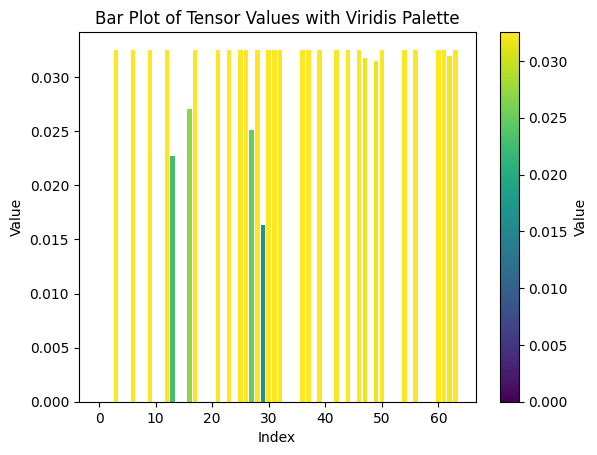

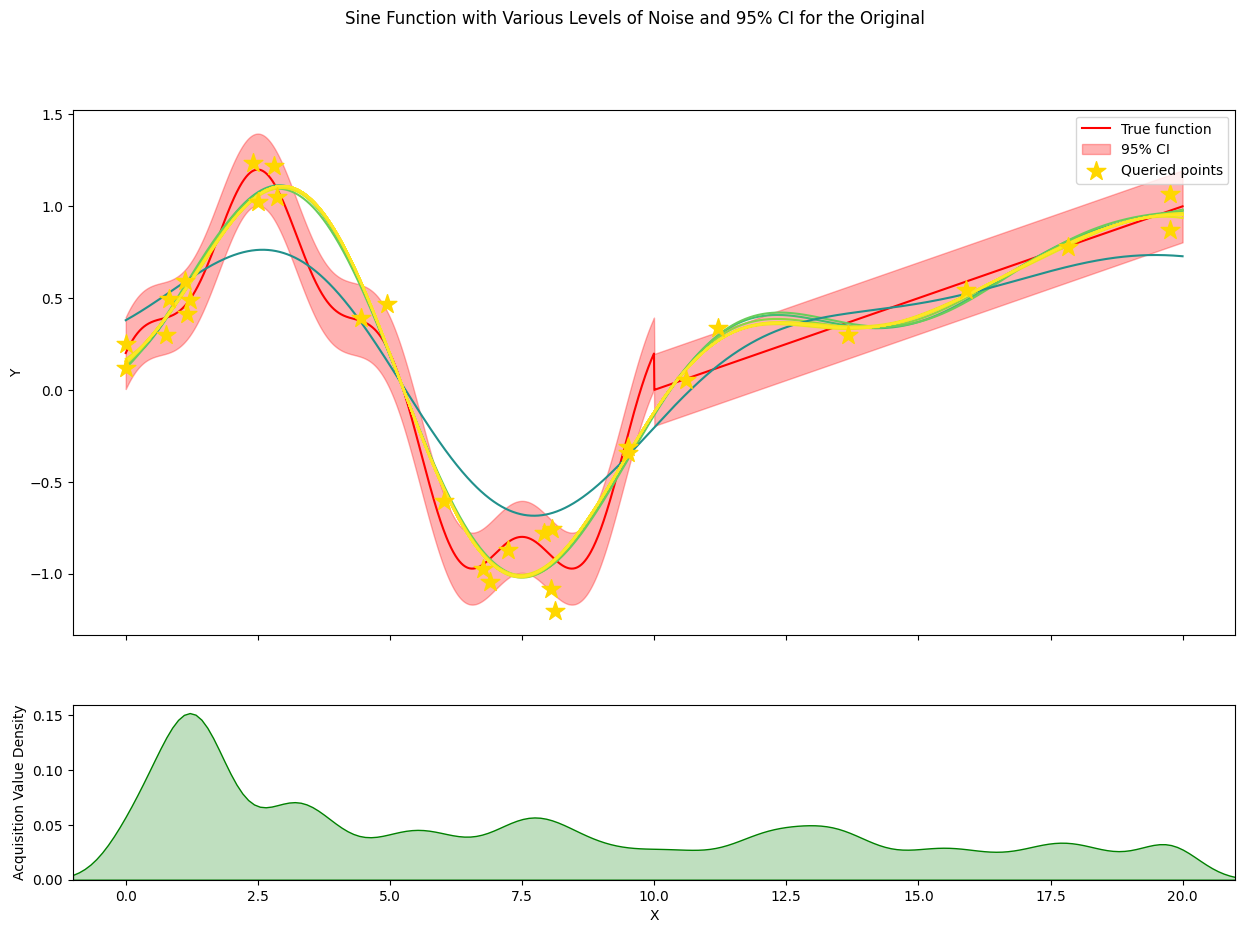

tensor([[3.2942e-12],
        [4.0186e-12],
        [1.3896e-11],
        ...,
        [5.8612e-12],
        [8.0381e-12],
        [5.7191e-12]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0376], dtype=torch.float64), 'lengthscale': tensor([[0.1190]], dtype=torch.float64), 'outputscale': tensor([0.8081], dtype=torch.float64), 'mean': tensor([0.2693], dtype=torch.float64)}
64
{'noise': tensor([1.7850e+01, 5.8077e-01, 1.4846e+01, 6.5273e+00, 2.6287e+00, 1.3767e+00,
        1.4852e-03, 5.3982e-01, 1.0317e+01, 9.9360e-01, 6.4321e+00, 1.1829e+02,
        7.7579e-01, 1.3745e+01, 9.7294e-03, 1.1298e-01, 2.8134e+00, 2.4469e-01,
        1.2943e+01, 1.0852e+01, 2.7016e+00, 5.0050e+00, 1.9578e-01, 1.3015e+02,
        2.3460e-01, 1.8438e+01, 1.2437e+00, 5.3513e+02, 1.4917e+00, 3.9391e-01,
        3.2422e+01, 1.3615e+01, 1.1473e-01, 1.4875e-01, 2.0836e+03, 2.1290e-01,
        2.9559e-02, 5.7038e+01, 3.0920e-02, 4.4101e-01, 1.1518e+01, 2.1454e+01,
        1.6073e+00

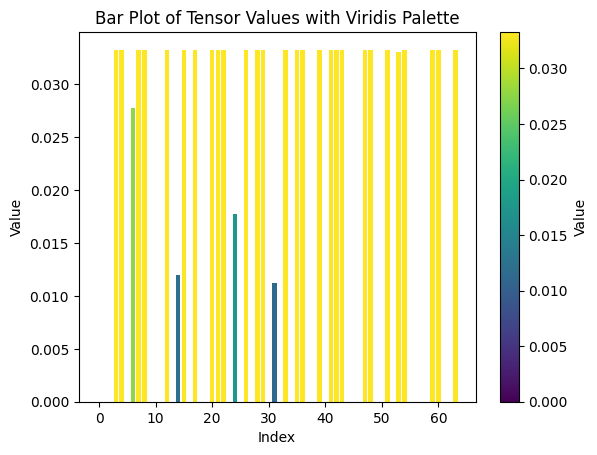

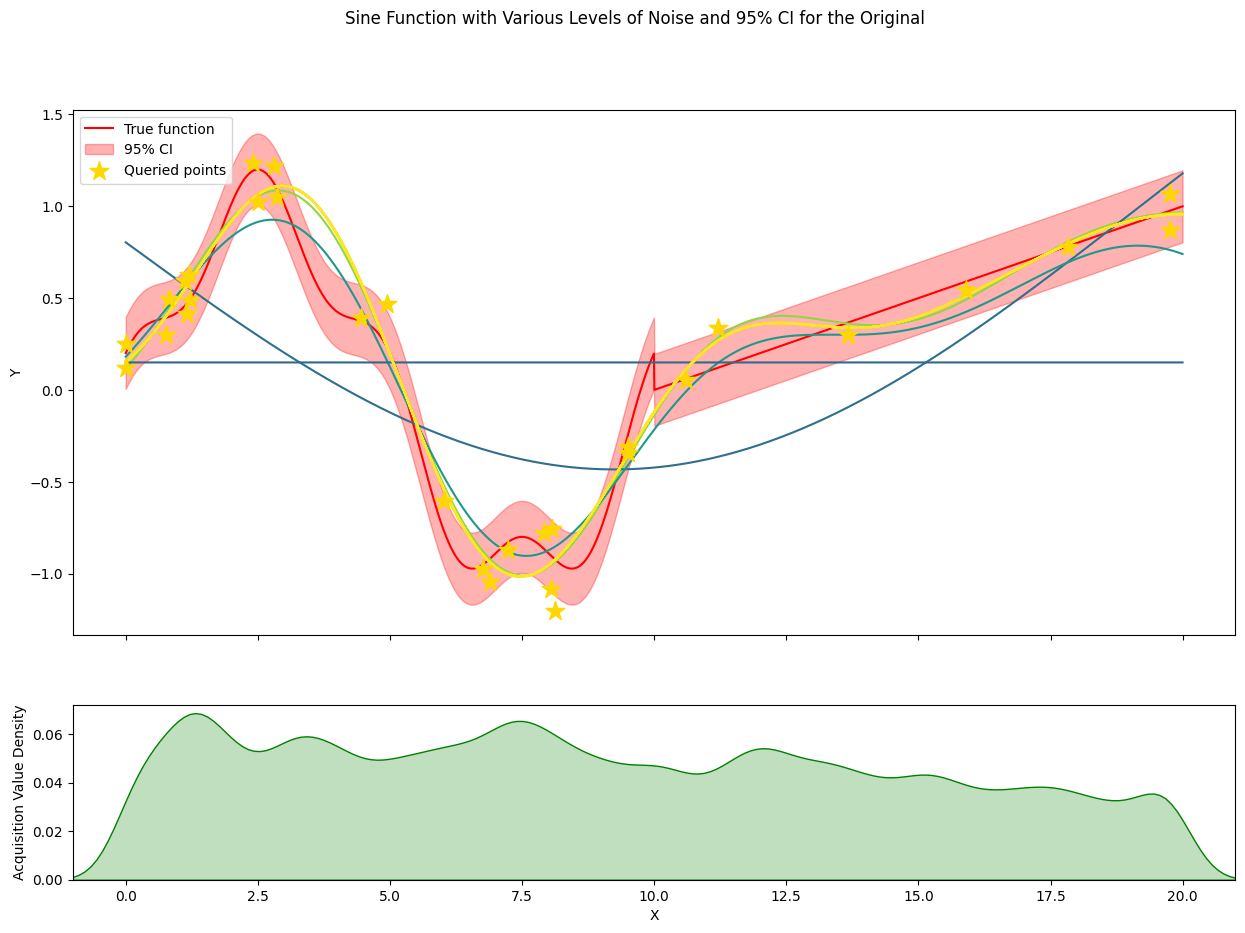

tensor([[1.2140e-13],
        [1.1130e-13],
        [1.6241e-13],
        ...,
        [1.3416e-13],
        [1.6174e-13],
        [1.2115e-13]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0369], dtype=torch.float64), 'lengthscale': tensor([[0.1200]], dtype=torch.float64), 'outputscale': tensor([0.8322], dtype=torch.float64), 'mean': tensor([0.2500], dtype=torch.float64)}
64
{'noise': tensor([3.6648e-01, 2.2528e+00, 3.6689e-01, 6.4016e+00, 7.2321e+00, 1.3007e+00,
        2.2407e+00, 2.2316e+01, 1.4256e+00, 3.9890e-01, 6.1818e+00, 2.6702e-02,
        1.5059e+01, 5.1310e+00, 3.6832e-01, 2.7501e+00, 4.7191e-01, 6.4054e-02,
        7.7660e-01, 5.9456e-01, 4.0598e+01, 8.9341e+00, 1.2315e-01, 4.2052e+00,
        2.9699e+00, 5.8932e+00, 4.8940e-01, 1.2603e+01, 1.1990e+01, 3.5753e-01,
        1.3304e+00, 9.5567e-04, 1.6316e+02, 4.5886e-01, 3.4143e+00, 3.5816e+00,
        1.7803e-01, 6.7037e+01, 3.0260e+01, 3.4884e+00, 7.3202e-02, 9.7767e-01,
        6.7389e-01

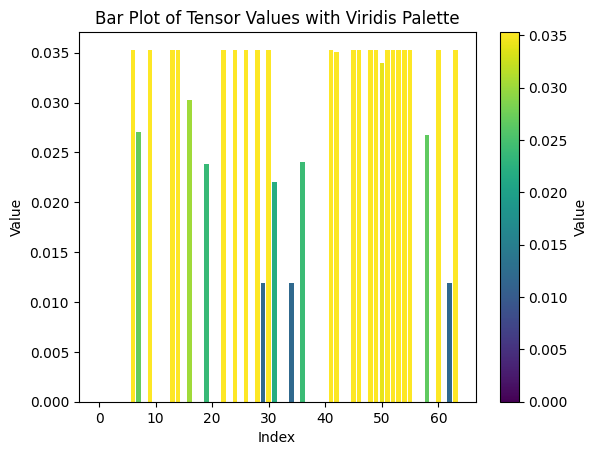

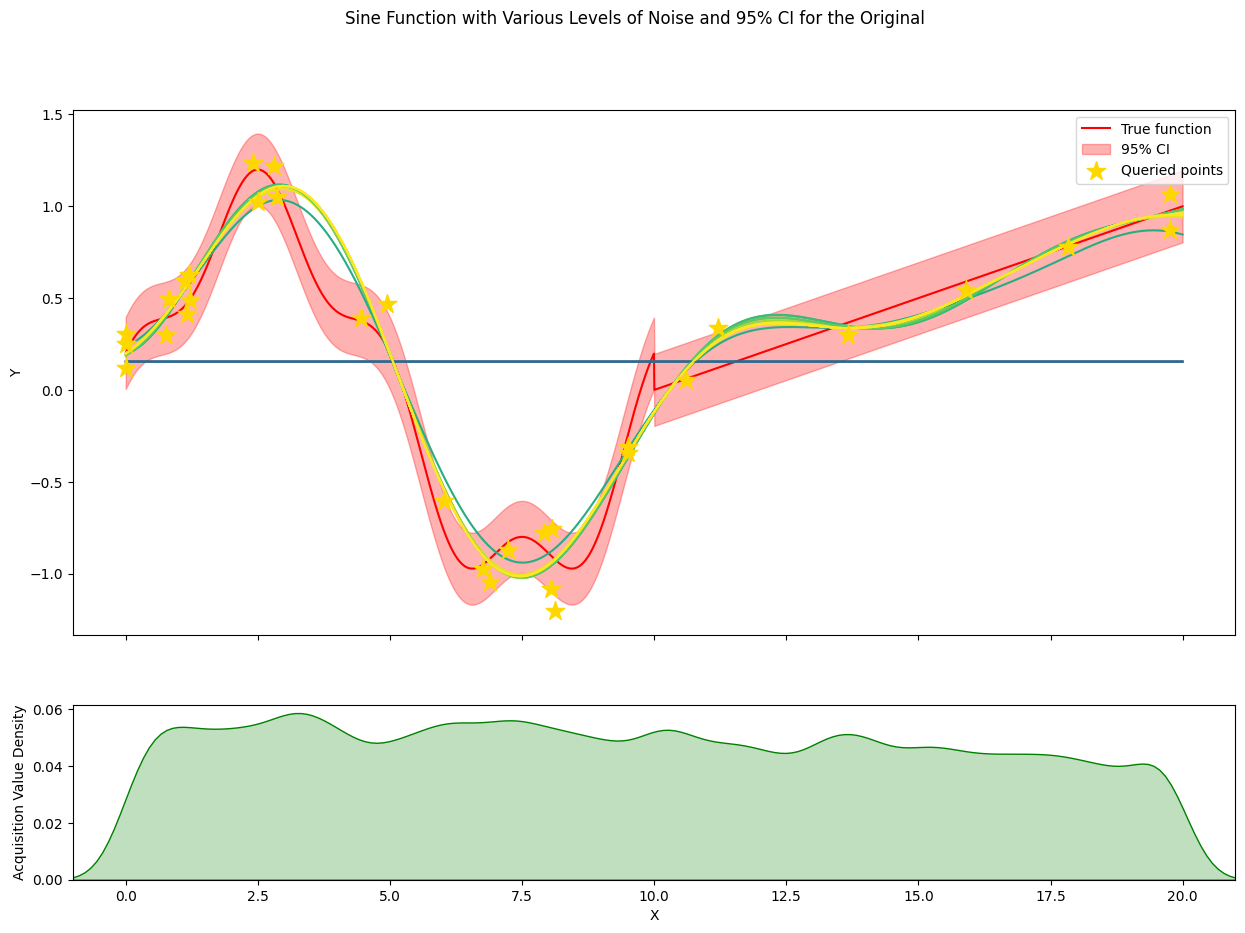

tensor([[8.9500e-12],
        [8.0909e-12],
        [9.0143e-12],
        ...,
        [8.8676e-12],
        [9.5146e-12],
        [9.4388e-12]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0377], dtype=torch.float64), 'lengthscale': tensor([[0.1180]], dtype=torch.float64), 'outputscale': tensor([0.8295], dtype=torch.float64), 'mean': tensor([0.2680], dtype=torch.float64)}
64
{'noise': tensor([9.7390e+00, 9.4153e+00, 1.8242e+00, 2.0403e-01, 1.9408e+00, 2.3671e-01,
        2.0473e-03, 2.2693e+00, 1.3162e-01, 6.4463e-01, 1.7405e+00, 3.0006e+02,
        6.2012e-01, 5.1416e+01, 5.8223e-01, 4.4358e-01, 1.2434e-02, 5.6374e+00,
        1.4072e+00, 1.1741e+00, 8.2037e-01, 1.5310e+01, 5.0525e-01, 3.1207e-01,
        3.2372e+00, 2.4490e+00, 4.3394e-01, 6.3810e-02, 2.4342e+01, 5.4511e-01,
        8.3313e-01, 1.8640e+00, 5.1748e+02, 2.2600e-02, 4.2398e-02, 8.6853e-03,
        2.3383e+01, 8.5922e-01, 6.7379e-02, 7.9663e-01, 5.4072e-03, 2.5322e+02,
        1.4295e+00

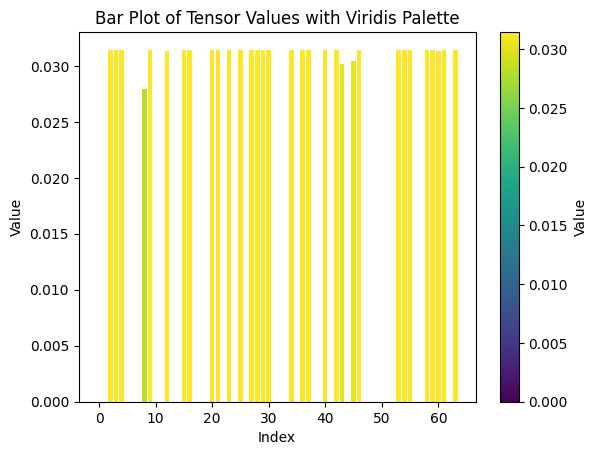

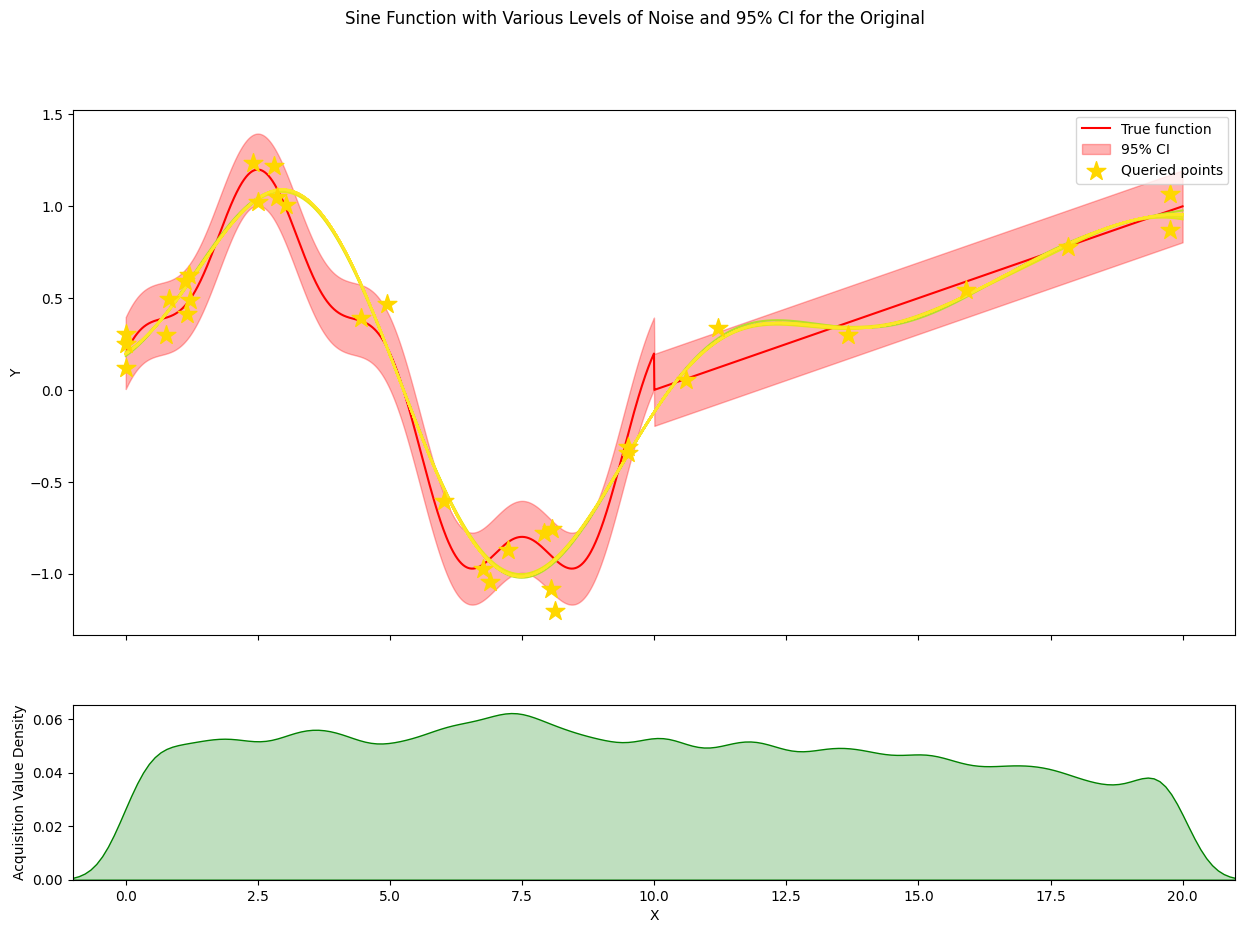

tensor([[1.5476e-10],
        [1.3443e-10],
        [1.5743e-10],
        ...,
        [1.5607e-10],
        [1.7360e-10],
        [1.5157e-10]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0367], dtype=torch.float64), 'lengthscale': tensor([[0.1196]], dtype=torch.float64), 'outputscale': tensor([0.8233], dtype=torch.float64), 'mean': tensor([0.2270], dtype=torch.float64)}
64
{'noise': tensor([4.0478e-01, 6.8499e-01, 1.0646e-01, 1.4239e+01, 2.3171e-02, 6.2607e+00,
        1.8895e-01, 1.3706e+00, 1.0408e+00, 8.2672e-02, 4.5779e-01, 1.2577e-03,
        2.4690e-01, 5.8727e-02, 3.5411e-02, 5.8093e-01, 5.2156e-01, 3.1198e-01,
        8.1186e+00, 4.5392e+01, 3.9231e-02, 1.1002e+02, 6.5167e+00, 9.2267e-01,
        1.2341e+02, 2.0029e+01, 4.1011e+00, 5.5287e+00, 3.9519e+01, 1.0187e-02,
        1.7555e-02, 2.2801e-01, 5.3372e-01, 5.7829e+03, 1.3056e+00, 5.4936e-01,
        5.4260e-02, 2.6577e+00, 3.0799e+00, 5.7925e-01, 7.3402e+00, 7.3015e-01,
        7.5583e+01

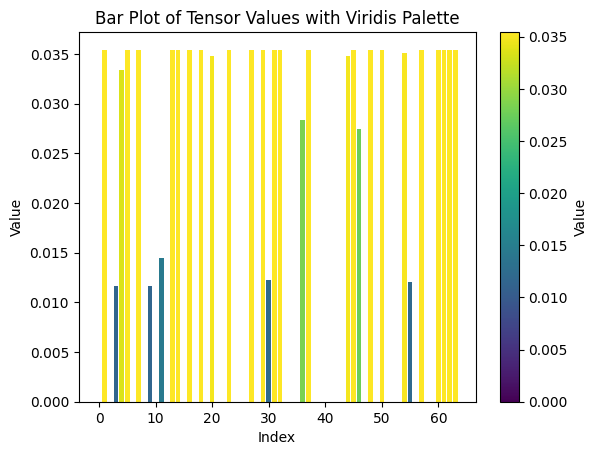

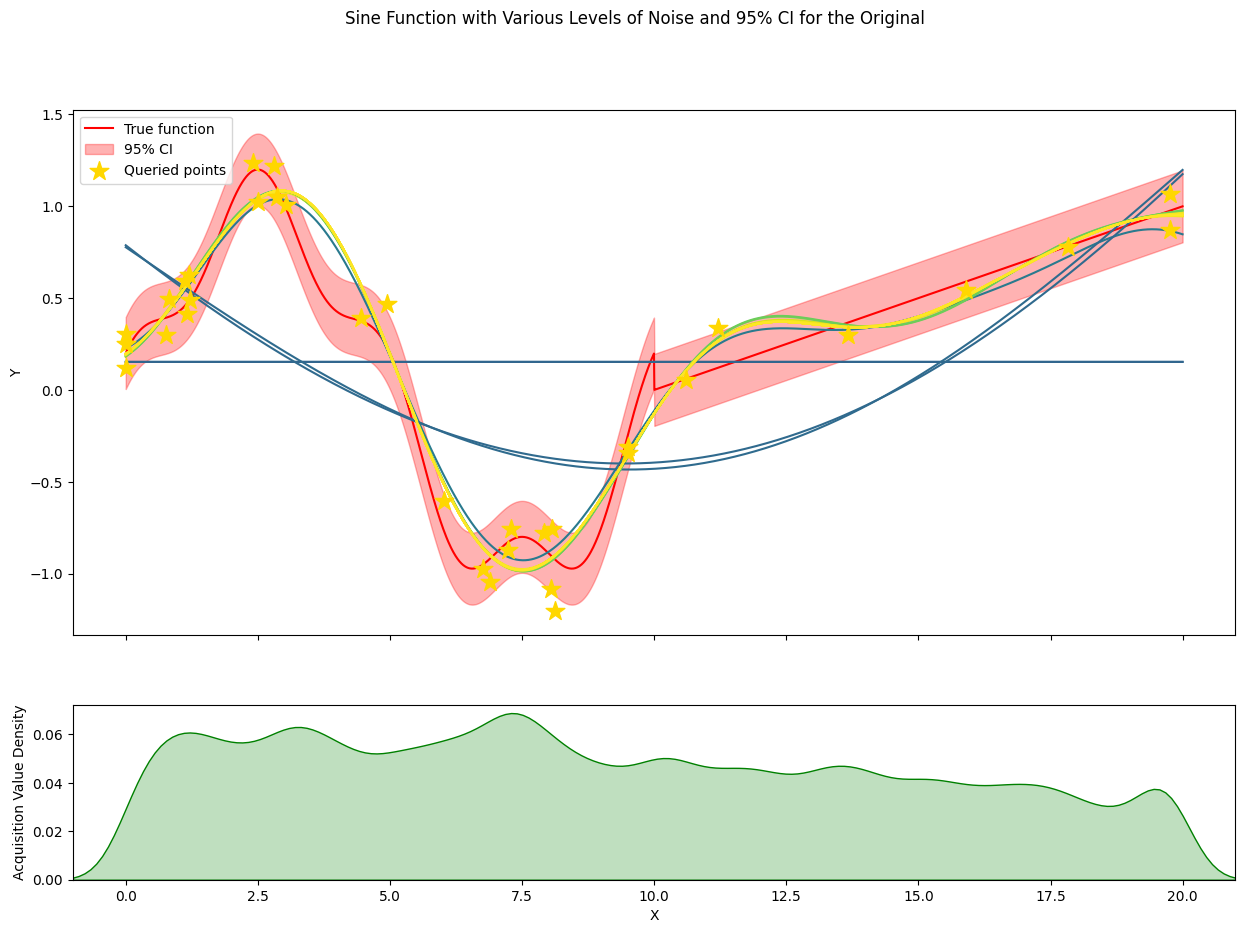

tensor([[5.1705e-13],
        [4.3201e-13],
        [5.8884e-13],
        ...,
        [5.8707e-13],
        [6.4686e-13],
        [5.7845e-13]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0389], dtype=torch.float64), 'lengthscale': tensor([[0.1190]], dtype=torch.float64), 'outputscale': tensor([0.7760], dtype=torch.float64), 'mean': tensor([0.2633], dtype=torch.float64)}
64
{'noise': tensor([3.0134e-01, 2.4306e+01, 4.1266e-02, 1.6756e-02, 1.3601e-03, 4.2227e-03,
        1.4016e+03, 1.6338e-02, 6.6921e-01, 4.0770e-01, 2.9125e-01, 4.6289e-01,
        8.7823e-01, 2.6353e-01, 1.8365e-01, 1.5171e-03, 8.9963e-02, 3.6490e+02,
        7.6299e+02, 9.4041e-03, 1.8014e-01, 2.2437e-03, 7.2339e-04, 4.6509e-01,
        1.8805e-01, 4.0775e-01, 3.5725e+00, 4.9734e+00, 2.4056e+00, 1.0405e+00,
        1.5780e+00, 8.7210e-03, 3.2270e+00, 1.1265e-01, 1.9745e+00, 4.1417e-02,
        1.1666e+02, 1.7813e+00, 2.3980e+00, 3.2851e-01, 2.7521e-02, 5.2481e+00,
        3.9773e-02

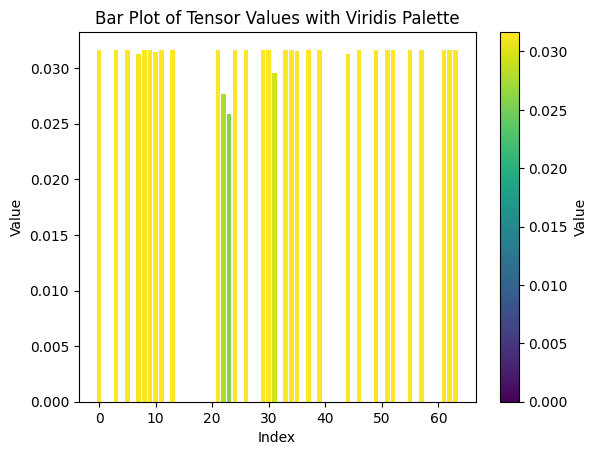

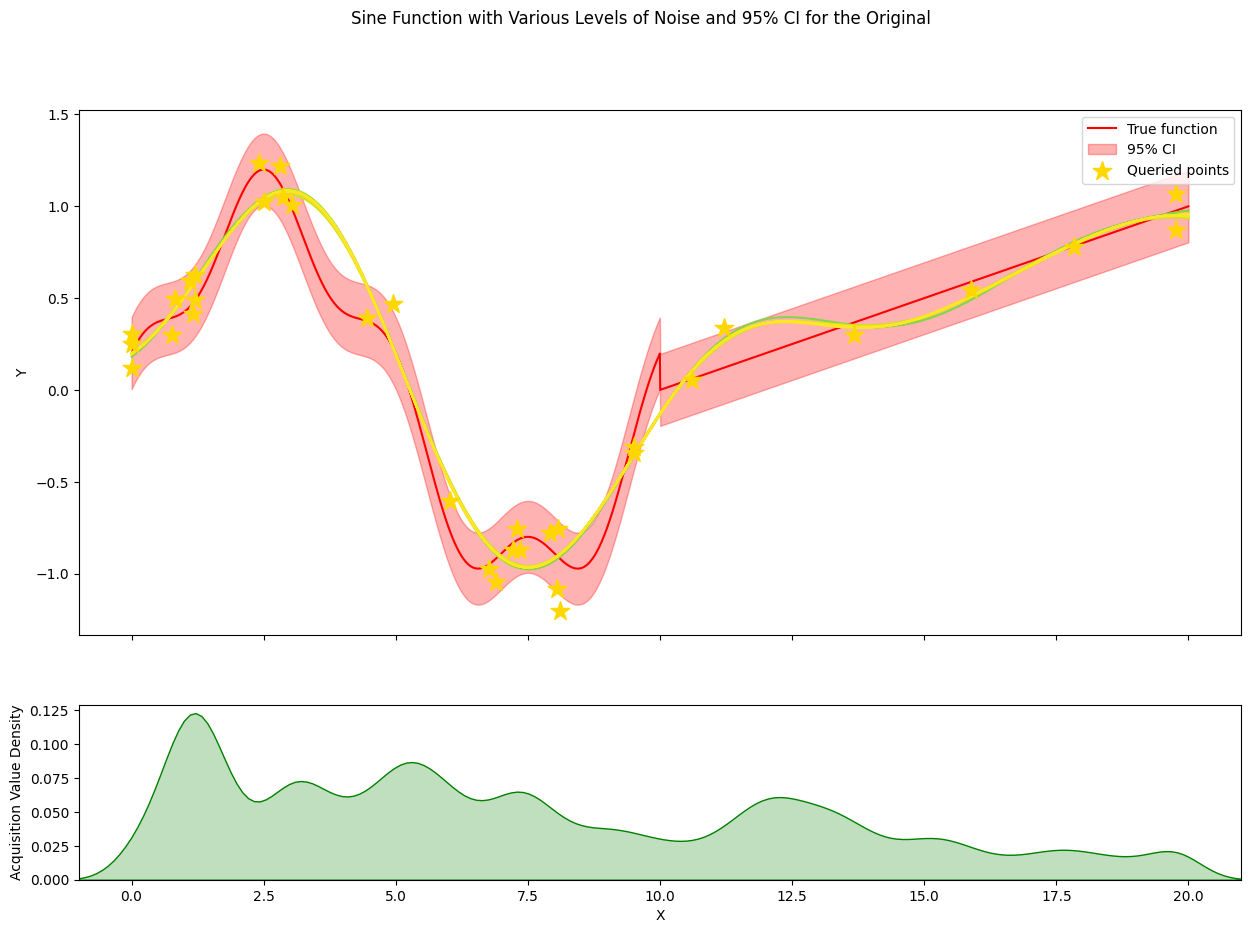

tensor([[3.6991e-14],
        [4.2071e-14],
        [9.5562e-14],
        ...,
        [1.2837e-13],
        [6.0077e-14],
        [3.3133e-14]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0373], dtype=torch.float64), 'lengthscale': tensor([[0.1186]], dtype=torch.float64), 'outputscale': tensor([0.7451], dtype=torch.float64), 'mean': tensor([0.3009], dtype=torch.float64)}
64
{'noise': tensor([1.7301e-01, 1.2142e+00, 7.6930e+00, 1.1003e-02, 3.4576e+01, 4.6964e+01,
        5.9982e+00, 3.3420e-03, 2.2542e+02, 3.2490e-03, 2.0140e-01, 2.0776e+02,
        2.8676e-01, 4.5246e+01, 1.5545e+02, 2.0834e-02, 2.1036e+01, 6.1137e-02,
        2.3968e-01, 3.3648e+01, 1.1675e-03, 2.2355e+01, 1.2408e+01, 2.7486e+02,
        1.0245e-01, 3.0563e+01, 5.0450e-01, 4.8768e-01, 1.3642e+00, 2.9778e+00,
        2.6745e-01, 8.3128e-03, 1.6548e+00, 1.7580e+01, 4.4726e-02, 2.0131e-01,
        1.8340e+00, 8.3336e-01, 1.8336e+01, 7.5054e+00, 8.0933e+00, 1.0051e+00,
        6.5850e-01

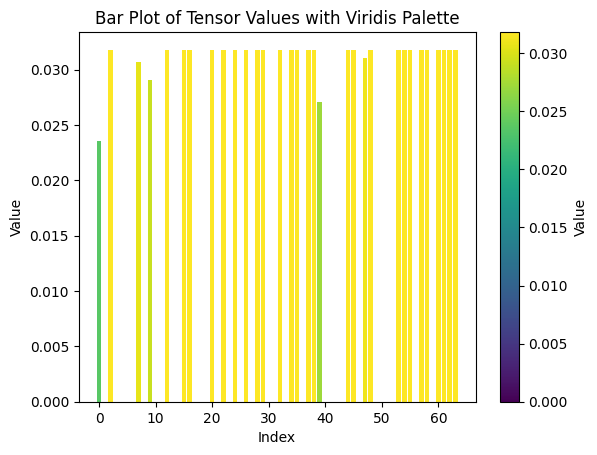

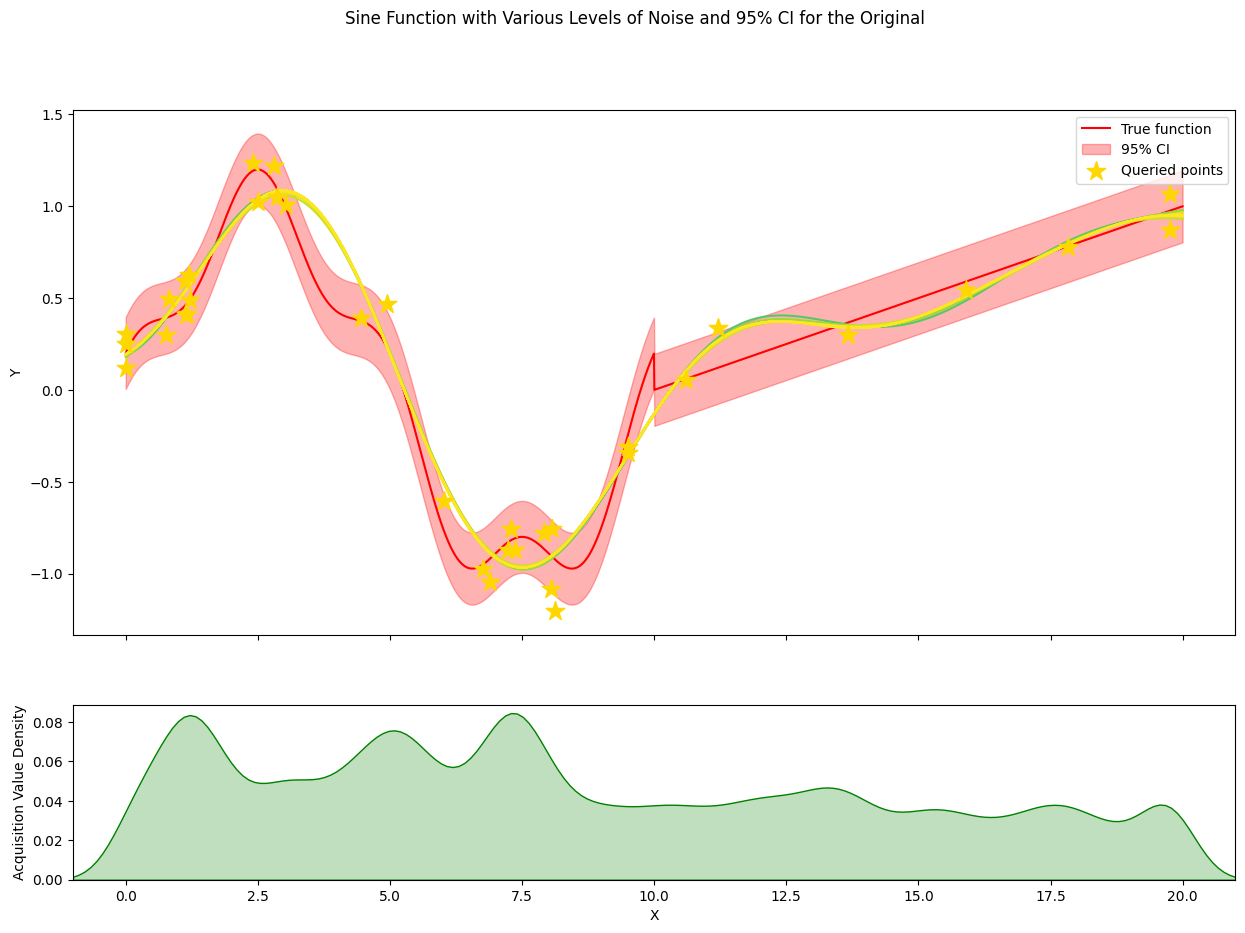

tensor([[8.2393e-12],
        [8.5987e-12],
        [1.4573e-11],
        ...,
        [2.1117e-11],
        [1.3311e-11],
        [1.1957e-11]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0379], dtype=torch.float64), 'lengthscale': tensor([[0.1165]], dtype=torch.float64), 'outputscale': tensor([0.7479], dtype=torch.float64), 'mean': tensor([0.2991], dtype=torch.float64)}
64
{'noise': tensor([8.7425e-02, 1.1249e-02, 6.6460e-01, 3.0524e+00, 3.6384e+01, 5.3193e+03,
        2.1885e+01, 6.5907e-01, 2.7535e-01, 1.1458e+01, 5.8128e+00, 1.9752e+01,
        5.4649e+00, 2.7526e+01, 2.2374e+00, 3.2938e+01, 3.6306e-01, 4.4608e-01,
        3.0412e+00, 4.0075e-03, 4.7785e+01, 7.0879e-03, 7.6785e+00, 5.4891e-02,
        2.1910e+00, 1.9123e+00, 3.0036e-01, 1.3021e+00, 6.6853e+01, 3.1407e+00,
        2.5925e+01, 1.7697e-02, 1.3072e+00, 3.0673e-01, 7.0581e+02, 2.4892e+00,
        4.0233e-02, 1.9390e-01, 1.9386e+00, 1.0117e+01, 1.2347e+02, 7.6526e+00,
        1.7067e+01

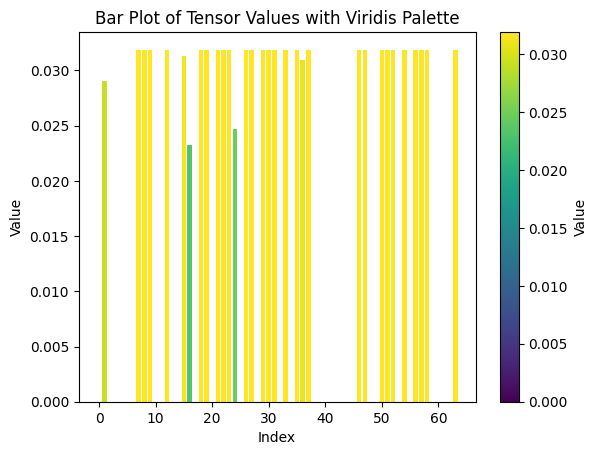

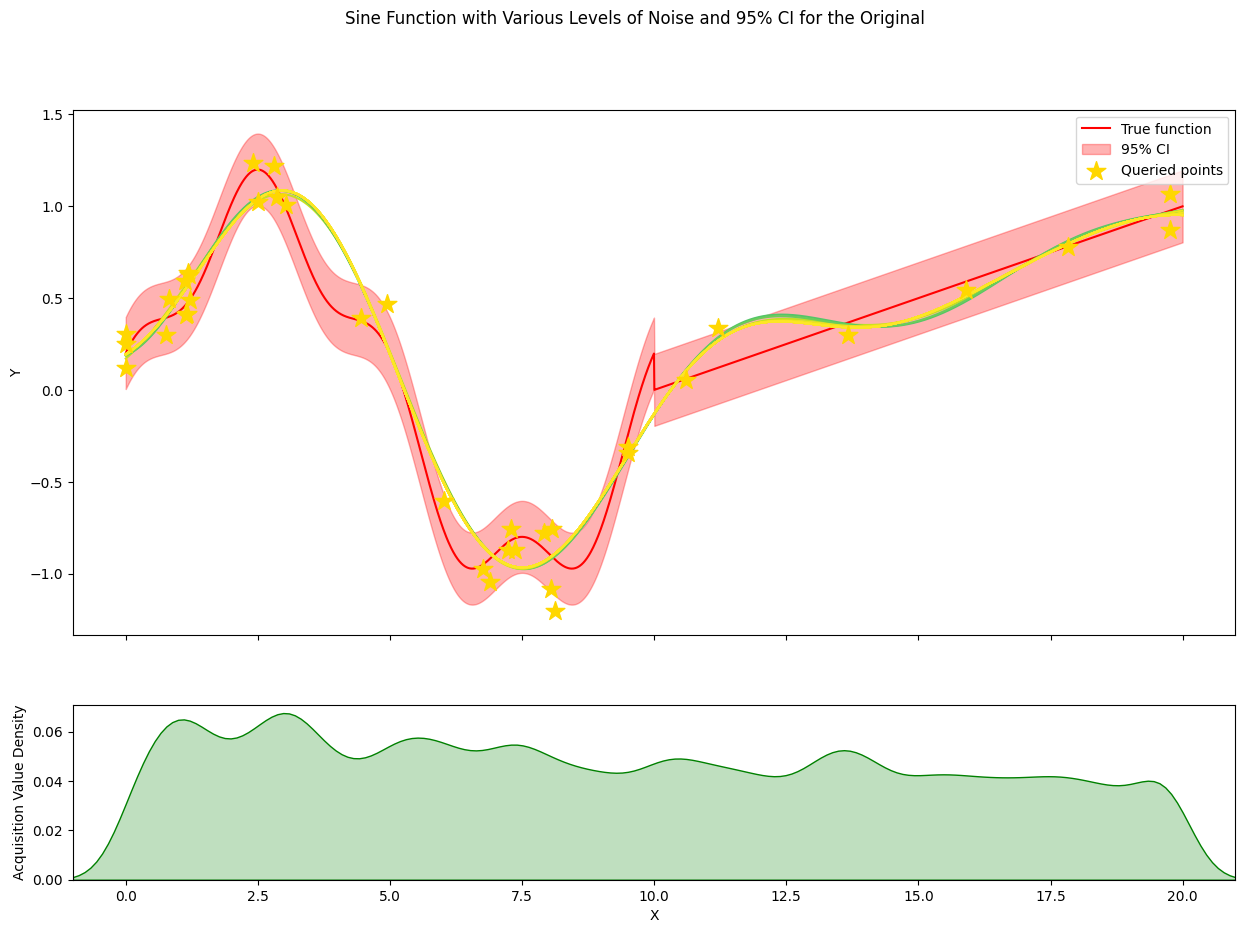

tensor([[8.7590e-14],
        [8.2635e-14],
        [9.5500e-14],
        ...,
        [1.1832e-13],
        [9.7908e-14],
        [1.0553e-13]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0376], dtype=torch.float64), 'lengthscale': tensor([[0.1176]], dtype=torch.float64), 'outputscale': tensor([0.7673], dtype=torch.float64), 'mean': tensor([0.2817], dtype=torch.float64)}
64
{'noise': tensor([2.1995e-01, 6.8393e+00, 2.5874e-01, 4.0711e+01, 2.1696e-02, 3.7235e-03,
        2.8176e-02, 6.2122e-01, 1.2005e+01, 1.2687e-02, 3.5102e+00, 4.8435e-01,
        1.8244e-02, 3.2351e+01, 1.1753e+01, 4.1806e+01, 2.2402e-01, 1.5157e-01,
        2.1294e+00, 1.3337e-01, 2.3618e+02, 1.8419e+00, 5.9077e-01, 3.6315e+01,
        5.2358e-02, 3.7587e+00, 3.9481e+02, 1.2540e-02, 5.3299e+00, 9.1925e+00,
        1.4768e+01, 5.8616e+01, 1.7687e-02, 6.1300e-02, 8.7860e+00, 3.9878e-02,
        1.8078e-01, 1.0338e+01, 1.4388e+00, 6.9643e-03, 4.6869e-02, 1.7921e+00,
        2.1247e-01

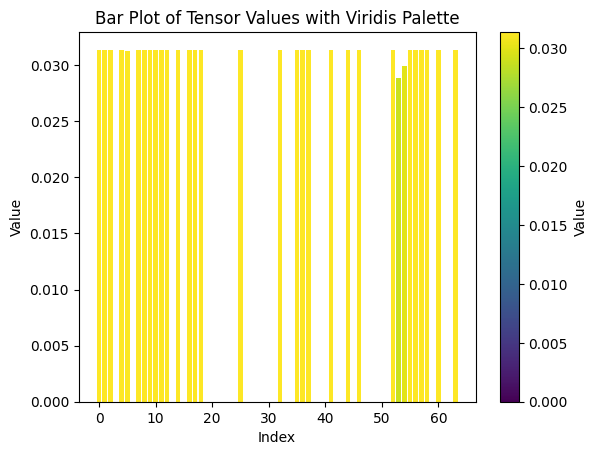

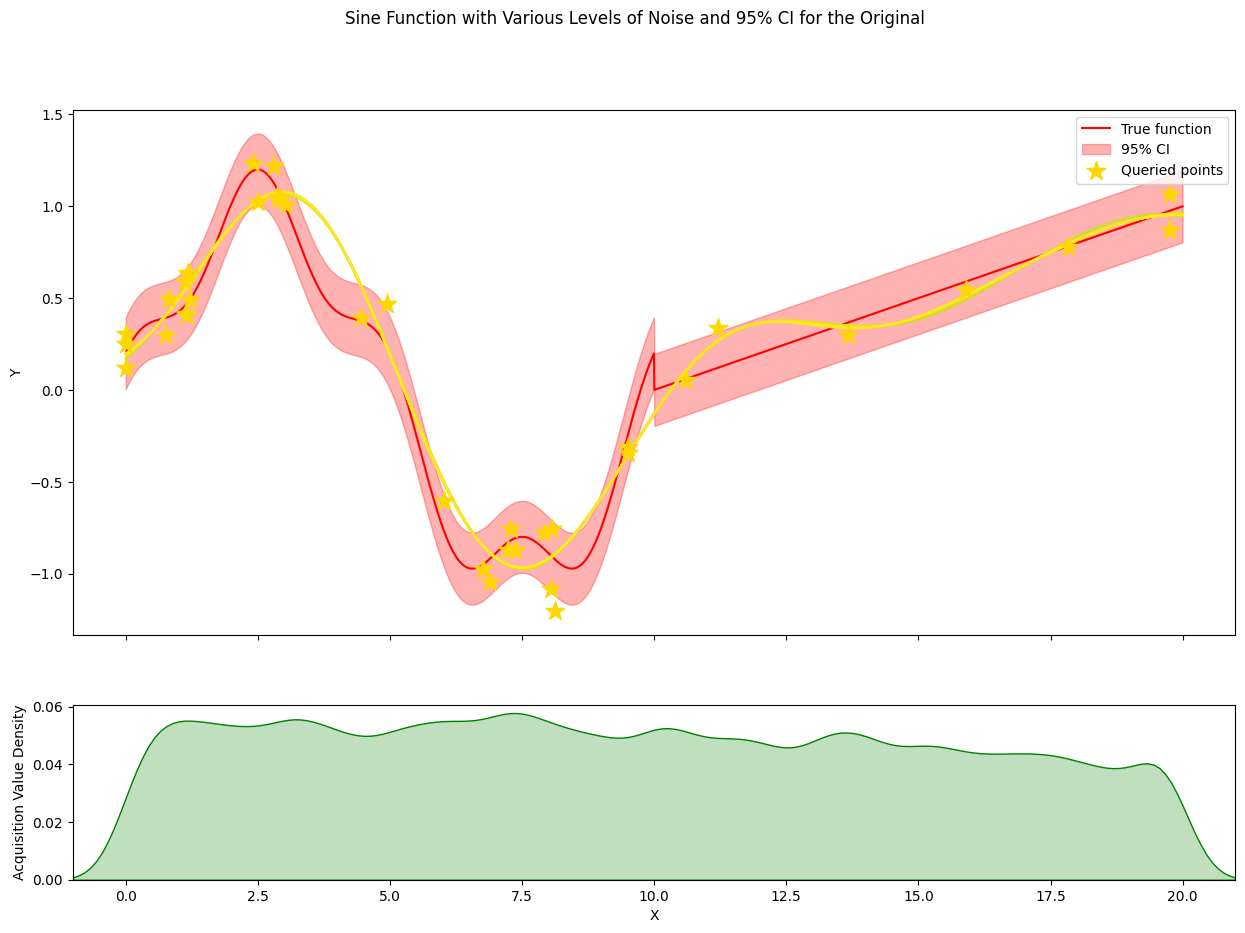

tensor([[6.0594e-13],
        [5.4463e-13],
        [6.2716e-13],
        ...,
        [6.4856e-13],
        [6.5394e-13],
        [6.4145e-13]], dtype=torch.float64, grad_fn=<SumBackward1>)
dict params
{'noise': tensor([0.0362], dtype=torch.float64), 'lengthscale': tensor([[0.1185]], dtype=torch.float64), 'outputscale': tensor([0.7611], dtype=torch.float64), 'mean': tensor([0.2477], dtype=torch.float64)}
64
{'noise': tensor([4.5381e+00, 5.6920e+00, 5.3012e-01, 7.8781e-01, 1.2227e-02, 1.4347e+00,
        1.3174e+01, 4.1845e-01, 3.1298e-04, 9.0235e-02, 5.8082e-02, 3.4186e-01,
        2.2109e+00, 8.2071e-02, 1.3726e-01, 2.4802e+01, 4.0546e-02, 1.6107e+00,
        2.8011e+00, 4.5025e+00, 7.9420e-02, 5.4380e-02, 3.8803e-02, 4.9230e+00,
        8.3557e+00, 3.2646e+01, 1.5782e-01, 3.1845e-02, 2.5950e+01, 1.6407e+01,
        4.4908e-01, 2.5451e+00, 6.1402e+00, 2.8831e+01, 2.6187e-02, 1.1671e-01,
        1.5747e-01, 1.2982e+00, 7.4542e-01, 4.0102e-02, 5.2386e-02, 2.3704e+00,
        2.1996e+01

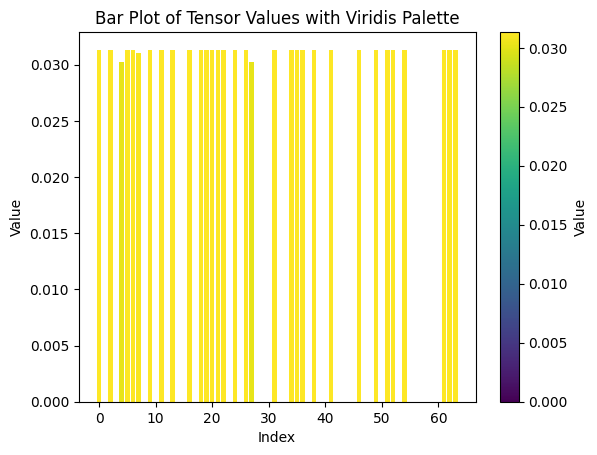

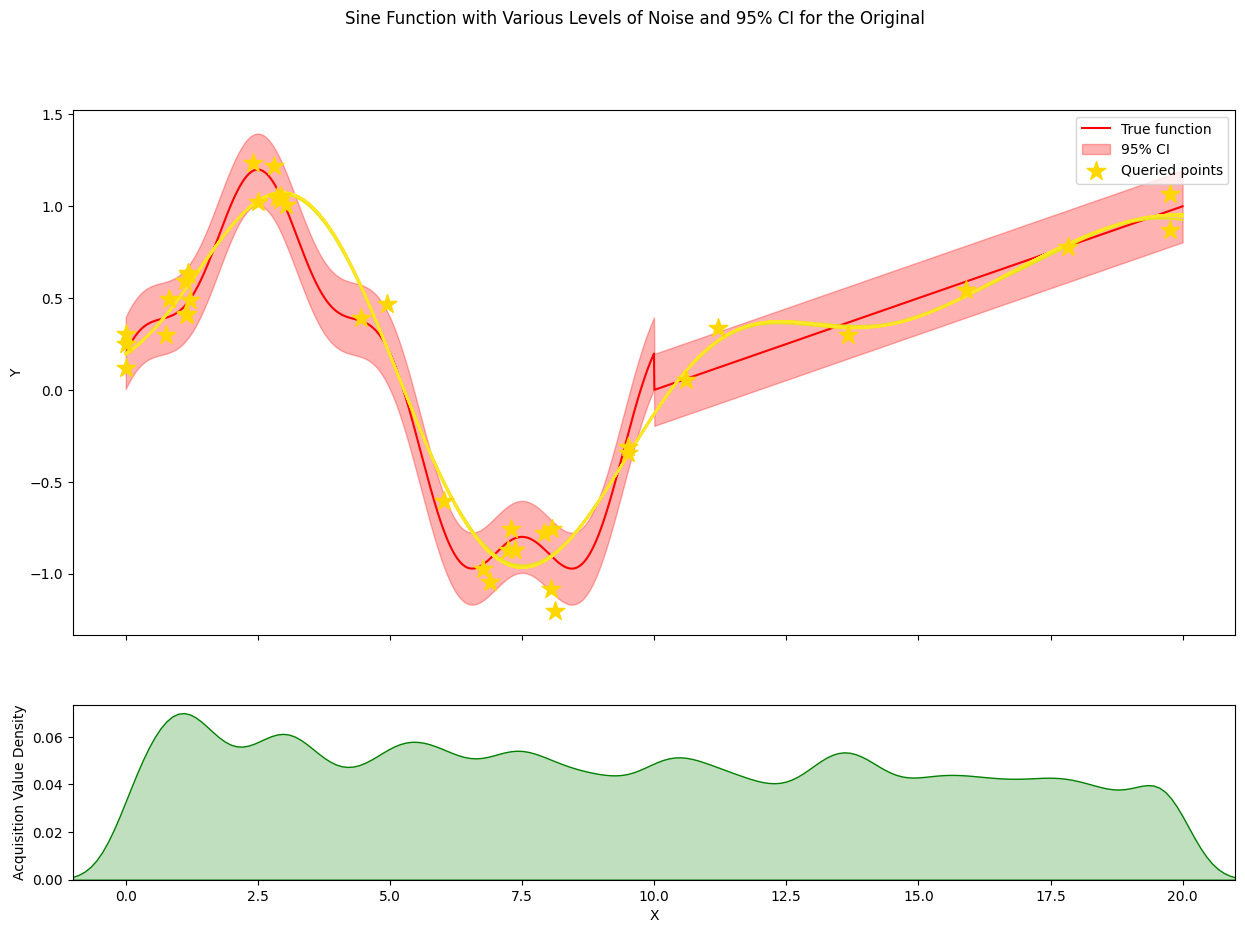

In [9]:
import matplotlib.pyplot as plt
synthetic_function = Higdon(noise_std=0.1).to(**tkwargs)
bounds = BOUNDS
    #print(bounds)
X = SobolEngine(dimension=DIM, scramble=True, seed=99).draw(3).to(**tkwargs)
    #print(X)
X_scaled = convert_bounds(X, BOUNDS, DIM)
Y = synthetic_function(X_scaled).unsqueeze(-1)
poolU = get_candidate_pool(dim=DIM, bounds=BOUNDS, size=10000).to(**tkwargs)
ewig_pool = poolU.clone()
X_test, Y_test = get_test_set(synthetic_function=synthetic_function, 
                                  bounds=bounds, 
                                  dim=DIM, 
                                  noise_std=0.1,
                                  size=10000)  
     
X_test, Y_test = X_test.to(**tkwargs), Y_test.to(**tkwargs)
dict_best_params = None
for i in range(60):
    train_Y = Y  # Flip the sign since we want to minimize f(x)
    gp = MGPFullyBayesianSingleTaskGP(
        train_X=X, 
        train_Y=train_Y, 
        #train_Yvar=torch.full_like(train_Y, 1e-6),
        #input_transform=Normalize(d=cfg.functions.dim, bounds=bountensor_scaledds),
        outcome_transform=Standardize(m=1)
    )
    if type == 'part_bayesian':
        ll = fit_partially_bayesian_mgp_model(model=gp,
                                                num_samples= 64,
                                                lr=0.1,
                                                learning_steps=300,
                                                print_iter=False,
                                                plot=False, 
                                                dict_params=dict_best_params)
        dict_best_params = get_best_model_params(gp, ll=ll)
        print(dict_best_params)
    else:
        ll = fit_fully_bayesian_mgp_model_nuts(gp,
                                            warmup_steps=256,
                                            num_samples=128 ,
                                            thinning=6,
                                            disable_progbar=False)
    acq_function = SALHellingerMMAcquisitionFunction(gp, ll=ll)
    if ll is not None:
        ll = ll.detach()
        likelihoods = ll.exp()
        median_val = np.percentile(likelihoods, 75)
        #print(median_val)

        likelihoods[likelihoods < median_val] = 0
        weights = likelihoods.pow(1).squeeze().div(likelihoods.pow(1).sum())
        npll = weights.numpy()
        norm = plt.Normalize(npll.min(), npll.max())
        colors = plt.cm.viridis(norm(npll))

    # Generate a sequence of colors from the 'viridis' colormap

    # Plotting
        plt.bar(range(len(npll)), npll, color=colors)
        plt.ylabel('Value')
        plt.xlabel('Index')
        plt.title('Bar Plot of Tensor Values with Viridis Palette')
        plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=plt.gca(), label='Value')
        plt.show()
    else:
        weights = ll

    acq_values = acq_function(poolU)
    acq_values_all = acq_function(ewig_pool)
    best_index = torch.argmax(acq_values)
    candidates = poolU[best_index].unsqueeze(-1)
    new_pool = torch.cat((poolU[:best_index], poolU[best_index + 1:]), dim=0)
    candidates, best_acq_value, poolU = candidates.T, acq_values[best_index].unsqueeze(-1), new_pool

    candidates_scaled = convert_bounds(candidates, BOUNDS, DIM)
    y_hat = get_yhat(gp, X_test, tkwargs)
    plot_gps(X_test, 0.1, synthetic_function, y_hat, X, Y,acq_values_all, weights)
    Y_next = synthetic_function(candidates_scaled).unsqueeze(-1)
    if DIM ==1:
        Y_next=Y_next.unsqueeze(-1)
    Y = torch.cat((Y, Y_next)).to(**tkwargs)
    X = torch.cat((X, candidates)).to(**tkwargs)
    print(acq_values)

In [ ]:
new=2
gp.covar_module.base_kernel.lengthscale[0].fill_(2.0)


tensor([[2.]], dtype=torch.float64, grad_fn=<AsStridedBackward0>)

In [ ]:
from scipy import optimize
from scipy import stats
def mode_params(gp):
    model_dict = gp.get_param_dict()
    decomposed_param_dict = {}
    decomposed_param_dict['noise'] = model_dict['noise'].detach().squeeze().numpy()
    decomposed_param_dict['outputscale']  = model_dict['outputscale'].detach().squeeze().numpy()
    for i in range(model_dict['lengthscale'].size()[1]):
        decomposed_param_dict['legthscale_'+str(i)] = model_dict['lengthscale'][:,i].squeeze().numpy()
    decomposed_param_dict['mean']  = model_dict['mean'].numpy()
    df_params = pd.DataFrame(decomposed_param_dict)
    print(df_params.head())
    array_params = df_params.values.T
    kernel = stats.gaussian_kde(array_params)
    print(kernel([0.3,0.1,2,0.3]))
    x0 = np.mean(array_params, axis=1)
    print(x0)
    bounds = [(1e-8, None) for i in range(array_params.shape[0]-1)]
    bounds.append((None,None))
    opt = optimize.minimize(lambda *args: -kernel(args), x0 =x0, method='L-BFGS-B', tol=1e-6, bounds= bounds)
    return opt

In [ ]:
mode_params(gp)

        noise  outputscale  legthscale_0      mean
0    0.984179     0.000312      6.838523  0.000009
1  195.532990     0.001218      0.726347  0.000014
2    0.022105     0.541360      0.053516  0.335248
3   24.227877     0.000936      0.095384  0.000157
4    0.998115     0.097048      2.705999  0.019385
[2.40100187e-07]
[123.21543936  41.06176612  10.41188608   0.29199194]


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.6506555894994154e-07
        x: [ 1.232e+02  4.106e+01  1.041e+01  2.920e-01]
      nit: 0
      jac: [ 2.516e-10  4.078e-10  8.842e-09  4.761e-08]
     nfev: 5
     njev: 1
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [ ]:
model_dict = gp.get_param_dict()
decomposed_param_dict = {}

In [ ]:
decomposed_param_dict['noise'] = model_dict['noise'].detach().squeeze().numpy()
decomposed_param_dict['outputscale']  = model_dict['outputscale'].detach().squeeze().numpy()
decomposed_param_dict['mean']  = model_dict['mean'].numpy()


In [ ]:
model_dict['lengthscale'][:,0].squeeze()

tensor([6.8385e+00, 7.2635e-01, 5.3516e-02, 9.5384e-02, 2.7060e+00, 1.6684e+00,
        8.5141e-02, 5.3516e-02, 4.3203e+01, 1.3627e+01, 5.3516e-02, 5.3516e-02,
        4.4466e+00, 3.9213e+01, 1.8479e+00, 5.1670e+01, 7.4322e+01, 5.3516e-02,
        2.0835e+00, 4.7904e+01, 2.6592e+01, 5.3516e-02, 5.3518e-02, 1.9843e-01,
        5.2711e-02, 5.3741e-02, 5.3507e-02, 1.4991e+01, 2.6706e-01, 5.3516e-02,
        5.3516e-02, 5.3516e-02], dtype=torch.float64)

In [ ]:
for i in range(model_dict['lengthscale'].size()[1]):
    decomposed_param_dict['legthscale_'+str(i)] = model_dict['lengthscale'][:,i].squeeze().numpy()

In [ ]:
df_params = pd.DataFrame(decomposed_param_dict)
array_params = df_params.values.T

In [ ]:
from scipy import optimize
from scipy import stats

In [ ]:
kernel = stats.gaussian_kde(array_params)
# Minimize the negative instead of maximizing
# Depending on the shape of your data, you might want to set some bounds
#opt = optimize.minimize_scalar(lambda x: -kernel(x))

In [ ]:
kernel([0,0,1,1])

array([6.66552138e-10])

In [ ]:
x0 = np.ones(array_params.shape[0])


In [ ]:
bounds = [(1e-8, None) for i in range(array_params.shape[0])]

In [ ]:
def neg_kde_value(x):
    return -kernel(x)

In [ ]:
opt = optimize.minimize(lambda *args: -kernel(args), x0 =x0, method='L-BFGS-B', tol=1e-6, bounds= bounds)
opt

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -7.121025873207498e-10
        x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00]
      nit: 0
      jac: [ 1.139e-11 -5.829e-11  1.197e-08  3.431e-11]
     nfev: 5
     njev: 1
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [ ]:
-kernel(array_params[:,15])

array([-4.38777467e-08])

In [ ]:
array_params[:,1]

array([1.95532990e+02, 1.21811493e-03, 1.35405145e-05, 7.26347207e-01])